# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 01 : Évaluation  de la qualité des données

---

### Identité du document
* **Population cible** : NonResidential
* **Statut :** Phase 1 (exploration & prototypage)
* **Date de création :** 29 Décembre 2025
* **Dernière mise à jour :** 02 Janvier 2025
* **Dépendances notebooks** : Notebook 0

### Description
Effectuer un audit exhaustif de la qualité des données pour identifier les problèmes potentiels avant toute analyse approfondie. Cela permet d'éviter des biais dans les étapes ultérieures et de documenter un plan de nettoyage clair.

>**L'énoncé demande** de nous limiter aux batiments non-residentiel,ce point sera éxaminé dans la suite



### Objectifs principaux
1. **Cartographier** la complétude des données (analyse des NaN).
2. **Distinguer** les erreurs manifestes des valeurs extrêmes légitimes.
3. **Valider** la cohérence interne (logique métier et physique).
4. **Évaluer** l'impact du flag `DefaultData`.
5. **Produire** un plan d'action pour le nettoyage.

### Dépendances critiques
* `hydra` : Gestion de configuration.
* `pandas`, `seaborn`, `matplotlib` : Manipulation et inspection visuelle.
* `src.data_quality/` : Fonctions à construire.

### LIVRABLES
1. **Rapport de Qualité**  : Synthèse des constats.
2. **Matrice de Stratégie**  : Plan d'action ligne par ligne.
3. **Figures d'audit** : Preuves visuelles.

---

---
# Table des Matières
- [Section 0 : Importation et Restriction aux populations non-residentiel ](#section-0--importation-et-chargement)
- [Section 1 : Cartographie des valeurs manquantes](#section-1--où-sont-les-données-manquantes-et-pourquoi)
- [Section 2 : Diagnostic de cohérence et erreurs physiques](#section-2--les-valeurs-extrêmes-sont-elles-des-erreurs-ou-des-réalités)
- [Section 3 : Détection et analyse contextuelle des valeurs aberrantes](#section-3--les-données-respectent-elles-la-logique-physique-et-métier)
- [Section 4 : Analyse de fiabilité](#section-4--le-flag-defaultdata-compromet-il-la-fiabilité)
- [Section 5 : Analyse de doublons](#section-5--existe-t-il-des-doublons-ou-des-quasi-doublons)
- [Section 6 : Plan d'action](#section-6--quelle-stratégie-de-nettoyage-adopter)

---

# Section 0 : Importation et Restriction aux populations non-residentiel 

## Importation des packages

In [27]:
import logging
import pandas as pd
from pathlib import Path
from datetime import datetime


# Import des fonctions utilitaires 

import sys
import os

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))


from data.load_data import load_data_raw
from utils.config_loader import load_config, create_directories
from utils.eda_logger import setup_eda_logger

# graphique package
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import plotly.express as px

# statistiques
from scipy.stats import chi2_contingency
from scipy import stats

# regex pour netoiyer nom colonne (exportation)
import re

# carte
import geopandas as gpd
import json


 


## init config et chargement

In [28]:
# Chargement de la configuration principale (Hydra)
cfg = load_config()

# Initialisation du logger
setup_eda_logger(cfg)
logger = logging.getLogger(__name__)

# Création des dossiers nécessaires à l'exécution (raw, interim, processed, reports, etc.)
create_directories(cfg)
# Chargement des données brutes

# Forcer pandas à afficher toutes les colonnes
pd.set_option("display.max_columns", None)

# Forcer pandas à afficher toutes les lignes (si besoin)
pd.set_option("display.max_rows", None)

# Forcer pandas à afficher toute la largeur (évite les "...")
pd.set_option("display.width", None)



df_raw = load_data_raw(cfg)

# Validation dimensions
n_rows, n_cols = df_raw.shape
logger.info(f"Dataset chargé ({n_rows} lignes, {n_cols} colonnes)")

# Premier aperçu
df_raw.sample(5)


2026-01-05 11:29:37,211 - utils.config_loader - INFO - Configuration 'config' chargée (project_root=C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2)
2026-01-05 11:29:37,219 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\raw
2026-01-05 11:29:37,221 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\interim
2026-01-05 11:29:37,222 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\processed
2026-01-05 11:29:37,227 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\figures
2026-01-05 11:29:37,229 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\reports
2026-01-05 11:29:37,262 - data.load_data - INFO - DataFrame chargé : 3376 lignes, 46 colonnes
2026-01-0

OSEBuildingID  DataYear          BuildingType    PrimaryPropertyType  \
1424          21771      2016  Multifamily MR (5-9)   Mid-Rise Multifamily   
410             569      2016        NonResidential     Mixed Use Property   
82              119      2016        NonResidential            K-12 School   
2803          27013      2016        NonResidential              Warehouse   
1152          21112      2016  Multifamily HR (10+)  High-Rise Multifamily   

                      PropertyName                 Address     City State  \
1424               Pickering Place          1307 N 43rd St  Seattle    WA   
410                  Pacific Tower  1200 12th Avenue South  Seattle    WA   
82           St. Joseph K-8 School        700 18th Ave. E.  Seattle    WA   
2803  Northwest Wholesale Florists      525 S Front Street  Seattle    WA   
1152          Cambridge Apartments           903 Union St.  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
1424  98103.0                    2513500030                    4   
410   98144.0                    2829600110                    2   
82    98112.0                    1336800825                    3   
2803  98108.0                    5367200820                    2   
1152  98101.0                    1978200225                    7   

          Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
1424        LAKE UNION  47.65904 -122.34180       2001                1.0   
410   GREATER DUWAMISH  47.59280 -122.31599       1932                1.0   
82                EAST  47.62548 -122.30828       1923                1.0   
2803  GREATER DUWAMISH  47.54761 -122.32759       1960                1.0   
1152              EAST  47.61150 -122.32984       1922                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
1424               5             53281               16572   
410               14            304052                   0   
82                 3             67743                   0   
2803               1             44476                   0   
1152              10             90920                   0   

      PropertyGFABuilding(s)        ListOfAllPropertyUseTypes  \
1424                   36709     Multifamily Housing, Parking   
410                   304052  Medical Office, Office, Parking   
82                     67743                      K-12 School   
2803                   44476       Non-Refrigerated Warehouse   
1152                   90920              Multifamily Housing   

          LargestPropertyUseType  LargestPropertyUseTypeGFA  \
1424         Multifamily Housing                    36700.0   
410                       Office                   218918.0   
82                   K-12 School                    67743.0   
2803  Non-Refrigerated Warehouse                    41256.0   
1152         Multifamily Housing                   100000.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
1424                      Parking                           6000.0   
410                       Parking                         156487.0   
82                            NaN                              NaN   
2803                          NaN                              NaN   
1152                          NaN                              NaN   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
1424                         NaN                             NaN   
410               Medical Office                     84051.89844   
82                           NaN                             NaN   
2803                         NaN                             NaN   
1152                         NaN                             NaN   

     YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
1424                      NaN             98.0         22.100000   
410                  20102008             66.0         69.400002   
82                       

## Restriction aux populations non-residentiel 


### Objectif et mission  
![Objectif et mission ](../figures/notebook_1/00_Objectif_Mission.png)  


L’objectif de ce projet est de prédire les émissions de CO₂ des bâtiments **non résidentiels**.

Ce périmètre est directement imposé par la problématique métier . Les bâtiments résidentiels et non résidentiels obéissent à des logiques d’usage, de consommation énergétique et de production d’émissions fondamentalement différentes. Les analyser conjointement introduirait une hétérogénéité structurelle incompatible avec un objectif de modélisation robuste.

La population cible du projet est définie à partir de la variable `BuildingType`. Cette variable permet de distinguer les bâtiments résidentiels des bâtiments non résidentiels et sert de base au filtrage appliqué dans la suite du projet.

Le choix est fait de restreindre l’analyse aux bâtiments non résidentiels dès les premières étapes, avant l’analyse exploratoire détaillée et les opérations de nettoyage. Ce filtrage précoce vise à garantir la cohérence statistique des analyses, la comparabilité des indicateurs énergétiques et la validité des relations étudiées entre les variables explicatives et les émissions de CO2.

La variable `BuildingType` étant une variable catégorielle administrative, son éventuelle imperfection ne peut être corrigée de manière fiable sans expertise métier approfondie. Elle est donc considérée suffisamment fiable pour définir la population d’étude à l’échelle globale du jeu de données. Les erreurs marginales de classification, si elles existent, sont supposées avoir un impact limité par rapport aux biais qu’introduirait le mélange des populations résidentielles et non résidentielles,de plus ces erreurs pourrons si detecté être corrigé dans la suite de ce notebook.

> **Ce choix méthodologique est assumé et conservé tout au long du projet.**



In [29]:
df_raw["BuildingType"].unique().tolist()



['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Campus',
 'Multifamily LR (1-4)',
 'Multifamily HR (10+)',
 'Nonresidential WA']

In [30]:
df_raw["BuildingType"].value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [31]:
residential_types = [
    "Multifamily MR (5-9)",
    "Multifamily HR (10+)",
    "Multifamily LR (1-4)"
]

df_raw = df_raw[~df_raw["BuildingType"].isin(residential_types)].copy()
df_raw.shape

(1668, 46)

In [32]:
df_raw["BuildingType"].value_counts()

BuildingType
NonResidential        1460
SPS-District K-12       98
Nonresidential COS      85
Campus                  24
Nonresidential WA        1
Name: count, dtype: int64

In [33]:
df_raw[df_raw["BuildingType"] == "Nonresidential WA"]

OSEBuildingID  DataYear       BuildingType PrimaryPropertyType  \
3359          50101      2016  Nonresidential WA          University   

      PropertyName               Address     City State  ZipCode  \
3359  Burke Museum  4331 Memorial Way NE  Seattle    WA  98195.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
3359                    1625049001                    4    NORTHEAST   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
3359  47.66127 -122.31256       1962                1.0               1   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
3359             68072                   0                   68072   

     ListOfAllPropertyUseTypes LargestPropertyUseType  \
3359        College/University     College/University   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
3359                    68916.0                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
3359                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  \
3359                             NaN                      NaN   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
3359              NaN         46.200001           46.200001   

      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
3359          144.899994            144.899994           3180819.25   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
3359             3180819.25             0.0       932244.6875   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
3359          3180819.0                 0.0               0.0        False   

      Comments ComplianceStatus Outlier  TotalGHGEmissions  \
3359       NaN        Compliant     NaN              22.17   

      GHGEmissionsIntensity  
3359                   0.33

In [34]:
df_raw[df_raw["PrimaryPropertyType"] == "University"].head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
24              30      2016  NonResidential          University   
104            170      2016  NonResidential          University   
105            172      2016          Campus          University   
114            182      2016  NonResidential          University   
128            211      2016          Campus          University   

                PropertyName             Address     City State  ZipCode  \
24        Main Campus Center     1000 Lenora St.  Seattle    WA  98121.0   
104  SCCC FINE ARTS BUILDING       801 E PINE ST  Seattle    WA  98122.0   
105         SSCC MAIN CAMPUS    6000 16th Ave SW  Seattle    WA  98106.0   
114         Otto Miller Hall     3469 3rd Ave. W  Seattle    WA  98119.0   
128         NSCC MAIN CAMPUS  9600 COLLEGE WAY N  Seattle    WA  98103.0   

    TaxParcelIdentificationNumber  CouncilDistrictCode           Neighborhood  \
24                     0660001420                    7               DOWNTOWN   
104                    6003000470                    3                   EAST   
105                    6171900005                    1               DELRIDGE   
114                    7443000070                    7  MAGNOLIA / QUEEN ANNE   
128                    3226049021                    5              NORTHWEST   

     Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
24   47.61816 -122.33629       1928                1.0               7   
104  47.61495 -122.32177       1915                1.0               3   
105  47.54700 -122.35307       1970               27.0               2   
114  47.65147 -122.36122       1980                1.0               2   
128  47.69936 -122.33401       1970               11.0               2   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
24             126593                   0                  126593   
104             63330                   0                   63330   
105            441071                   0                  441071   
114             52611                   0                   52611   
128            694072              111625                  582447   

    ListOfAllPropertyUseTypes LargestPropertyUseType  \
24         College/University     College/University   
104        College/University     College/University   
105        College/University     College/University   
114        College/University     College/University   
128        College/University     College/University   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
24                    125000.0                          NaN   
104                    64820.0                          NaN   
105                   483000.0                          NaN   
114                    52611.0                          NaN   
128                   667335.0                          NaN   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
24                               NaN                         NaN   
104                              NaN                         NaN   
105                              NaN                         NaN   
114                              NaN                         NaN   
128                              NaN                         NaN   

     ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
24                              NaN                      NaN              NaN   
104                             NaN                      NaN              NaN   
105                             NaN                      NaN              NaN   
114                             NaN                      NaN              NaN   
128                             NaN                      NaN              NaN   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
24          90.699997           97.500000          173.000000   
104         47.200001           50.700001         

![Burke  Museum ](../figures/notebook_1/00_Burke_Museum.png)  


---
Le batiment d'identifiant 50101, est seul dans sa categorie Type de batiment mais si on regarde sa sous-classe primarypropertyType,elle est cohenrente avec les autres unversity meme si c'est un musé, en terme de modalite avec les autres.

>Au vue des definitions des modalite de BuildingType,la classe qui correspond est non-residential


In [35]:
df_raw["BuildingType"] = df_raw["BuildingType"].replace({
    "Nonresidential WA": "NonResidential"
})


In [36]:
df_raw["BuildingType"].value_counts()

BuildingType
NonResidential        1461
SPS-District K-12       98
Nonresidential COS      85
Campus                  24
Name: count, dtype: int64

# Section 1 : Cartographie des valeurs manquantes

**Objectif :** Quantifier et visualiser les valeurs manquantes pour identifier les patterns et mécanismes sous-jacents. Cela aide à évaluer la complétude du dataset et à anticiper les biais.

Population :Les batiments non-résidentiel

## Calcul des pourcentages de NaN

Nous calculons le % de NaN par colonne et trions par ordre décroissant.
Colonnes avec >50% de NaN sont candidates à suppression.

In [37]:
# df_raw['Comments'].isnull()

In [38]:

print(df_raw['ComplianceStatus'].describe())
print("\nComptage par catégorie :")
print(df_raw['ComplianceStatus'].value_counts())



count          1668
unique            4
top       Compliant
freq           1548
Name: ComplianceStatus, dtype: object

Comptage par catégorie :
ComplianceStatus
Compliant                       1548
Error - Correct Default Data      88
Non-Compliant                     18
Missing Data                      14
Name: count, dtype: int64


La variable `ComplianceStatus` renseigne si une propriété a satisfait aux exigences de reporting énergétique pour l’année étudiée.  
La grande majorité des bâtiments apparaissent comme Compliant, tandis qu’une minorité est classée Error - Correct Default Data, Non-Compliant ou Missing Data.  

Même si la proportion de cas problématiques reste faible, cette variable jouera un rôle en fin d’audit. Elle nous permettra de confronter nos stratégies de nettoyage aux statuts officiels et de vérifier, par exemple, si certains bâtiments Non-Compliant ou marqués en Error ont été conservés par inadvertance. En ce sens, `ComplianceStatus` servira de balise de fiabilité pour valider nos choix méthodologiques.est ce que lors d'une strategie du type imputation par la médiane,est ce qu'une ligne de compliancesStatus error a servi lors du calcul d'une médiane.

>Bon finalement nous avons décider par prudence de supprimer tous les batiments qui ne sont pas conforme,ils ne sont pas nombreux,La minicipalité de seatle a surement eu de bonnes raisons de les écarter.



In [39]:
# Calcul des NaN
missing_perc = df_raw.isnull().mean() * 100 # mean() calcule la proportion de NaN par colonne
missing_df = pd.DataFrame({'Column': missing_perc.index, '% Missing': missing_perc.values})
missing_df = missing_df.sort_values(by='% Missing', ascending=False).reset_index(drop=True)

logger.info("Colonnes avec le plus de NaN :")
display(missing_df.head(30))

# Identification colonnes >50% NaN
high_missing = missing_df[missing_df['% Missing'] > 50]
logger.info(f"Colonnes avec >50% NaN : {high_missing['Column'].tolist()}")

2026-01-05 11:29:37,665 - __main__ - INFO - Colonnes avec le plus de NaN :


Column   % Missing
0                          Comments  100.000000
1                           Outlier   98.980815
2          YearsENERGYSTARCertified   94.124700
3       ThirdLargestPropertyUseType   78.836930
4    ThirdLargestPropertyUseTypeGFA   78.836930
5      SecondLargestPropertyUseType   48.741007
6   SecondLargestPropertyUseTypeGFA   48.741007
7                   ENERGYSTARScore   34.412470
8                           ZipCode    0.959233
9            LargestPropertyUseType    0.359712
10        LargestPropertyUseTypeGFA    0.359712
11                 SiteEUI(kBtu/sf)    0.179856
12               SiteEUIWN(kBtu/sf)    0.179856
13            SiteEnergyUseWN(kBtu)    0.179856
14                Electricity(kBtu)    0.119904
15                 Electricity(kWh)    0.119904
16                 NaturalGas(kBtu)    0.119904
17               NaturalGas(therms)    0.119904
18            GHGEmissionsIntensity    0.119904
19                   SteamUse(kBtu)    0.119904
20             SourceEUIWN(kBtu/sf)    0.119904
21               SourceEUI(kBtu/sf)    0.119904
22                TotalGHGEmissions    0.119904
23                NumberofBuildings    0.119904
24        ListOfAllPropertyUseTypes    0.119904
25              SiteEnergyUse(kBtu)    0.119904
26                    OSEBuildingID    0.000000
27                     PropertyName    0.000000
28              PrimaryPropertyType    0.000000
29                     BuildingType    0.000000

2026-01-05 11:29:37,678 - __main__ - INFO - Colonnes avec >50% NaN : ['Comments', 'Outlier', 'YearsENERGYSTARCertified', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']


> techniquement ([pandas.isnull()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html)) permet de detecter la plus part des valeurs manquantes,si on en oubli certains ,great expectation pourra les détecter

On constate que beaucoup de variables ont des valeurs manquantes, notamment 8 colonnes critiques qui dépassent les 33 % de NAN. Les variables `Comments`, `Outlier` et `YearsENERGYSTARCertified` sont quasiment inexistantes (entre 94 % et 100 % de NA), ce qui les rend statistiquement inexploitables.Toute fois `Outlier` est interessant car elle indique si un batiment est suspecté Outlider ou pas donc peux servir à la section 3.

De même, les données liées aux usages secondaires et tertiaires des bâtiments présentent des taux de NA massifs, révélant que la majorité des structures déclarées n'ont qu'une seule activité principale ou que ces informations n'ont pas été jugées nécessaires lors de la saisie.

Le **ENERGYSTARScore** constitue un point de vigilance majeur avec environ 33 % de données manquantes.

À l'inverse, on peut noter que les variables comme la consommation réelle d'énergie et les émissions de gaz à effet de serre sont assez robustes, avec moins de 1 % de NA. Cette solidité sur les indicateurs de performance réels garantit que, malgré l'élimination nécessaire des colonnes lacunaires, le cœur du dataset restera parfaitement fiable en vue de la modélisation.

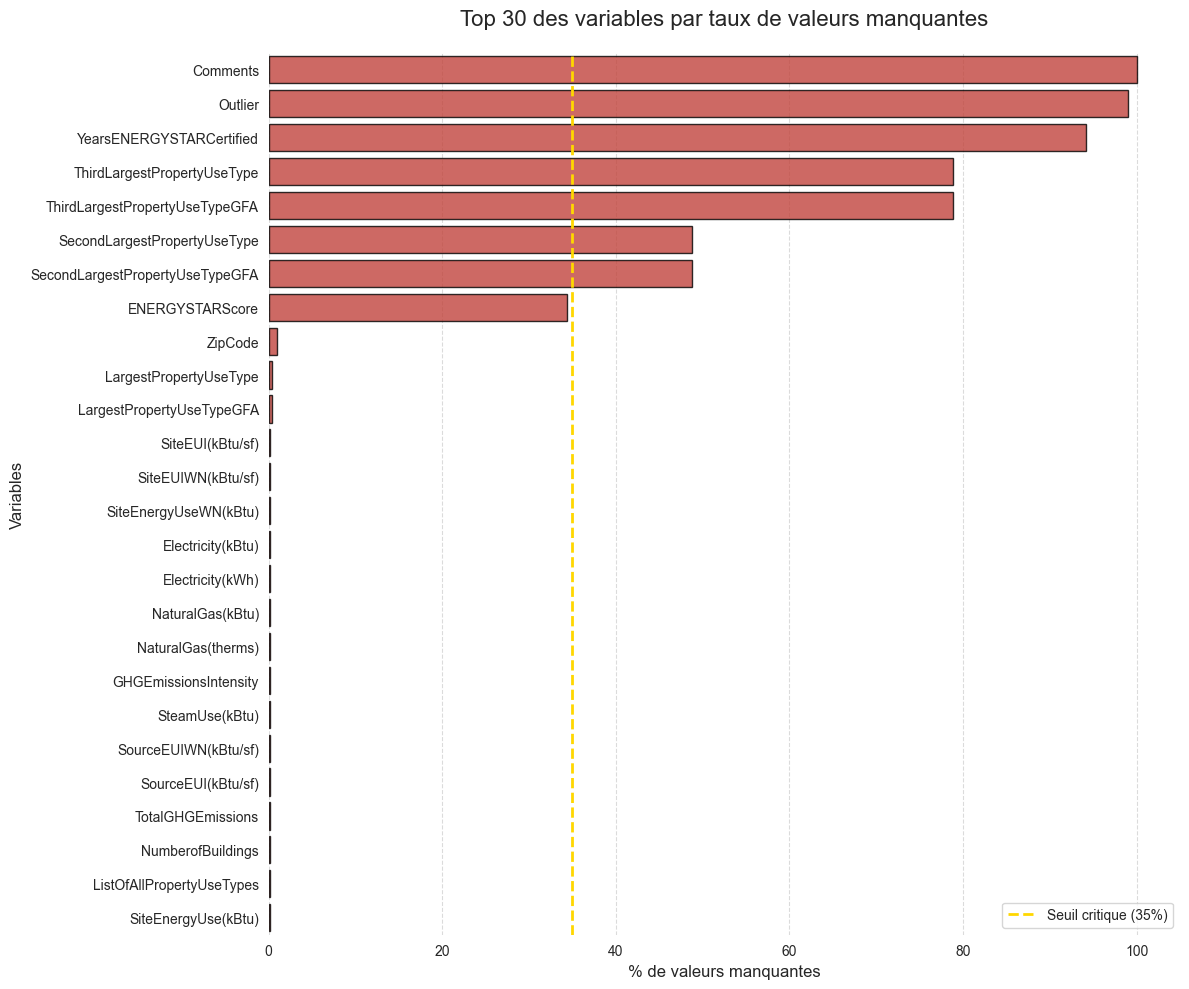

2026-01-05 11:29:39,780 - __main__ - INFO - Graphique des NA : ../figures/notebook_1/01_data_NA_bar.png


In [40]:
# Graphique

# Filtrage pour ne garder que les colonnes ayant des valeurs manquantes
missing_data_plot = missing_df[missing_df['% Missing'] > 0].head(30)

# Création du graphique
plt.figure(figsize=(12, 10))
sns.set_style("white")

# 
barplot = sns.barplot(
    data=missing_data_plot, 
    x='% Missing', 
    y='Column', 
    color='#d73027',
    edgecolor='black',
    alpha=0.8
)

# Ajout d'une ligne de seuil à 35% 
plt.axvline(x=35, color='gold', linestyle='--', linewidth=2, label='Seuil critique (35%)')

# Personnalisation
plt.title('Top 30 des variables par taux de valeurs manquantes', fontsize=16, pad=20)
plt.xlabel('% de valeurs manquantes', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.legend(loc='lower right', frameon=True)

# Ajout d'une grille légère sur l'axe X uniquement
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

# Exportation du graphique
plt.tight_layout()
plt.savefig('../figures/notebook_1/01_data_NA_bar.png', dpi=300, bbox_inches='tight')
plt.show()

logger.info("Graphique des NA : ../figures/notebook_1/01_data_NA_bar.png")

## Visualisation : Heatmap de missingness

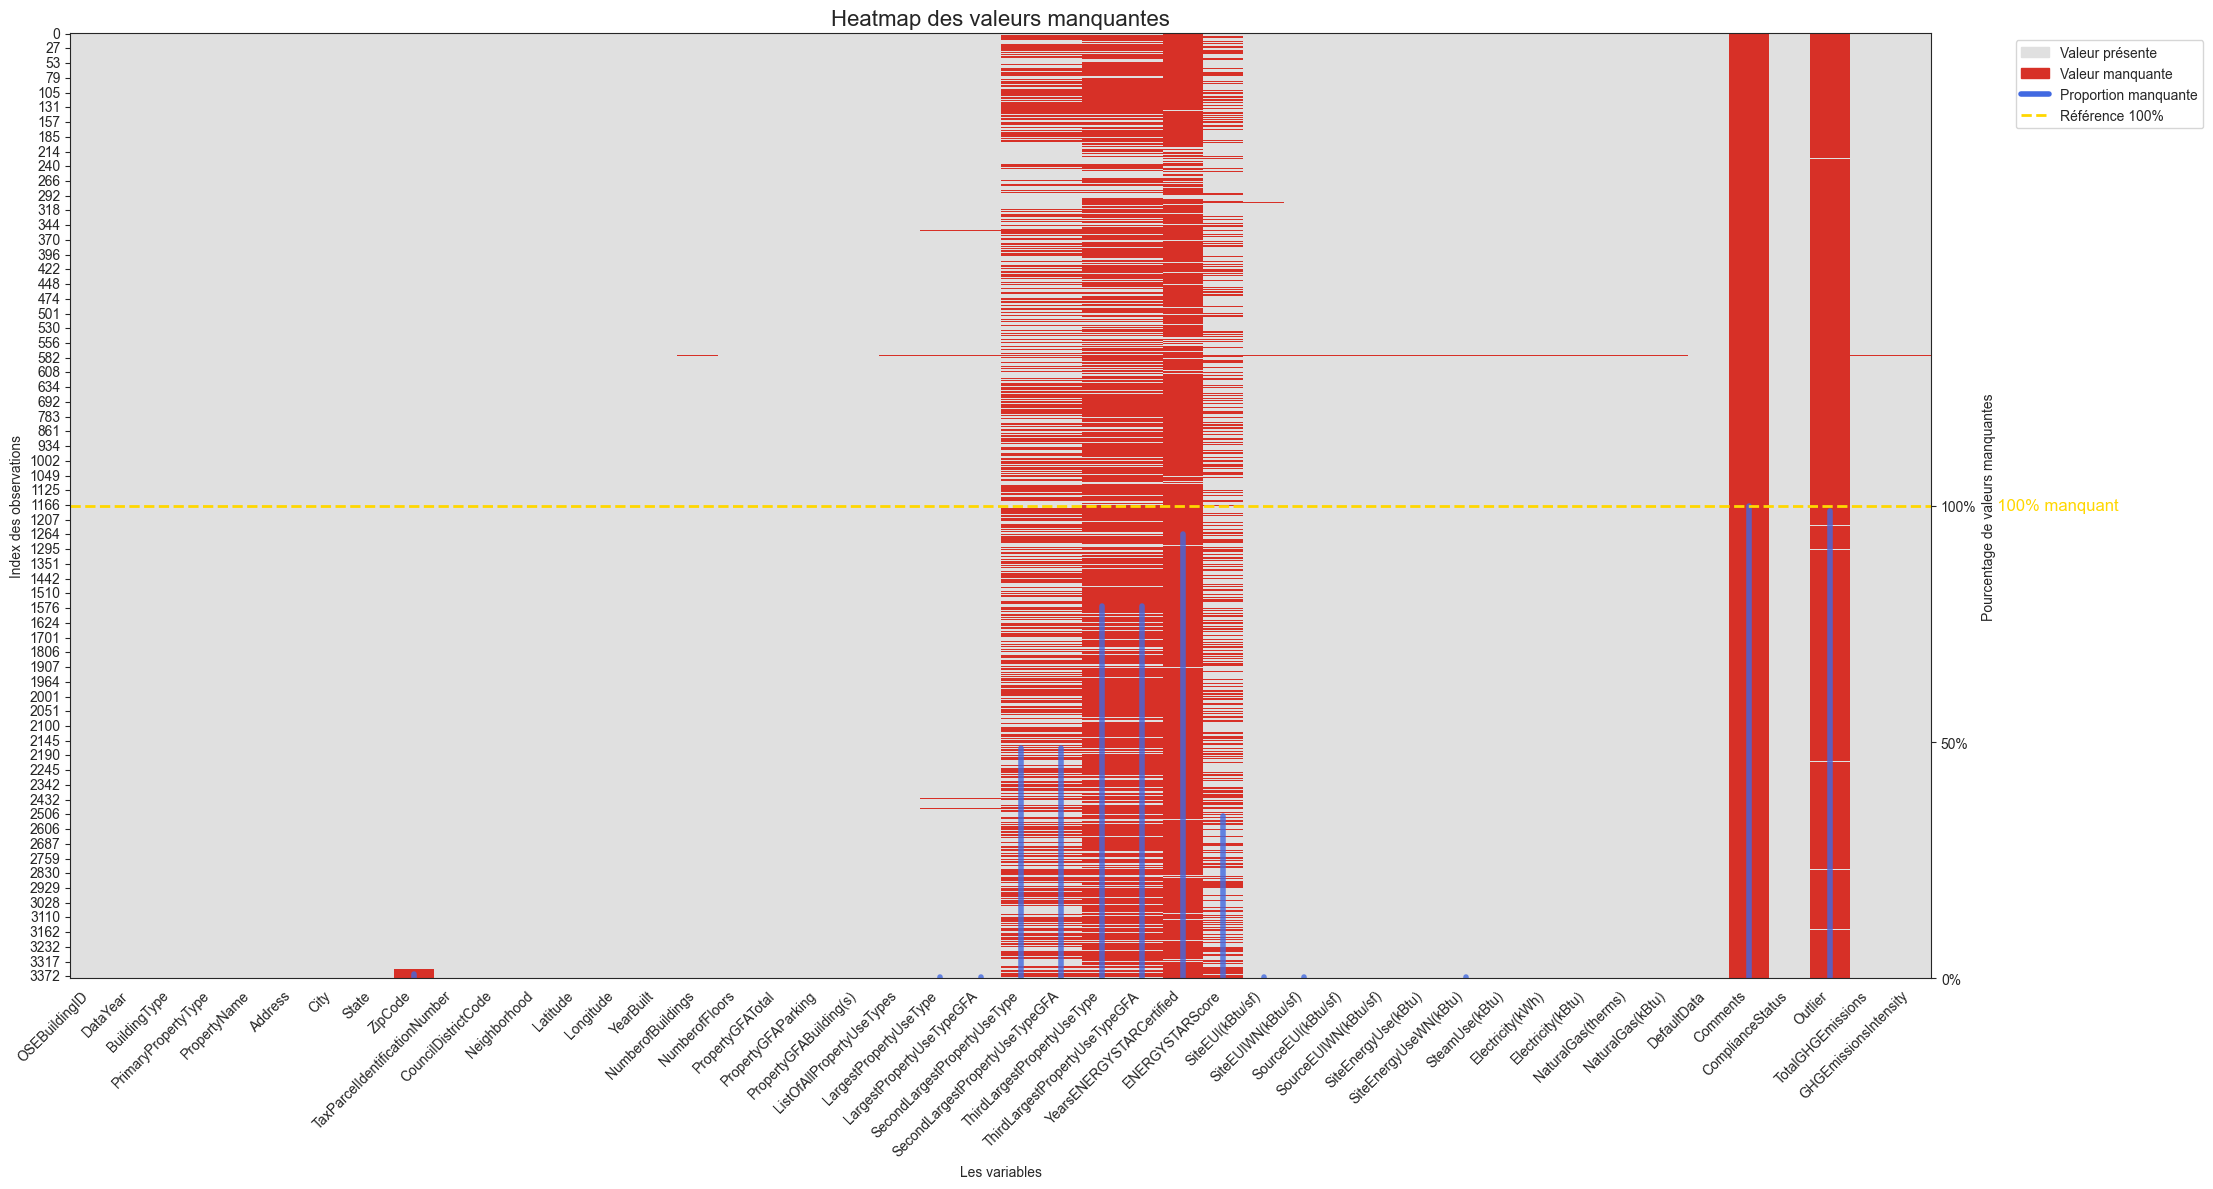

In [41]:

# Calcul du pourcentage de valeurs manquantes par colonne
missing_ratio = df_raw.isnull().mean()

plt.figure(figsize=(22, 12))

# Heatmap binaire
ax = sns.heatmap(df_raw.isnull(),
                 cbar=False,
                 cmap=['#e0e0e0', '#d73027'])  # gris = présent, rouge = manquant

# Titre et axes
plt.title('Heatmap des valeurs manquantes', fontsize=16)
plt.xlabel("Les variables")
plt.ylabel("Index des observations")
plt.xticks(rotation=45, ha='right')

# Ajout des barres verticales
n_rows = len(df_raw)
for i, ratio in enumerate(missing_ratio):
    bar_height = ratio * (n_rows * 0.5)  # 100% correspond à la moitié de l'axe
    ax.plot([i+0.5, i+0.5],
            [n_rows, n_rows - bar_height],
            color='royalblue', linewidth=4, alpha=0.8)

# Ligne jaune pour indiquer la barre des 100% manquants
ax.axhline(y=n_rows - n_rows*0.5, color='gold', linestyle='--', linewidth=2)
ax.text(len(missing_ratio)+0.5, n_rows - n_rows*0.5, "          100% manquant", 
        color='gold', va='center', fontsize=12)

# Axe des pourcentages à gauche
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel("Pourcentage de valeurs manquantes")
ax2.set_yticks([n_rows, n_rows - n_rows*0.25, n_rows - n_rows*0.5])
ax2.set_yticklabels(["0%", "50%", "100%"])

# Légende 
present_patch = mpatches.Patch(color='#e0e0e0', label='Valeur présente')
missing_patch = mpatches.Patch(color='#d73027', label='Valeur manquante')
line_patch = Line2D([0], [0], color='royalblue', linewidth=4, label='Proportion manquante')
ref_patch = Line2D([0], [0], color='gold', linestyle='--', linewidth=2, label='Référence 100%')
plt.legend(handles=[present_patch, missing_patch, line_patch, ref_patch],
           loc='upper right',
           bbox_to_anchor=(1.15, 1),
           frameon=True)

plt.tight_layout()
plt.savefig('../figures/notebook_1/02_quality_missing_heatmap.png',
            dpi=300, bbox_inches='tight')
plt.show()


Même observations que précédement

## Analyse diagnostique des mécanismes de données manquantes par colonne

L'objectif de cette section est de déterminer le mécanisme sous-jacent (MCAR, MAR ou MNAR) afin de choisir la stratégie de traitement appropriée. Selon la littérature, nous distinguons trois mécanismes fondamentaux :

- MCAR (Missing Completely At Random) : La probabilité qu'une donnée manque est indépendante de toute valeur, observée ou non. La suppression n'introduit pas de biais.

- MAR (Missing At Random) : L'absence dépend de variables observées. Exemple : Les bâtiments anciens (YearBuilt) rapportent moins souvent leur score Energy Star. L'imputation conditionel est ici recommandée.

- MNAR (Missing Not At Random) : L'absence dépend de la valeur manquante elle-même. Exemple : Un propriétaire ne déclare pas sa consommation car elle est anormalement élevée. Ce cas est le plus complexe et nécessite souvent une modélisation spécifique.
Source :https://bookdown.org/mike/data_analysis/diagnosing-the-missing-data-mechanism.html

### Matrice de corrélation

Nous utilisons d'abord une matrice de corrélation pour identifier les dépendances structurelles (variables qui manquent systématiquement ensemble).

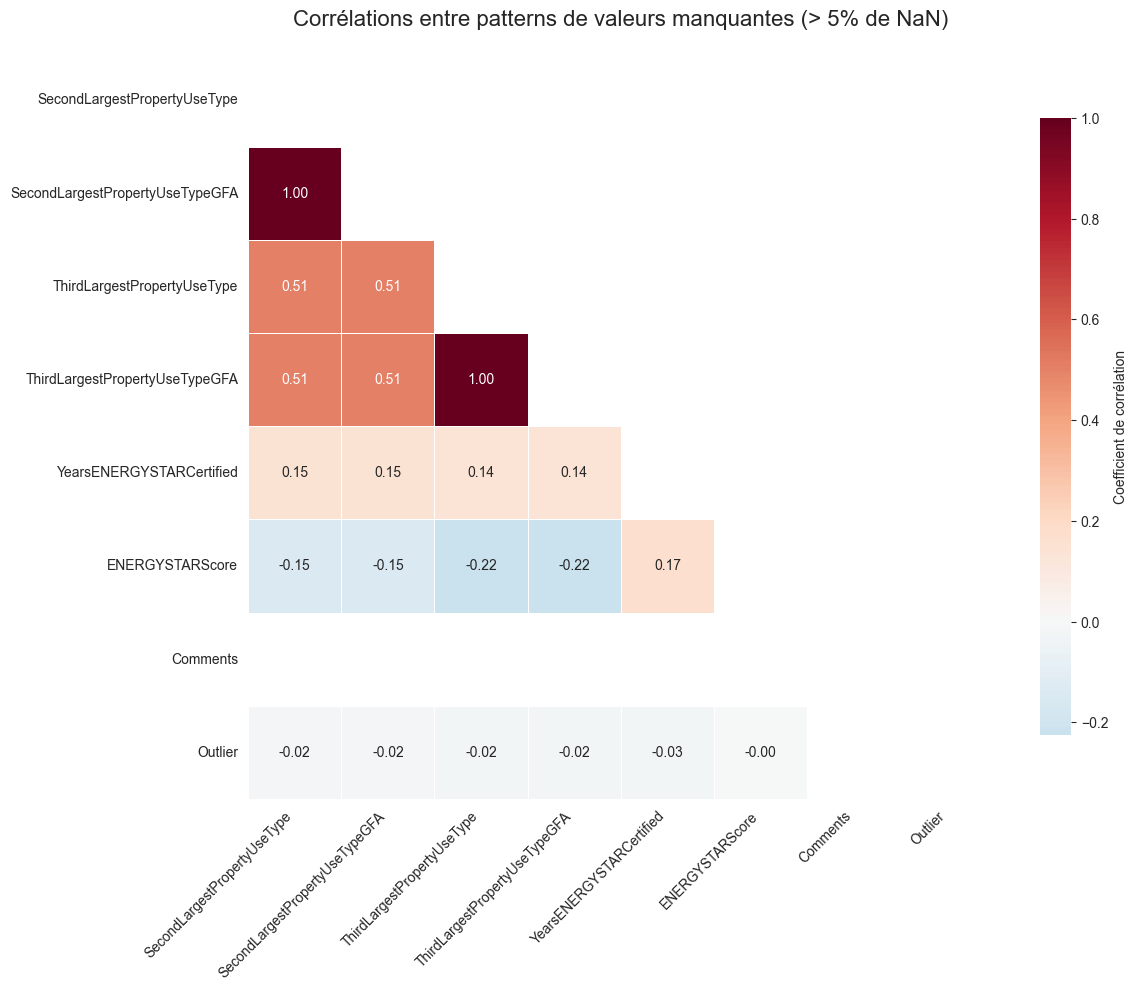

In [42]:
# Sélection des colonnes ayant plus de 5% de valeurs manquantes
threshold = 0.05
missing_rates = df_raw.isnull().mean()
cols_with_missing = missing_rates[missing_rates > threshold].index.tolist()

if len(cols_with_missing) > 1: # Afin de pouvoir tester differents valeurs de threshold
    # Calcul de la corrélation
    missing_corr = df_raw[cols_with_missing].isnull().corr()

    # Masque triangulaire pour la lisibilité
    mask = np.triu(np.ones_like(missing_corr, dtype=bool))

    plt.figure(figsize=(12, 10))

    # RdBu_r : Rouge pour corrélation positive , Bleu pour négative
    sns.heatmap(missing_corr,
                cmap='RdBu_r', 
                center=0,
                annot=True,
                fmt=".2f",
                mask=mask,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8, "label": "Coefficient de corrélation"})

    plt.title('Corrélations entre patterns de valeurs manquantes (> 5% de NaN)', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Exportation
    plt.savefig('../figures/notebook_1/03_quality_missing_corr.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Pas assez de variables significatives pour établir une matrice de corrélation.")


---

### Diagnostic et stratégie de traitement des valeurs manquantes

L'analyse des NA est une étape charnière pour orienter notre stratégie de modélisation. Le tableau suivant récapitule les variables présentant plus de 5% de valeurs manquantes, en y intégrant les taux réels observés dans notre diagnostic technique.


Pour des variables à faible taux de valeurs manquantes (moins de 5 %,en vrai ils ont moins de 1% de NA), nous procéderons à une imputation simple groupé suivant le type d'usage du batiment principale (médiane pour les variables quantitatives, modalité majoritaire pour les variables qualitatives), car l’impact statistique de ces imputations reste négligeable sur la distribution globale des données et ne biaise pas significativement les estimations du modèle lorsque la proportion de valeurs manquantes est marginale.
>En effet, pour des proportions de données manquantes faibles (< 5 %), les méthodes d’imputation simples sont considérées comme appropriées et efficaces pour restaurer un ensemble de données complet sans complexité inutile.

**Source** :[A Comprehensive Guide to Data Imputation: Techniques, Strategies, and Best Practices (Medium)](https://medium.com/%40tarangds/a-comprehensive-guide-to-data-imputation-techniques-strategies-and-best-practices-152a10fee543) , qui recommande l’utilisation de méthodes simples comme la moyenne ou le mode pour des proportions faibles de données manquantes.



#### Tableau des variables à forte proportion de NaNs (> 5%)

| Colonne | Taux de NaNs | Description | Décision & Recommandation |
| --- | --- | --- | --- |
| **Comments** | 100% | Commentaires libres des agents. | **Suppression immédiate**. Aucun apport pour la modélisation. |
| **Outlier** | 98.99% | Signalement des valeurs atypiques. | **Utilisation pour le diagnostic** puis suppression avant l'entraînement. |
| **YearsENERGYSTARCertified** | 94.26% | Historique des certifications. | **Suppression**. La densité de données est trop faible pour être exploitable. |
| **ThirdLargestPropertyUseType** (et GFA) | 78.18% | Troisième usage du bâtiment. | **Suppression**. Concerne moins d'un bâtiment sur cinq ; risque de sur-apprentissage. |
| **SecondLargestPropertyUseType** (et GFA) | 47.75% | Deuxième usage du bâtiment. | **Transformation binaire** Création d'une variable binaire (0 = absent, 1 = présent) + suppression de GFA |
| **ENERGYSTARScore** | 34.01% | Note de performance globale. | **Variable critique**. Nécessite un exament. |

---

### Analyse de la matrice de corrélation des manquants

L'examen de la matrice de corrélation des patterns de valeurs manquantes permet de dégager des logiques de remplissage qui ne sont pas dues au hasard.

Le résultat le plus frappant est la corrélation de 1 entre les types d'usages (SecondLargestPropertyUseType) et leurs surfaces respectives (GFA). Cette relation parfaite indique que le dataset est exempt d'erreurs de saisie contradictoires sur ce point : dès qu'un usage est déclaré, sa surface l'est aussi, et inversement. On ne parle pas ici d'une perte d'information accidentelle, mais d'une absence structurelle. Si la donnée est absente, c'est que l'usage n'existe pas. Cette observation justifie notre choix de transformer ces colonnes en indicateurs binaires.

On observe une corrélation modérée de 0.51 entre l'absence d'un second usage et celle d'un troisième. Cela confirme une structure "en entonnoir" : la présence d'un troisième usage est conditionnée par l'existence d'un second. Cette dépendance statistique suggère que la mixité des bâtiments suit une progression logique. Plus un bâtiment est complexe (usage 3), plus il est probable qu'il ait déjà été identifié comme mixte (usage 2).
>Recommandation (feature  feature engineering) : Création d'une variable catégorielle ( "mono-usage", "double usage", "triple usage") pour capturer la structure hiérarchique des bâtiments.

La variable ENERGYSTARScore présente des coefficients très faibles (entre -0.14 et -0.22) avec les autres variables de surface. Contrairement aux usages secondaires, l'absence du score n'est pas dictée par la structure physique ou la complexité du bâtiment. Un bâtiment très simple peut ne pas avoir de score, tout comme un gratte-ciel complexe.Nous examinerons son cas.

Enfin, les variables Outlier et Comments montrent des corrélations proches de 0.00 avec tout le reste du dataset. Cela confirme que ces colonnes sont remplies (ou plutôt vidées) de manière totalement indépendante du reste des caractéristiques techniques. À plus de 99% de vide, elles représentent un bruit inutile pour nos futurs modèles.

---

### Synthèse et orientations :
- imputation simple groupé suivant le type d'usage du batiment principale pour les colonnes avec moins de 1% de NA
- L'absence de données sur les usages secondaires étant informative (bâtiment mono-usage), nous allons créer la feature IsMixedUse. Cela permet de conserver l'essence de l'information sans gérer des colonnes à moitié vides.
- Puisque le ENERGYSTARScore ne suit pas le pattern des autres manquants, nous ne pouvons pas le binariser. Nous allons l'étudier de plus près pour une imputation précise.
- Les colonnes à corrélation nulle ou trop lacunaires  seront écarté dans le modéle

---
### Problématique:
Le score ENERGY STAR est une métrique clé pour évaluer la performance énergétique des bâtiments. Cependant, avec environ 33 % de valeurs manquantes, il est crucial de comprendre le mécanisme derrière ces absences pour choisir une stratégie de traitement appropriée.

- **Cas MCAR (Missing Completely At Random)** :  
  Si le score ENERGY STAR manque de manière totalement aléatoire, nous pouvons supprimer les lignes ou appliquer une imputation simple sans introduire de biais majeur.

- **Cas MAR (Missing At Random)** :  
  Si l'absence du score est liée à une variable observée (par exemple le type de bâtiment, la certification ou la taille), alors une suppression naïve introduirait un biais. Dans ce cas, il faut envisager des méthodes d’imputation conditionnelles.

- **Cas MNAR (Missing Not At Random)** :  
  Si le score manque parce que la valeur elle-même est problématique (par exemple, les bâtiments très énergivores ne déclarent pas leur score), alors l’absence est informative. Il faut adapter l’analyse : création d’indicateurs de "valeur manquante", modèles spécifiques, ou acceptation de limites dans l’interprétation.

---

Avant de traiter les valeurs manquantes, il est indispensable de tester la dépendance entre l’absence du `ENERGYSTARScore` et les autres variables.  
- Si l’absence est aléatoire (MCAR), une suppression est envisageable.  
- Si elle est conditionnelle (MAR), une imputation basée sur les variables corrélées est nécessaire.  
- Si elle est non aléatoire (MNAR), l’absence elle-même devient une information à intégrer dans le modèle.  


### Test du mécanisme MAR

Pour diagnostiquer si nous sommes en présence d'un mécanisme MAR, nous vérifions si l'absence du ENERGYSTARScore est corrélée au type de bâtiment(pertinent pour des raison de comprehension métier). Si la distribution des manquants varie selon le BuildingType, cela prouve que l'absence est conditionnelle et non aléatoire.

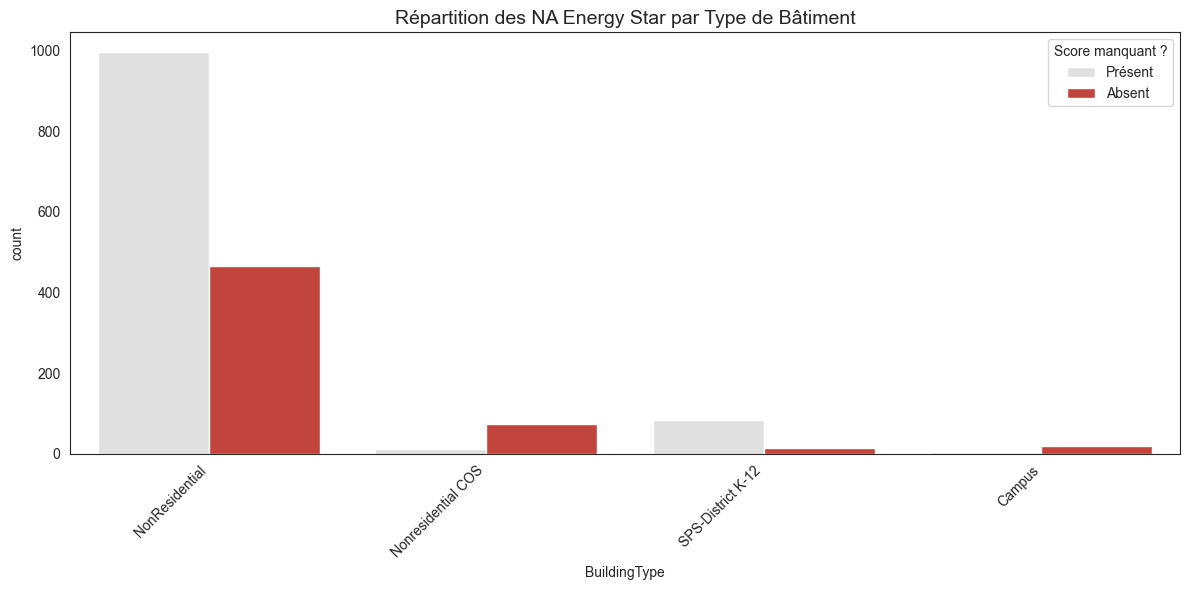

2026-01-05 11:30:40,220 - __main__ - INFO - Test du Chi² - p-value: 2.3107e-31


Résultat du test du Chi² : p-value = 2.3107e-31


In [44]:
# Préparation des données
df_raw['ENERGYSTARScore_is_missing'] = df_raw['ENERGYSTARScore'].isnull()

# Visualisation
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_raw, x='BuildingType', hue='ENERGYSTARScore_is_missing', palette=['#e0e0e0', '#d73027'])
plt.title('Répartition des NA Energy Star par Type de Bâtiment', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Score manquant ?', labels=['Présent', 'Absent'])
plt.tight_layout()
plt.savefig('../figures/notebook_1/03_energystar_missing_by_buildingtype.png')
plt.show()

# Test Statistique du Chi2
contingency_table = pd.crosstab(df_raw['BuildingType'], df_raw['ENERGYSTARScore_is_missing'])
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

logger.info(f"Test du Chi² - p-value: {p_val:.4e}")
print(f"Résultat du test du Chi² : p-value = {p_val:.4e}")

---

### Analyse de la répartition des manquants par Type de Bâtiment

L'histogramme souligne une hétérogénéité structurelle dans la disponibilité du ENERGYSTARScore. Alors que les bâtiments de type NonResidential affichent une présence massive de scores malgré un volume de manquants significatif, d'autres catégories comme Nonresidential COS ou Campus présentent un profil critique où les données absentes sont largement majoritaires par rapport aux données présentes. À l'opposé, les établissements de type SPS-District K-12 semblent bénéficier d'un suivi bien plus complet.

Le test du Chi2 indique une p-value de 6.38×10−31. Ce résultat rejette largement l'hypothèse d'indépendance et confirme que nous sommes face à un mécanisme de données manquantes MAR.l'absence du score n'est pas accidentelle mais directement conditionnée par la catégorie du bâtiment.


### Implications pour la stratégie de traitement

#### Rejet de la suppression pure et simple

Si nous avions supprimé toutes les lignes où le score est manquant (soit plus de 30% du dataset), nous n'aurions pas simplement perdu du volume de données, nous aurions introduit un biais de sélection. Comme l'absence est corrélée au BuildingType, supprimer ces lignes reviendrait à effacer presque intégralement certaines catégories (comme les Campus ou les Nonresidential COS) de notre analyse. Notre modèle final serait incapable de généraliser correctement pour ces types de bâtiments, car il n'aurait appris que sur les catégories "bons élèves" en matière de reporting.

#### Justification de l'imputation par groupe

Puisque la probabilité de NA dépend de variables observées (ici le type de bâtiment), nous pouvons compenser ces NA  en utilisant l'information contenue dans ces mêmes variables. Imputer par groupe permet de :

- Maintenir la variance inter-groupe : En utilisant la médiane spécifique à chaque catégorie, nous respectons les différences de performance énergétique inhérentes à chaque usage (un entrepôt n'a pas la même distribution de score qu'un bureau).

- Réduire l'erreur d'estimation : Une imputation globale (moyenne/médiane de tout le dataset) aurait "écrasé" les spécificités de chaque métier, créant des données synthétiques déconnectées de la réalité physique des bâtiments.

#### Choix de la Médiane vs Moyenne

Nous privilégions la médiane au sein de chaque groupe pour son caractère robuste. Le ENERGYSTARScore est une note de 1 à 100 qui ne suit pas forcément une loi normale au sein de chaque catégorie. La moyenne est vulnérable aux valeurs extrêmes (un bâtiment exceptionnellement performant ou médiocre) qui pourraient tirer la valeur imputée vers un niveau non représentatif du "bâtiment typique" du groupe. La médiane nous assure que la valeur de remplacement est la plus centrale et la plus probable.

#### Cas particuliers et limites

Il faut rester vigilant : bien que le test valide le mécanisme MAR par rapport au BuildingType, il se peut qu'au sein d'une même catégorie, l'absence soit liée à la performance elle-même (ex: un propriétaire ne déclare pas son score car il sait qu'il est mauvais). C'est le risque du Missing Not At Random. Pour limiter ce risque, nous pourrons, créer une variable binaire Has_EnergyStarScore qui permettra au modèle de capter si l'absence d'information est, en soi, un signal prédictif de la consommation.


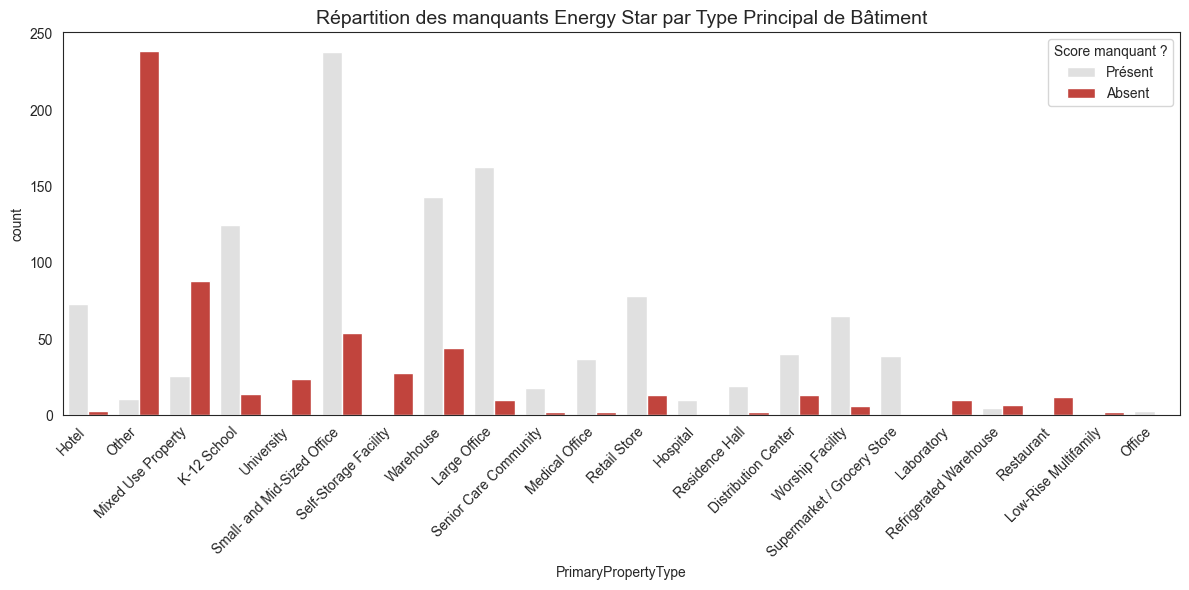

2026-01-05 11:30:55,136 - __main__ - INFO - Test du Chi² - p-value: 1.7978e-180


Résultat du test du Chi² : p-value = 1.7978e-180


In [45]:
df_raw['ENERGYSTARScore_is_missing'] = df_raw['ENERGYSTARScore'].isnull()

# Visualisation
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_raw, x='PrimaryPropertyType', hue='ENERGYSTARScore_is_missing', palette=['#e0e0e0', '#d73027'])
plt.title('Répartition des manquants Energy Star par Type Principal de Bâtiment', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Score manquant ?', labels=['Présent', 'Absent'])
plt.tight_layout()
plt.savefig('../figures/notebook_1/03_energystar_missing_by_primarypropertytype.png')
plt.show()

# Test Statistique du Chi2
contingency_table = pd.crosstab(df_raw['PrimaryPropertyType'], df_raw['ENERGYSTARScore_is_missing'])
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

logger.info(f"Test du Chi² - p-value: {p_val:.4e}")
print(f"Résultat du test du Chi² : p-value = {p_val:.4e}")


>L'analyse révèle que PrimaryPropertyType (usage principal >50% de la surface) explique mieux la répartition des manquants (p-value = 1.7978×10⁻¹⁸⁰) que BuildingType. Cette variable, permet une imputation par médiane plus précise et sectoriellement cohérente (ex : hôtels vs. bureaux). Nous abandonnons donc BuildingType au profit de cette approche, tout en conservant une variable flag Has_EnergyStarScore pour modéliser le signal des NaNs.

## Analyse des lignes avec taux élevé de NA

Après avoir diagnostiqué les variables, nous examinons si certains bâtiments présentent un déficit de données tel qu'ils pourraient nuire à la fiabilité de nos futurs modèles. Une ligne avec trop de valeurs manquantes est souvent le signe d'un défaut majeur lors de la déclaration

In [46]:
# Calcul du % de NA par ligne
row_missing_pct = df_raw.isnull().mean(axis=1) * 100

# Statistiques descriptives
print(" ANALYSE DES LIGNES PAR TAUX DE NA")
print("="*70)
print(f"Moyenne : {row_missing_pct.mean():.2f}%")
print(f"Médiane : {row_missing_pct.median():.2f}%")
print(f"Q1 (25%) : {row_missing_pct.quantile(0.25):.2f}%")
print(f"Q3 (75%) : {row_missing_pct.quantile(0.75):.2f}%")
print(f"Max : {row_missing_pct.max():.2f}%")
print()

# Comptage par seuil
thresholds = [10, 15, 20, 25,30,50]
for t in thresholds:
    n_above = (row_missing_pct > t).sum()
    pct_above = n_above / len(df_raw) * 100
    print(f"Lignes avec >{t}% NA : {n_above:,} ({pct_above:.2f}%)")

 ANALYSE DES LIGNES PAR TAUX DE NA
Moyenne : 12.48%
Médiane : 12.77%
Q1 (25%) : 10.64%
Q3 (75%) : 14.89%
Max : 53.19%

Lignes avec >10% NA : 1,283 (76.92%)
Lignes avec >15% NA : 221 (13.25%)
Lignes avec >20% NA : 4 (0.24%)
Lignes avec >25% NA : 2 (0.12%)
Lignes avec >30% NA : 2 (0.12%)
Lignes avec >50% NA : 2 (0.12%)


In [47]:
# Lignes avec entre 10% et 15% de NA
rows_between_10_15 = df_raw[(row_missing_pct >= 10) & (row_missing_pct <= 15)]

print(f"Lignes avec entre 10% et 15% de NA : {len(rows_between_10_15)}")
display(rows_between_10_15.sample(n=min(4, len(rows_between_10_15)), random_state=42))


Lignes avec entre 10% et 15% de NA : 1062


OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
57               77      2016  NonResidential                        Hotel   
895           20167      2016  NonResidential                  K-12 School   
1268          21397      2016  NonResidential                 Retail Store   
2896          27378      2016  NonResidential  Supermarket / Grocery Store   

                          PropertyName                      Address     City  \
57       Comfort Suites Seattle Center                   601 Roy St  Seattle   
895            Ninth & Lenora Building              2030 9th Avenue  Seattle   
1268  Guitar Center (Block 38W) - SEDO  520-530 Westlake Ave. North  Seattle   
2896      Safeway 1550 - Roosevelt Way        7300 Roosevelt Way NE  Seattle   

     State  ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
57      WA  98109.0                    2249000170                    7   
895     WA  98121.0                    0660001310                    7   
1268    WA  98109.0                    1983200180                    7   
2896    WA  98115.0                    6716700415                    4   

               Neighborhood  Latitude  Longitude  YearBuilt  \
57    MAGNOLIA / QUEEN ANNE  47.62519 -122.34456       1999   
895                DOWNTOWN  47.61718 -122.33654       1957   
1268             LAKE UNION  47.62399 -122.33804       1964   
2896              NORTHEAST  47.68217 -122.31675       1997   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
57                  1.0               4            122942               44891   
895                 1.0               2             21600                   0   
1268                1.0               2             45271                   0   
2896                1.0               1             76585               38585   

      PropertyGFABuilding(s)           ListOfAllPropertyUseTypes  \
57                     78051                      Hotel, Parking   
895                    21600                         K-12 School   
1268                   45271                        Retail Store   
2896                   38000  Parking, Supermarket/Grocery Store   

         LargestPropertyUseType  LargestPropertyUseTypeGFA  \
57                        Hotel                    78051.0   
895                 K-12 School                    21600.0   
1268               Retail Store                    45271.0   
2896  Supermarket/Grocery Store                    41447.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
57                        Parking                          44891.0   
895                           NaN                              NaN   
1268                          NaN                              NaN   
2896                      Parking                              0.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
57                           NaN                             NaN   
895                          NaN                             NaN   
1268                         NaN                             NaN   
2896                         NaN                             NaN   

     YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
57                        NaN             94.0         68.400002   
895                       NaN             72.0         58.400002   
1268                      NaN             57.0         56.400002   
2896                      NaN             18.0        335.500000   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
57             69.000000          136.699997            138.699997   
895            65.500000          120.300003            127.800003   
1268           64.300003          112.199997            119.099998   
2896          346.700012          761.299988            773.099976   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
57             53

In [50]:
rows_between_20_30 = df_raw[(row_missing_pct >= 20) & (row_missing_pct <= 30)]
print("Lignes avec entre 20% et 30% de NA :")
display(rows_between_20_30)
print('*'*150)
rows_above_30 = df_raw[row_missing_pct > 30]

display(rows_above_30)
print("Lignes avec plus de 30% de NA :")





Lignes avec entre 20% et 30% de NA :


OSEBuildingID  DataYear    BuildingType    PrimaryPropertyType  \
353             496      2016  NonResidential  Self-Storage Facility   
2459          25711      2016  NonResidential             Restaurant   

                          PropertyName                Address     City State  \
353                   Market St Center  2811 NW Market Street  Seattle    WA   
2459  BUSH GARDEN - RESTURANT & LOUNGE    614 S MAYNARD AVE S  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
353   98107.0                    1175001235                    6      BALLARD   
2459  98104.0                    5247802410                    2     DOWNTOWN   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
353   47.66838 -122.39310       1946                2.0               2   
2459  47.59697 -122.32474       1913                1.0               3   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
353             111445                   0                  111445   
2459             28800                   0                   28800   

                              ListOfAllPropertyUseTypes  \
353   Fitness Center/Health Club/Gym, Office, Other ...   
2459                                         Restaurant   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
353                     NaN                        NaN   
2459                    NaN                        NaN   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
353                           NaN                              NaN   
2459                          NaN                              NaN   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
353                          NaN                             NaN   
2459                         NaN                             NaN   

     YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
353                       NaN              NaN         47.799999   
2459                      NaN              NaN         31.200001   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
353                 51.0               103.0            106.400002   
2459                32.5                62.0             62.799999   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
353          5.697472e+06           6.076957e+06             0.0   
2459         8.999242e+05           9.358332e+05             0.0   

      Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
353        881452.0000          3007514.0        26899.582030   
2459       118085.2969           402907.0         4970.169922   

      NaturalGas(kBtu)  DefaultData  Comments ComplianceStatus Outlier  \
353          2689958.0        False       NaN        Compliant     NaN   
2459          497017.0        False       NaN        Compliant     NaN   

      TotalGHGEmissions  GHGEmissionsIntensity  ENERGYSTARScore_is_missing  
353              163.83                   1.47                        True  
2459              29.21                   1.01                        True

******************************************************************************************************************************************************


OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
578             773      2016  NonResidential  Small- and Mid-Sized Office   
2670          26532      2016  NonResidential           Mixed Use Property   

          PropertyName                 Address     City State  ZipCode  \
578   SEATTLE BUILDING         215 COLUMBIA ST  Seattle    WA  98104.0   
2670  KALBERG BUILDING  4515 UNIVERSITY WAY NE  Seattle    WA  98105.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
578                     0939000245                    7     DOWNTOWN   
2670                    8816401120                    4    NORTHEAST   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
578   47.60380 -122.33293       1924                NaN               4   
2670  47.66182 -122.31345       1928                NaN               2   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
578              63150                   0                   63150   
2670             20760                   0                   20760   

     ListOfAllPropertyUseTypes LargestPropertyUseType  \
578                        NaN                    NaN   
2670                       NaN                    NaN   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
578                         NaN                          NaN   
2670                        NaN                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
578                               NaN                         NaN   
2670                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  \
578                              NaN                      NaN   
2670                             NaN                      NaN   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
578               NaN               NaN                 NaN   
2670              NaN               NaN                 NaN   

      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
578                  NaN                   NaN                  NaN   
2670                 NaN                   NaN                  NaN   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
578                     NaN             NaN               NaN   
2670                    NaN             NaN               NaN   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
578                 NaN                 NaN               NaN        False   
2670                NaN                 NaN               NaN        False   

      Comments ComplianceStatus Outlier  TotalGHGEmissions  \
578        NaN    Non-Compliant     NaN                NaN   
2670       NaN    Non-Compliant     NaN                NaN   

      GHGEmissionsIntensity  ENERGYSTARScore_is_missing  
578                     NaN                        True  
2670                    NaN                        True

Lignes avec plus de 30% de NA :


### Décision finale sur le traitement des lignes selon le taux de valeurs manquantes

L’analyse du taux de valeurs manquantes par ligne montre que la grande majorité des observations présente un niveau d’information satisfaisant. La distribution est centrée autour de 12–13 %, avec un intervalle interquartile étroit, ce qui indique que le jeu de données est globalement homogène et exploitable. Les cas problématiques sont très peu nombreux et clairement identifiables.

Les lignes 2 dont le taux de valeurs manquantes dépasse 30 % correspondent à des bâtiments pour lesquels les variables centrales de l’analyse énergétique sont absentes : consommations, intensités énergétiques, émissions de gaz à effet de serre et informations sur les usages. Ces absences ne sont pas ponctuelles mais structurelles, ce qui rend toute tentative d’imputation non crédible d’un point de vue statistique et métier. Leur poids dans l’échantillon étant négligeable, leur suppression n’affecte ni la représentativité ni la puissance analytique du jeu de données.

Les 2 lignes dont le taux de NA est entre 20 et 30 % sont de statue Compliant et elles conservent une information substantiel,on a même les stats sur leurs émissions de co2.Par conséquent,on les conserve

À l’inverse, les lignes dont le taux de valeurs manquantes est inférieur ou égal à 20 % conservent une information substantielle. Les valeurs manquantes y sont dispersées et peuvent être traitées ultérieurement par des stratégies adaptées au type de variable.


| Taux de valeurs manquantes par ligne | Décision retenue | Justification |
|------------------------------------|-----------------|---------------|
| ≤ 20 % | Conservation | Information globalement suffisante ; valeurs manquantes traitables variable par variable sans biais majeur. |
| 20–30 % | Conservation des 2 lignes | Information globalement suffisante ; valeurs manquantes traitables variable par variable sans biais majeur.  |
| > 30 % | Suppression 2 lignes| Absence structurelle des variables énergétiques et d’émissions ; imputation non défendable et apport analytique nul. |


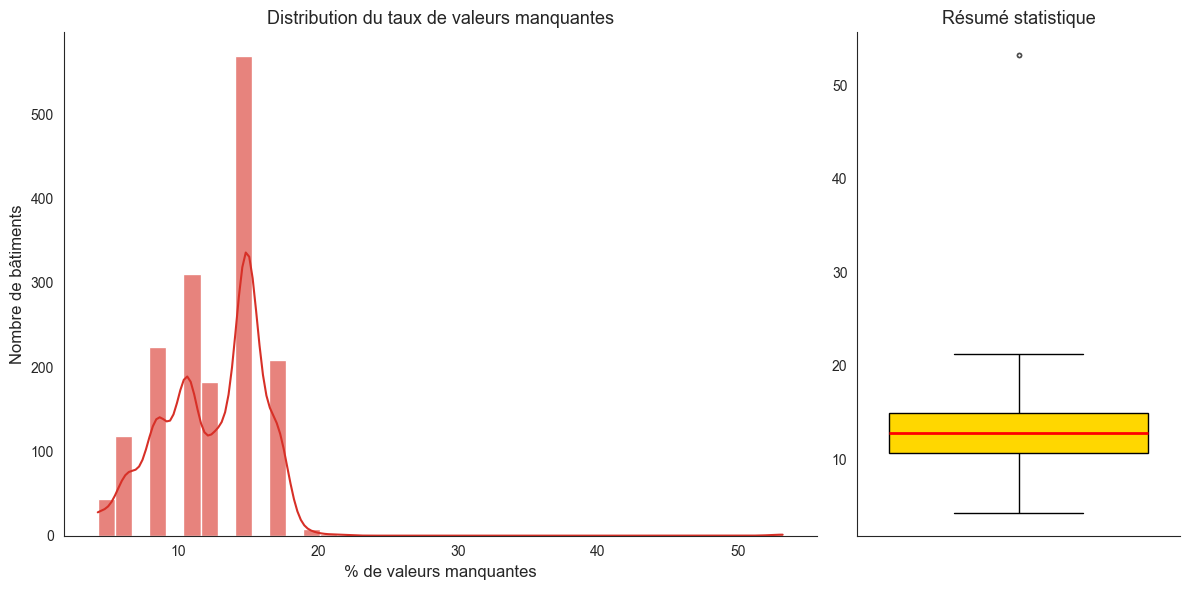

In [51]:
row_missing=row_missing_pct
# Visualisation de la distribution
# figure côte à côte
f, (ax_hist, ax_box) = plt.subplots(
    1, 2,
    figsize=(12, 6),
    gridspec_kw={"width_ratios": (0.7, 0.3)}  
)

# Histogramme à gauche
sns.histplot(row_missing, bins=40, kde=True, color='#d73027', ax=ax_hist, alpha=0.6)
ax_hist.set_xlabel('% de valeurs manquantes', fontsize=12)
ax_hist.set_ylabel('Nombre de bâtiments', fontsize=12)
ax_hist.set_title('Distribution du taux de valeurs manquantes', fontsize=13)

# Boxplot vertical à droite
sns.boxplot(
    y=row_missing, 
    ax=ax_box, 
    color='gold', 
    fliersize=3, 
    medianprops={'color':'red','linewidth':2},
    boxprops={'facecolor':'#FFD700','edgecolor':'black'},
    whiskerprops={'color':'black'},
    capprops={'color':'black'}
)
ax_box.set_title('Résumé statistique', fontsize=13)
ax_box.set(ylabel='')
ax_box.set_xticks([])

# Nettoyage des bordures
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box)

plt.tight_layout()
plt.savefig('../figures/notebook_1/04_data_row_distribution_NA.png', dpi=300, bbox_inches='tight')
plt.show()


La distribution du taux de valeurs manquantes par bâtiment montre une forte concentration autour de 10–15 %, avec la quasi‑totalité des bâtiments en dessous de 20 %.  

L’histogramme met en évidence une asymétrie vers la droite, traduisant l’existence d’un petit sous‑groupe de bâtiments avec des taux de valeurs manquantes nettement plus élevés. La longue traîne presque null indique que ces cas isolés sont responsables des lacunes les plus importantes.  

Le box‑plot illustre cette situation : une médiane basse, des quartiles resserrés et quelques outliers bien au‑delà du troisième quartile. Ces valeurs extrêmes correspondent surement aux bâtiments que nous avons décidé de supprimer, car leur taux de données manquantes dépasse les seuils retenus.

# Section 2 : Diagnostic de cohérence et erreurs physiques

Cette section identifie les données qui violent les lois de la physique ou les règles de calcul élémentaires. Ce sont des erreurs manifestes liées à la saisie, à la conversion ou au capteur.

*Objectifs*:

- Identifier les valeurs impossibles  
- Vérifier la cohérence entre les surfaces totales et les sous-surfaces  
- Valider la somme des sources énergétiques par rapport au total déclaré  

*Portée de l’analyse*:

Il existe de nombreuses façons de définir des règles de validation et il est impossible d’examiner toutes les variables une par une. Nous envisageons d’utiliser le package *Great Expectations* pour formaliser certains de ces règles de manière systématique.  
Dans cette section, nous faisons le choix de nous concentrer sur quelques aspects qui nous semblent les plus importants pour garantir la cohérence physique et la fiabilité des données.  

La section suivante sera consacrée aux valeurs extrêmes, dont l’analyse requiert, en plus du filtrage des valeurs manquantes, la prise en compte des incohérences identifiées ici.


## Validation des contraintes physiques
Certaines variables ne peuvent être strictement négatives ou nulles

In [19]:
# Variables devant être >= 0
positive_cols = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'Electricity(kBtu)', 'NaturalGas(kBtu)']
# Variables devant être > 0 (un bâtiment a forcément une surface)
strict_positive_cols = ['PropertyGFATotal']

# Diagnostic
neg_values = df_raw[(df_raw[positive_cols] < 0).any(axis=1)]
zero_surface = df_raw[df_raw['PropertyGFATotal'] <= 0]

print(f"🚩 Alertes physiques :")
print(f"- Bâtiments avec valeurs négatives : {len(neg_values)}")
print(f"- Bâtiments avec surface nulle ou négative : {len(zero_surface)}")

# Visualisation des erreurs critiques

display(neg_values[['OSEBuildingID', 'PropertyName'] + positive_cols])

🚩 Alertes physiques :
- Bâtiments avec valeurs négatives : 1
- Bâtiments avec surface nulle ou négative : 0


OSEBuildingID    PropertyName  SiteEnergyUse(kBtu)  TotalGHGEmissions  \
3206          49784  Bullitt Center          342726.0938               -0.8   

      Electricity(kBtu)  NaturalGas(kBtu)  
3206          -115417.0               0.0

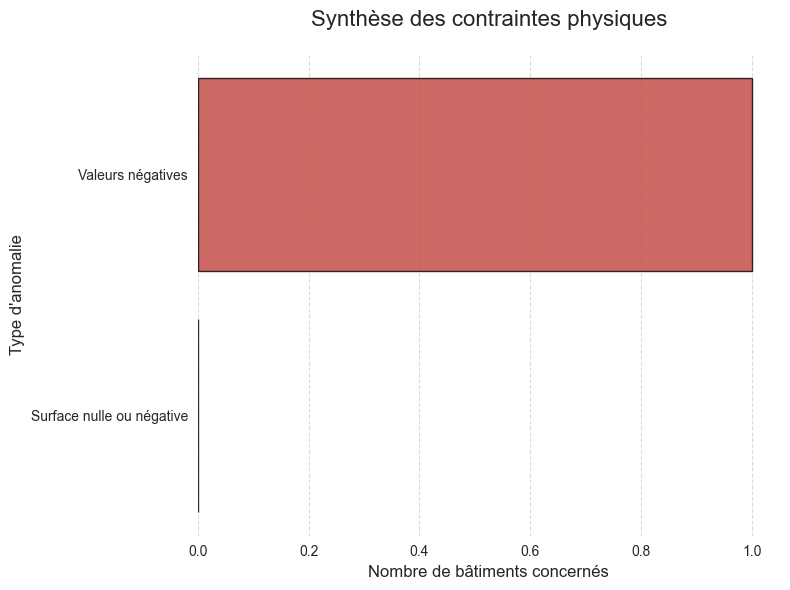

2026-01-04 21:13:46,489 - __main__ - INFO - Graphique des contraintes physiques : ../figures/notebook_1/05_data_physical_constraints.png


In [20]:
nb_neg = len(neg_values)
nb_zero_surface = len(zero_surface)

# Préparer les données sous forme de DataFrame
import pandas as pd
anomalies_df = pd.DataFrame({
    'Type': ['Valeurs négatives', 'Surface nulle ou négative'],
    'Nombre': [nb_neg, nb_zero_surface]
})

# Création du graphique
plt.figure(figsize=(8, 6))
sns.set_style("white")

barplot = sns.barplot(
    data=anomalies_df,
    x='Nombre',
    y='Type',
    color='#d73027',
    edgecolor='black',
    alpha=0.8
)

# Personnalisation
plt.title('Synthèse des contraintes physiques', fontsize=16, pad=20)
plt.xlabel('Nombre de bâtiments concernés', fontsize=12)
plt.ylabel('Type d\'anomalie', fontsize=12)

# Ajout d'une grille légère sur l'axe X uniquement
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

# Exportation du graphique
plt.tight_layout()
plt.savefig('../figures/notebook_1/05_data_physical_constraints.png', dpi=300, bbox_inches='tight')
plt.show()

logger.info("Graphique des contraintes physiques : ../figures/notebook_1/05_data_physical_constraints.png")


Lui,on le supprime directe

## Verification de la cohérence des conversions

In [61]:
elec_conv = df_raw['Electricity(kBtu)'] - (df_raw['Electricity(kWh)'] * 3.412)
gas_conv = df_raw['NaturalGas(kBtu)'] - (df_raw['NaturalGas(therms)'] * 100)
incoherent_elec = (abs(elec_conv) > 1).sum()
incoherent_gas = (abs(gas_conv) > 1).sum()
total_problemes = incoherent_elec + incoherent_gas
print("Électricité incohérente :", incoherent_elec)
print("Gaz incohérent :", incoherent_gas)
print("Total incohérences :", total_problemes)


Électricité incohérente : 0
Gaz incohérent : 0
Total incohérences : 0


## Vérification de la cohérence des surfaces
La surface totale (PropertyGFATotal) doit être cohérente avec la somme des parties (Building + Parking) et avec l'usage principal déclaré.

Incohérences structurelles :
- Somme (Building+Parking) != Total (>5% d'écart) : 0
- Bâtiments avec 0 étage : 16
- Usage principal > Surface totale (tolérance 5%) : 118
- Usage principal > Surface totale (strict) : 213


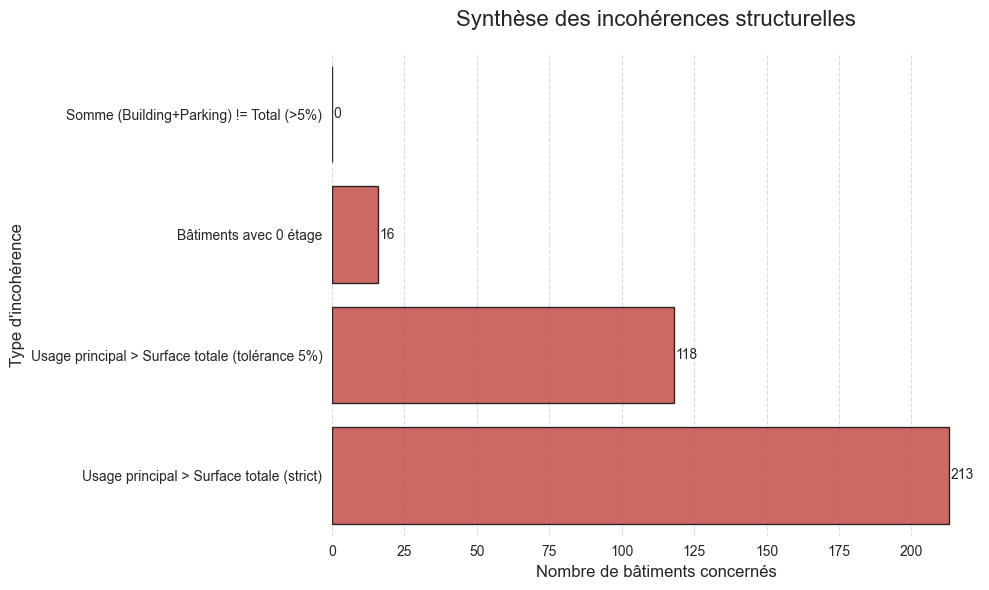

2026-01-04 21:13:48,701 - __main__ - INFO - Graphique des incohérences structurelles : ../figures/notebook_1/06_data_structural_constraints.png


In [21]:
# Vérification Somme des parties vs Total (tolérance 5%)
sum_gfa = df_raw['PropertyGFABuilding(s)'] + df_raw['PropertyGFAParking']
surface_gap_ratio = (sum_gfa - df_raw['PropertyGFATotal']).abs() / df_raw['PropertyGFATotal']
incoherent_surface = df_raw[surface_gap_ratio > 0.05]

# Nombre d'étages nul ou négatif
zero_floors = df_raw[df_raw['NumberofFloors'] <= 0]

# Usage principal plus grand que la surface totale (tolérance 5%)
usage_too_large = df_raw[df_raw['LargestPropertyUseTypeGFA'] > df_raw['PropertyGFATotal'] * 1.05]

# Usage principal strictement supérieur au total (sans tolérance)
usage_overflow = df_raw[df_raw['LargestPropertyUseTypeGFA'] > df_raw['PropertyGFATotal']]

# Résumé des incohérences
print("Incohérences structurelles :")
print(f"- Somme (Building+Parking) != Total (>5% d'écart) : {len(incoherent_surface)}")
print(f"- Bâtiments avec 0 étage : {len(zero_floors)}")
print(f"- Usage principal > Surface totale (tolérance 5%) : {len(usage_too_large)}")
print(f"- Usage principal > Surface totale (strict) : {len(usage_overflow)}")

#-------------------------------------------------------------------
# Synthèse des incohérences
anomalies_df = pd.DataFrame({
    'Type': [
        'Somme (Building+Parking) != Total (>5%)',
        'Bâtiments avec 0 étage',
        'Usage principal > Surface totale (tolérance 5%)',
        'Usage principal > Surface totale (strict)'
    ],
    'Nombre': [
        len(incoherent_surface),
        len(zero_floors),
        len(usage_too_large),
        len(usage_overflow)
    ]
})

# Création du graphique
plt.figure(figsize=(10,6))
sns.set_style("white")

barplot = sns.barplot(
    data=anomalies_df,
    x='Nombre',
    y='Type',
    color='#d73027',
    edgecolor='black',
    alpha=0.8
)

plt.title('Synthèse des incohérences structurelles', fontsize=16, pad=20)
plt.xlabel('Nombre de bâtiments concernés', fontsize=12)
plt.ylabel('Type d\'incohérence', fontsize=12)

# Annoter chaque barre avec la valeur
for i, v in enumerate(anomalies_df['Nombre']):
    plt.text(v + 0.5, i, str(v),va='center')

plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig('../figures/notebook_1/06_data_structural_constraints.png', dpi=300, bbox_inches='tight')
plt.show()

logger.info("Graphique des incohérences structurelles : ../figures/notebook_1/06_data_structural_constraints.png")


### Analyse des incohérences structurelles globales

Aucune anomalie n’est observée concernant la cohérence entre la surface totale et la somme des surfaces bâtiment et parking.

En revanche, deux types d’anomalies ressortent clairement. La plus fréquente concerne le fait que la surface associée à l’usage principal dépasse la surface totale déclarée du bâtiment. Cette incohérence touche un nombre non négligeable d’observations, et elle est encore plus marquée lorsque l’on considère le critère strict, sans tolérance. Cela révèle un problème structurel de déclaration ou d’agrégation des usages, et non de simples erreurs marginales dues à l’arrondi ou à des imprécisions mineures. Le fait que le nombre de cas augmente legerement lorsque la tolérance est supprimée indique que l’écart est souvent réel.

Les bâtiments déclarant zéro étage constituent un troisième type d’anomalie



---

### Inspection des anomalies : Cas des bâtiments avec 0 étage

In [22]:
# Cas des bâtiments avec 0 étage
inspect_zero = zero_floors[[
    "OSEBuildingID",
    "PropertyName",
    "BuildingType",
    "PrimaryPropertyType",
    "YearBuilt",
    "NumberofFloors",
    "PropertyGFATotal",           
    "PropertyGFABuilding(s)",     
    "PropertyGFAParking",         
    "LargestPropertyUseType",     
    "LargestPropertyUseTypeGFA",   
    "SecondLargestPropertyUseType",
    "SecondLargestPropertyUseTypeGFA",
    "Neighborhood",              
    "ZipCode",                    
    "ENERGYSTARScore",            
    "ComplianceStatus"             
]]

inspect_zero.sample(16, random_state=42)


OSEBuildingID                                       PropertyName  \
166             267                                Grand Hyatt Seattle   
487             656                                    Arnold Pavilion   
1993          24086  (ID#24086)Campus1:KC Metro Transit Atlantic Ce...   
3279          49980                                        Mercer Hall   
3278          49979                                        Lander Hall   
3274          49967          University of Washington - Seattle Campus   
3132          40034                                      Sandpoint #29   
3168          49705                                           Magnuson   
488             657                               2200 Westlake - SEDO   
3280          49983                                        Poplar Hall   
1754          23311                                HART First Hill LLC   
3131          40031                                      Sandpoint #25   
3273          49966             Smilow Rainier Vista Boys & Girls Club   
3276          49970                                         Cedar Hall   
564             758                                      Pacific Place   
3130          40028                                       Sandpoint #5   

            BuildingType          PrimaryPropertyType  YearBuilt  \
166       NonResidential                        Hotel       1999   
487       NonResidential               Medical Office       2004   
1993              Campus                        Other       1991   
3279      NonResidential               Residence Hall       1970   
3278      NonResidential               Residence Hall       1953   
3274              Campus                   University       1900   
3132      NonResidential  Small- and Mid-Sized Office       1960   
3168  Nonresidential COS                        Other       1929   
488       NonResidential           Mixed Use Property       2006   
3280      NonResidential               Residence Hall       2011   
1754      NonResidential               Medical Office       1945   
3131      NonResidential               Medical Office       1960   
3273      NonResidential                        Other       2009   
3276      NonResidential               Residence Hall       2011   
564       NonResidential                        Other       1999   
3130      NonResidential                    Warehouse       1940   

      NumberofFloors  PropertyGFATotal  PropertyGFABuilding(s)  \
166                0            934292                  934292   
487                0            225982                  225982   
1993               0            230971                  230971   
3279               0             89392                   89392   
3278               0            166991                  166991   
3274               0           9320156                 9320156   
3132               0             21931                   21931   
3168               0            502030                  502030   
488                0            516407                  516407   
3280               0             97040                   97040   
1754               0            274568                  274568   
3131               0             30287                   30287   
3273               0             40265                   40265   
3276               0            176225                  176225   
564                0            947987                  947987   
3130               0            384772                  384772   

      PropertyGFAParking      LargestPropertyUseType  \
166                    0                       Hotel   
487                    0              Medical Office   
1993                   0                       Other   
3279                   0    Residence Hall/Dormitory   
3278                   0    Residence Hall/Dormitory   
3274                   0          College/University   
3132                   0                      Office   
3168               

---
![Grand Hyatt Seattle](../figures/notebook_1/00_seatle_hyatt.png)  
---


### Inspection qualitative des bâtiments déclarant zéro étage

L’examen de quelques échantillions confirme l’existence d’une anomalie de renseignement systématique plutôt que d’une caractéristique de certains batiments. cette échantillon par exemple, se compose de batiments urbains majeurs dont logiquement on doit retrouver des etages. On y retrouve des structures massives comme le **Grand Hyatt Seattle** ou le centre commercial **Pacific Place**, qui dépassent chacun les 900 000 pieds carrés de surface. Le cas le plus emblématique reste celui du campus de l’**University of Washington** qui, avec ses 9 millions de pieds carrés, est enregistré avec zero étages. Cette déconnexion totale entre la volumétrie imposante et le nombre d'étages démontre que la variable NumberofFloors a été soit ignorée lors de la saisie, soit codée par défaut à zéro pour valider le formulaire de reporting.

La cohérence interne des surfaces renforce l’hypothèse d’une erreur de saisie ciblée. Pour l’intégralité de ces batiments, la surface totale correspond strictement à la surface bâtie `PropertyGFABuilding(s)`, sans aucune surface de parking déclarée pour compenser cette absence de hauteur. Pour des bâtiments médicaux comme l’**Arnold Pavilion** ou des résidences universitaires comme **Lander Hall**, le fonctionnement même de l’activité nécessite une distribution spatiale sur plusieurs niveaux. L’analyse temporelle montre que ces erreurs ne sont pas l’apanage de constructions anciennes : elles concernent des bâtiments érigés en 1900 comme en 2011, suggérant que le défaut de reporting est indépendant de l’âge du bâti ou de l’évolution des méthodes de métrage.

Sur le plan de la performance, ces bâtiments ne présentent aucun signal d’alerte énergétique particulier. Les scores ENERGY STAR, lorsqu’ils sont disponibles, se situent dans des plages de normalité statistique, allant de performances modestes (16 pour Mercer Hall) à d’excellents résultats comme pour le Cedar Hall (91). Le statut de conformité est systématiquement validé, ce qui indique que les autorités municipales ont accepté ces rapports malgré l’incohérence structurelle, probablement parce que les données de consommation et de surface totale étaient jugées fiables par ailleurs.

### Conclusion et stratégie de traitement
En conclusion, la valeur zéro pour le nombre d’étages doit être traitée comme une donnée manquante masquée.Nous recoderons ces valeurs en NaN pour éviter tout biais dans les modèles, tout en conservant ces observations dans le jeu de données, car leurs variables énergétiques et surfaces totales restent exploitables pour l’analyse



### Inspection des anomalies :Cas usage principal > surface totale (strict)

>Note : Techniquement la variable approprie pour le regroupement c'est PrimaryPropertyType mais nous l'avons sue tardivement. Mais nous la conserverons pour nos decisions finales

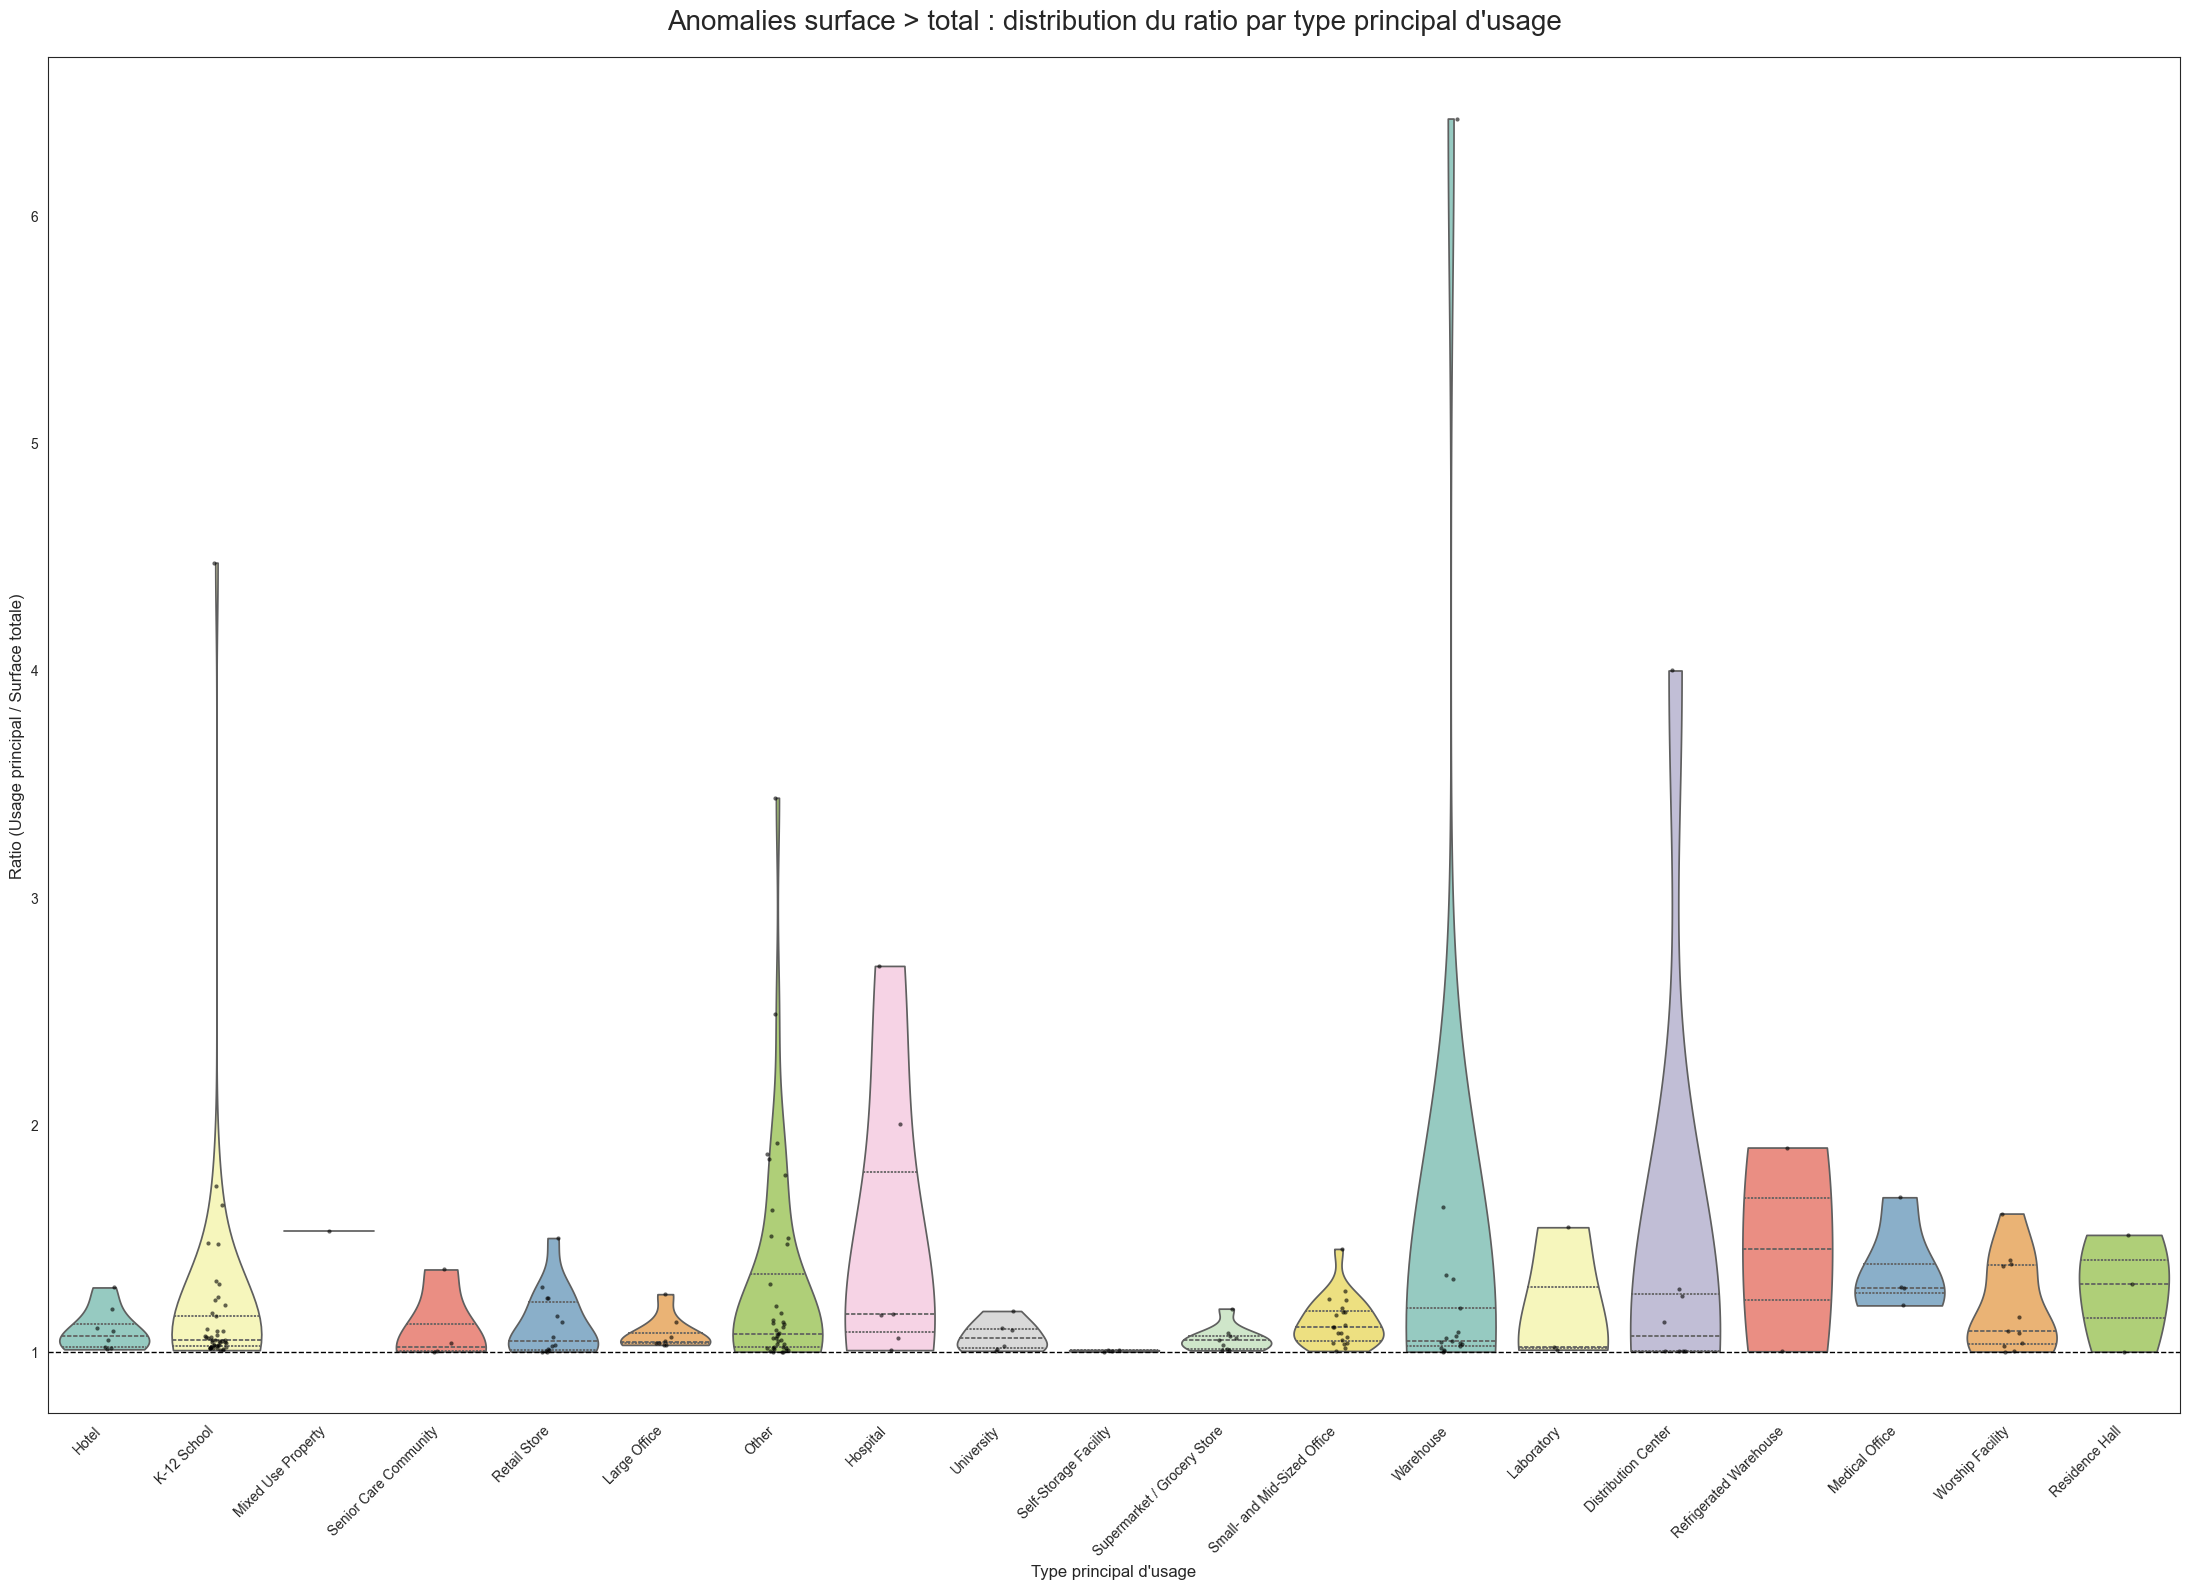

2026-01-04 21:13:56,179 - __main__ - INFO - Graphique et export réalisés : ../figures/notebook_1/07_anomalie_surface_total_violin_primarypropertytype.png et ../figures/notebook_1/anomalie_surface_total_cases_primarypropertytype.csv


In [23]:
# Créer une copie pour éviter SettingWithCopyWarning
usage_overflow = usage_overflow.copy()
usage_overflow.loc[:, "Ratio"] = usage_overflow["LargestPropertyUseTypeGFA"] / usage_overflow["PropertyGFATotal"]

# Sélection des types de bâtiments les plus fréquents (par PrimaryPropertyType)
n_types = usage_overflow["PrimaryPropertyType"].nunique()

# Sélection dynamique des types principaux
top_types = usage_overflow["PrimaryPropertyType"].value_counts().head(n_types).index
subset = usage_overflow[usage_overflow["PrimaryPropertyType"].isin(top_types)]

# Graphique violin + stripplot
plt.figure(figsize=(22, 16))
sns.violinplot(
    data=subset,
    x="PrimaryPropertyType",  # Changement ici
    y="Ratio",
    hue="PrimaryPropertyType",
    palette="Set3",
    inner="quartile",
    cut=0,
    legend=False
)
sns.stripplot(
    data=subset,
    x="PrimaryPropertyType",  # Changement ici
    y="Ratio",
    color="black",
    size=3,
    alpha=0.6
)

plt.axhline(1, color="black", linestyle="--", linewidth=1)
plt.title(f"Anomalies surface > total : distribution du ratio par type principal d'usage", fontsize=20, pad=20)  # Titre mis à jour
plt.xlabel("Type principal d'usage", fontsize=12)  
plt.ylabel("Ratio (Usage principal / Surface totale)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../figures/notebook_1/07_anomalie_surface_total_violin_primarypropertytype.png", dpi=450, bbox_inches='tight')  # Nom de fichier mis à jour
plt.show()

# Export des données
cols_export = [
    "OSEBuildingID", "PropertyName", "BuildingType", "PrimaryPropertyType",
    "LargestPropertyUseType", "LargestPropertyUseTypeGFA", "PropertyGFATotal",
    "Ratio", "PropertyGFABuilding(s)", "PropertyGFAParking",
    "NumberofBuildings", "NumberofFloors", "YearBuilt", "Neighborhood", "ComplianceStatus"
]
subset[cols_export].to_csv("../figures/notebook_1/anomalie_surface_total_cases_primarypropertytype.csv", index=False)  # Nom de fichier mis à jour

logger.info("Graphique et export réalisés : ../figures/notebook_1/07_anomalie_surface_total_violin_primarypropertytype.png et ../figures/notebook_1/anomalie_surface_total_cases_primarypropertytype.csv")




#### erreurs d'échelle 
Les catégories **Warehouse**, **K-12 School** et **Distribution Center** présentent les structures les plus atypiques : une base extrêmement compacte au niveau du ratio 1, surmontée d'une "tige" (neck)  s'étirant vers des valeurs aberrantes jusqu'à plus de 6.

Cette forme graphique indique que l'erreur n'est pas généralisée mais isolée et extrême.
La présence de points très dispersés dans la partie haute  suggère soit une confusion d'unités (ex: pieds carrés vs mètres carrés), soit une problématique de "Campus" où la surface d'usage englobe l'ensemble du site alors que la surface totale ne comptabilise que le bâti principal.

La catégorie Mixed Use Property présente un profil singulier sur le graphique avec un point isolé se situant nettement au-dessus du seuil de cohérence (ratio de 1.53)

#### La dérive structurelle

À l'opposé des profils précédents, certaines catégories comme **Hospital**, **Medical Office** ou **Worship Facility** montrent des violins dont le corps entier (les quartiles) décolle littéralement de la ligne de flottaison du ratio 1.

Pour les hôpitaux, le gonflement du violin se situe nettement plus haut, indiquant que la majorité des observations sont en situation de dépassement.
Ce signal graphique traduit surement  un conflit de définition systématique : les zones techniques complexes ou les circulations spécifiques semblent intégrées dans le calcul de la surface fonctionnelle (usage) mais exclues de la surface brute totale. L'anomalie est ici la norme.

#### Les actifs standardisés

Les actifs standardisés comme **Large Office**, **University**, **Hotel** ou **Self-Storage Facility** affichent des distributions très compactes et "écrasées" sur la ligne  du ratio 1.

La forte densité de points à la base et l'absence d'étalement vertical significatif prouvent une grande fiabilité des déclarations pour ces secteurs.
Les légers dépassements s'apparentent à un bruit de mesure classique, lié aux différences entre surface brute extérieure et surface nette intérieure, sans remettre en cause la logique physique du bâtiment.

#### L'hétérogénéité des catégories mixtes 

La catégorie **Other** présente un profil très étalé et asymétrique.le corps du violin est large et irrégulier, ce qui témoigne d'une population de bâtiments très hétérogènes. Cette forme indique que l'étiquette "Other" sert probablement de réceptacle à des structures hybrides où les règles de déclaration de surface ne sont pas uniformément comprises ou appliquées.


In [24]:
# Cas usage principal > surface totale (strict)
inspect_usage = usage_overflow[[
    "OSEBuildingID",                
    "PropertyName",
    "BuildingType", 
    "PrimaryPropertyType",        
    "LargestPropertyUseType",    
    "LargestPropertyUseTypeGFA",  
    "PropertyGFATotal",    
    "PropertyGFABuilding(s)", 
    "PropertyGFAParking",    
    "NumberofBuildings",    
    "NumberofFloors",      
    "YearBuilt", 
    "Neighborhood",
    "ComplianceStatus"
]]
inspect_usage.sample(13, random_state=221)


OSEBuildingID                       PropertyName       BuildingType  \
1349          21578            Genesee Hill Elementary  SPS-District K-12   
183             291       Thurgood Marshall Elementary  SPS-District K-12   
1691          23115               Intermountain Supply     NonResidential   
2894          27365                   Adams Elementary  SPS-District K-12   
3019          27891                      University VW     NonResidential   
3214          49858           The Northwest School 401     NonResidential   
2040          24225                               2900     NonResidential   
2710          26710                   Masin Building 1     NonResidential   
2119          24531  Kenyon Industrial Park Building D     NonResidential   
135             223      Westwood Village - Building A     NonResidential   
2723          26731                     Dearborn Bldg.     NonResidential   
2881          27303                            EMERSON     NonResidential   
637             866               Lafayette Elementary  SPS-District K-12   

              PrimaryPropertyType      LargestPropertyUseType  \
1349                  K-12 School                 K-12 School   
183                   K-12 School                 K-12 School   
1691          Distribution Center         Distribution Center   
2894                  K-12 School                 K-12 School   
3019                        Other            Other - Services   
3214                  K-12 School                 K-12 School   
2040          Distribution Center         Distribution Center   
2710  Small- and Mid-Sized Office                      Office   
2119                    Warehouse  Non-Refrigerated Warehouse   
135                  Retail Store                Retail Store   
2723  Small- and Mid-Sized Office                      Office   
2881                        Other                       Other   
637                   K-12 School                 K-12 School   

      LargestPropertyUseTypeGFA  PropertyGFATotal  PropertyGFABuilding(s)  \
1349                    60814.0             41221                   41221   
183                     65310.0             64414                   64414   
1691                    43050.0             42900                   42900   
2894                    60882.0             57298                   57298   
3019                    32580.0             21600                   21600   
3214                    38000.0             35780                   35780   
2040                    41430.0             41248                   41248   
2710                    44000.0             36879                   36879   
2119                    32040.0             32000                   32000   
135                     65425.0             64984                   64984   
2723                    30800.0             26510                   26510   
2881                    47661.0             47237                   47237   
637                     62975.0             61183                   61183   

      PropertyGFAParking  NumberofBuildings  NumberofFloors  YearBuilt  \
1349                   0                1.0               1       1949   
183                    0                1.0               2       1991   
1691                   0                1.0               1       1979   
2894                   0                1.0               2       1989   
3019                   0                1.0               2       1924   
3214                   0                1.0               2       2014   
2040                   0                1.0               1       1937   
2710                   0                1.0               5       1905   
2119                   0                1.0               1       1966   
135                    0                1.0               1       1966   
2723                   0                1.0               2       1970   
2881                   0                1.0      


L'examen de l'échantillon permet d'identifier un contributeur majeur à ces anomalies : le parc scolaire du SPS-District K-12. Des établissements comme **Genesee Hill Elementary** (ID 21578) ou **Lafayette Elementary** (ID 866) présentent des surfaces d'usage nettement supérieures à leur surface totale déclarée. Un indicateur important apparaît dans la colonne `ComplianceStatus` : ces lignes sont systématiquement marquées comme "**Error - Correct Default Data**" avec quelques exceptions certes. Cela confirme que ces dépassements ne sont pas des particularités architecturales, mais des erreurs de reporting reconnues par la ville de Seattle.

Pour les autres structures non résidentielles, telles que le **Masin Building 1** (ID 26710) ou le **Dearborn Bldg.** (ID 26731), les écarts sont plus modérés mais néanmoins problématiques pour la modélisation. Dans ces cas de bureaux ou de centres de distribution, l'absence de parking déclaré suggère que les gestionnaires ont pu inclure des zones de stockage extérieur dans l'usage principal sans les intégrer à la surface totale du bâtiment. Ces incohérences introduisent un biais direct dans le calcul de l'intensité énergétique : une surface d'usage surévaluée tend à diluer artificiellement la consommation au mètre carré.


In [25]:
# Statistiques descriptives sur les cas stricts
print("=== Synthèse des anomalies strictes ===")
print(f"Nombre total de cas : {len(subset)}")
print(f"Ratio moyen : {subset['Ratio'].mean():.2f}")
print(f"Ratio médian : {subset['Ratio'].median():.2f}")
print(f"Max ratio : {subset['Ratio'].max():.2f}")

# Comptage par statut de conformité
status_counts = subset['ComplianceStatus'].value_counts()
print("\nRépartition par ComplianceStatus :")
print(status_counts)

# Comptage par type de bâtiment
type_counts = subset['BuildingType'].value_counts()
print("\nRépartition par BuildingType :")
print(type_counts.head(10))  


=== Synthèse des anomalies strictes ===
Nombre total de cas : 213
Ratio moyen : 1.22
Ratio médian : 1.06
Max ratio : 6.43

Répartition par ComplianceStatus :
ComplianceStatus
Compliant                       180
Error - Correct Default Data     24
Missing Data                      7
Non-Compliant                     2
Name: count, dtype: int64

Répartition par BuildingType :
BuildingType
NonResidential        162
SPS-District K-12      32
Nonresidential COS     13
Campus                  5
Nonresidential WA       1
Name: count, dtype: int64


In [26]:
#segmente les ratios en différentes plages, puis croise ces anomalies avec les statuts de conformité pour obtenir les comptes et pourcentages
#exporte ensuite trois fichiers CSV et affiche en sortie les résultats globaux, par statut et par plage.

bins = [-np.inf, 1.0, 1.05, 1.30, np.inf]
labels = ["Ratio < 1.00", "1.00 ≤ Ratio ≤ 1.05", "1.05 < Ratio ≤ 1.30", "Ratio > 1.30"]

subset["ratio_bin"] = pd.cut(subset["Ratio"], bins=bins, labels=labels, right=True).astype(object)
subset.loc[subset["Ratio"].isna(), "ratio_bin"] = "Error/Missing"

order_cols = ["Error/Missing", "Ratio < 1.00", "1.00 ≤ Ratio ≤ 1.05", "1.05 < Ratio ≤ 1.30", "Ratio > 1.30"]
order_index = ["Compliant", "Error - Correct Default Data", "Missing Data", "Non-Compliant"]

pivot_counts = subset.pivot_table(
    index="ComplianceStatus",
    columns="ratio_bin",
    values="OSEBuildingID",
    aggfunc="count",
    fill_value=0
).reindex(index=order_index, columns=order_cols)

pivot_pct_by_status = (pivot_counts.T / pivot_counts.sum(axis=1)).T * 100
pivot_pct_global = (pivot_counts / len(subset)) * 100

pivot_counts.to_csv("../figures/notebook_1/anomalie_ratio_surface_totale_counts_par_statut.csv")
pivot_pct_by_status.round(2).to_csv("../figures/notebook_1/anomalie_ratio_surface_totale_pct_par_statut.csv")
pivot_pct_global.round(2).to_csv("../figures/notebook_1/anomalie_ratio_surface_totale_pct_global.csv")


print(pivot_counts.round(2))


ratio_bin                     Error/Missing  Ratio < 1.00  \
ComplianceStatus                                            
Compliant                               NaN           NaN   
Error - Correct Default Data            NaN           NaN   
Missing Data                            NaN           NaN   
Non-Compliant                           NaN           NaN   

ratio_bin                     1.00 ≤ Ratio ≤ 1.05  1.05 < Ratio ≤ 1.30  \
ComplianceStatus                                                         
Compliant                                      76                   72   
Error - Correct Default Data                   14                    7   
Missing Data                                    4                    3   
Non-Compliant                                   1                    1   

ratio_bin                     Ratio > 1.30  
ComplianceStatus                            
Compliant                               32  
Error - Correct Default Data             3  
Missing 

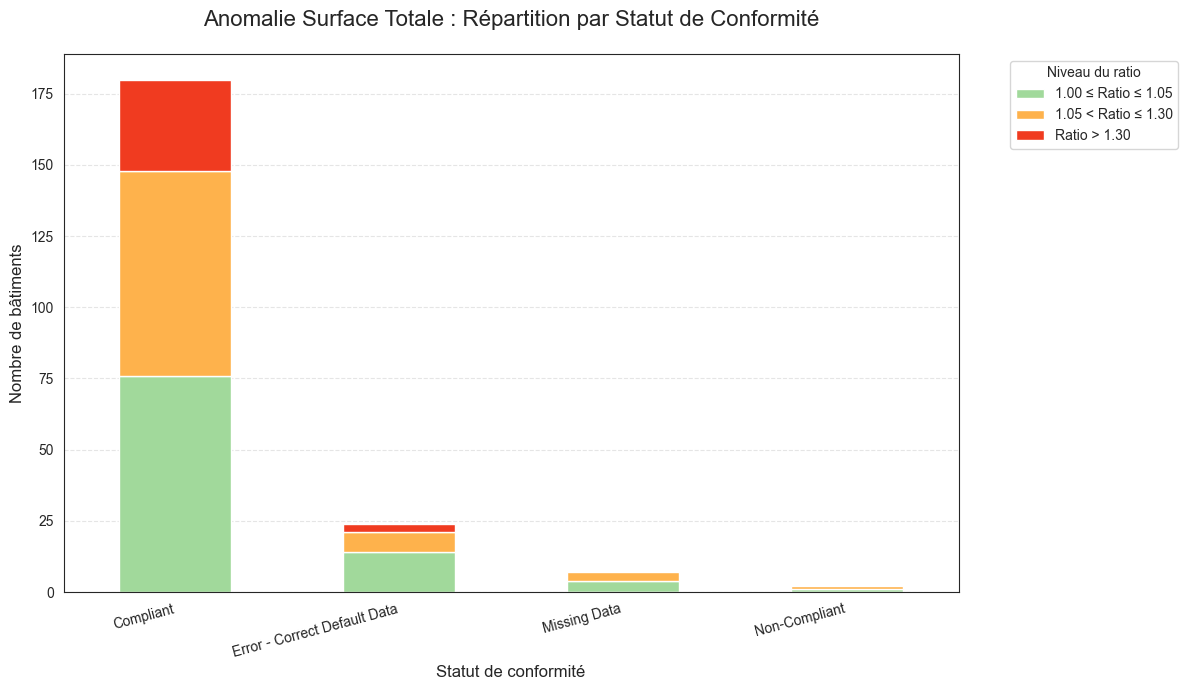

In [27]:
plot_data = pivot_counts[["1.00 ≤ Ratio ≤ 1.05", "1.05 < Ratio ≤ 1.30", "Ratio > 1.30"]]

couleurs = ['#a1d99b', '#feb24c', '#f03b20']

ax = plot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    color=couleurs,
    edgecolor='white'
)

plt.title("Anomalie Surface Totale : Répartition par Statut de Conformité", fontsize=16, pad=20)
plt.xlabel("Statut de conformité", fontsize=12)
plt.ylabel("Nombre de bâtiments", fontsize=12)
plt.xticks(rotation=15, ha="right")
plt.legend(title="Niveau du ratio", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.savefig("../figures/notebook_1/anomalie_surface_totale_bar_compliance.png", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


### Conclusion

L’analyse quantitative montre que sur l’ensemble des anomalies de ratio surface > totale :  
- Compliant concentre 180 cas (76 mineurs, 72 intermédiaires, 32 critiques), soit 85 % du total.  
- Error – Correct Default Data représente 24 cas (14 mineurs, 7 intermédiaires, 3 critiques).  
- Missing Data compte 7 cas (4 mineurs, 3 intermédiaires).  
- Non-Compliant n’affiche que 2 cas (1 mineur, 1 intermédiaire).  

Ces résultats confirment que la majorité des anomalies se trouvent chez les bâtiments déclarés conformes, ce qui traduit une imprécision généralisée dans la définition des surfaces. La présence d’erreurs critiques (> 1.30) chez les grands ensembles et acteurs publics (SPS-District) souligne une rupture de fiabilité pour les plus gros émetteurs potentiels.conserver ces ratios erronés reviendrait à sous-estimer systématiquement l’intensité énergétique réelle de ces bâtiments.

---

### Tableau de recommandations

| Profil de l’anomalie | Décision immédiate | Justification méthodologique |
|-----------------------|--------------------|------------------------------|
| Statut : Error – Correct Default Data, Missing Data, Non-Compliant | Suppression | Données explicitement invalidées ou incomplètes. Fiabilité nulle pour la prédiction. |
| Ratio > 1.30 (35 cas, dont 32 Compliant) | Suppression | Dépassement de 30 % jugé physiquement impossible ou erreur de saisie majeure. |
| Ratio entre 1.00 et 1.05 (95 cas, dont 76 Compliant) | Conservation | Transféré à la sous-section suivante pour inspection de la tolérance. |
| Ratio entre 1.05 et 1.30 (83 cas, dont 72 Compliant) | Conservation | Transféré à la sous-section suivante pour arbitrage qualitatif. |


### Inspection des anomalies : Usage principal > surface totale (tolérance et arbitrage)

Suite au premier filtrage, nous avons écarté les erreurs manifestes (données invalidées et ratios > 1.30). Cette étape se concentre sur les 178 bâtiments résiduels dont la surface déclarée par usage excède la surface totale de 0 % à 30 %. L'enjeu est de distinguer les erreurs de saisie bénignes des incohérences structurelles.


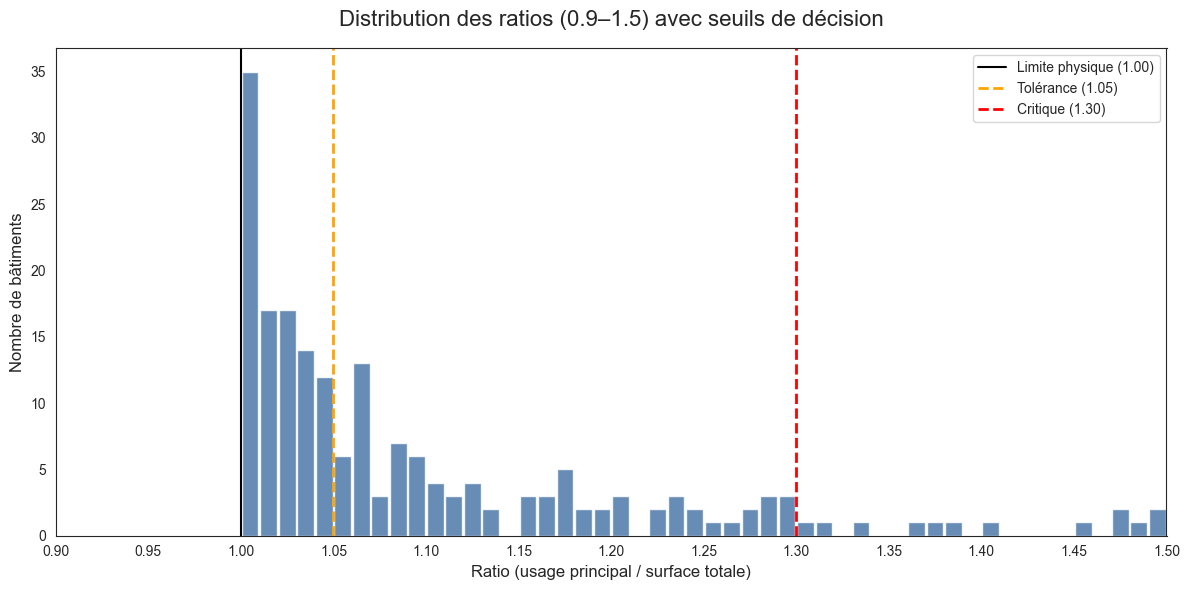

In [28]:

# Paramètres
bin_width = 0.01  # largeur des barres (plus petit = plus fin)
bins = np.arange(0.9, 1.5 + bin_width, bin_width)

# Histogramme uniforme
counts, edges = np.histogram(subset["Ratio"].dropna(), bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

plt.figure(figsize=(12, 6))
plt.bar(centers, counts, width=bin_width*0.9, color="#4c78a8", edgecolor="white", alpha=0.85)

# Lignes de seuils
plt.axvline(1.00, color="black", linestyle="-", linewidth=1.5, label="Limite physique (1.00)")
plt.axvline(1.05, color="orange", linestyle="--", linewidth=2, label="Tolérance (1.05)")
plt.axvline(1.30, color="red", linestyle="--", linewidth=2, label="Critique (1.30)")

# Mise en forme
plt.xlim(0.9, 1.5)
plt.xticks(np.arange(0.9, 1.51, 0.05))  # ticks réguliers tous les 0.05
plt.xlabel("Ratio (usage principal / surface totale)", fontsize=12)
plt.ylabel("Nombre de bâtiments", fontsize=12)
plt.title("Distribution des ratios (0.9–1.5) avec seuils de décision", fontsize=16, pad=16)
plt.legend(frameon=True, facecolor="white")

plt.tight_layout()
plt.savefig("../figures/notebook_1/anomalie_surface_totale_distribution_uniforme.png", dpi=300, bbox_inches="tight")
plt.show()


### Analyse du graphique de distribution

Le graphique confirme visuellement la pertinence de la segmentation choisie :

* **La zone de "Tolérance" (1.00 - 1.05)** : On observe une concentration massive de bâtiments juste après la limite physique de 1.00. Cette forte densité suggère une erreur systématique légère (murs extérieurs, zones communes) plutôt qu'une erreur de saisie aléatoire.
* **La zone d'Arbitrage" (1.05 - 1.30)** : La distribution s'étire en longue traîne. Le nombre de bâtiments diminue drastiquement, mais reste non négligeable.




L'analyse de la distribution des ratios permet de définir une stratégie de nettoyage rigoureuse pour les 178 bâtiments restants. L'enjeu central est de protéger la fiabilité de l'indicateur **Energy Use Intensity (EUI)**. Le nettoyage des ratios vise à protéger la fiabilité de l’EUI, car celui‑ci conditionne directement la justesse des émissions de CO2 calculées et donc la qualité des modèles de prédiction.

#### 1. Zone de Tolérance Technique (Ratio entre 1.00 et 1.05)

Pour les **95 bâtiments** dont le dépassement est inférieur à 5 %, l'anomalie est requalifiée en "Incertitude de Mesure". Nous partons de l'hypothèse que ces écarts mineurs résultent de divergences méthodologiques, comme l'inclusion des murs extérieurs ou des cages d'escalier dans le calcul de l'EPA Portfolio Manager par rapport aux registres fonciers. La décision est de **maintenir l'intégralité de ces données**. L'impact sur le calcul de l'intensité énergétique est jugé statistiquement négligeable, la marge d'erreur étant trop faible pour biaiser les futurs modèles de prédiction.

#### 2. Arbitrage des Ratios Intermédiaires (Ratio entre 1.05 et 1.30)

Le traitement des **83 cas intermédiaires** repose sur une distinction stricte entre la complexité du bâtiment et sa performance statistique. Pour les **bâtiments complexes ou multi-usages** (ex: hôpitaux, centres communautaires ou campus avec `NumberofBuildings` > 1), le dépassement est souvent structurel. Ces lignes sont **conservées** à condition que leur Energy Use Intensity reste cohérent avec la médiane de leur catégorie d'usage via l'intervalle interquartille.

En revanche, la règle est différente pour les **bâtiments monostructurels** (ex: entrepôts, bureaux simples, parkings isolés) présentant un ratio compris entre 1.05 et 1.25. Pour ces structures simples, un tel écart ne peut être justifié par un chevauchement technique d'usages. En conséquence, **tout bâtiment simple dépassant le ratio de 1.05 est systématiquement exclu**. Conserver un bâtiment monostructurel avec un ratio de 1.20 reviendrait à accepter une erreur de 20 % sur la variable cible, ce qui créerait des "leaders énergétiques" fictifs dans notre échantillon.

#### 3. Zone d'Exclusion Critique (Ratio supérieur à 1.30)

Pour les **35 cas** où le ratio excède 1.30, l'incohérence physique est jugée irrémédiable. Ces valeurs, isolées à l'extrême droite de l'histogramme, traduisent une rupture totale de fiabilité dans la déclaration des surfaces. La décision est une **suppression définitive** de ces enregistrements, quel que soit le type de bâtiment ou son statut de conformité.

---

### Synthèse 

Le tableau suivant récapitule les décisions finales appliquées au jeu de données avant modélisation :

| Plage de Ratio | Type de Bâtiment | Action Corrective | Impact sur l'EUI |
| --- | --- | --- | --- |
| **1.00 < R ≤ 1.05** | Tous types | **Maintien** | Biais négligeable (< 5%) |
| **1.05 < R ≤ 1.30** | Multi-usages / Campus | **Conservation sélective** | Validation par la médiane |
| **1.05 < R ≤ 1.30** | Monostructurel | **Exclusion** | Risque de sous-estimation majeure |
| **R > 1.30** | Tous types | **Exclusion** | Erreur physique manifeste |

Cette méthodologie garantit que le modèle d'apprentissage ne sera pas pollué par des données dont la surface "gonflée" masquerait une inefficacité énergétique réelle.




### Note sur Portfolio Manager de l’EPA 

Le problème des anomalies de ratio provient essentiellement d’un décalage méthodologique entre les conventions de calcul du **Portfolio Manager de l’EPA** et celles utilisées par la ville de **Seattle**. Les gestionnaires de bâtiments saisissent leurs données dans Portfolio Manager, qui applique des règles standardisées à l’échelle nationale : certaines surfaces sont incluses (espaces chauffés, zones communes), tandis que d’autres peuvent être exclues (parkings ouverts, sous-sols non climatisés). L’objectif est de garantir la comparabilité des bâtiments sur tout le territoire américain.  

En revanche, Seattle impose un **reporting obligatoire** via son programme de benchmarking énergétique. Les propriétaires de bâtiments de plus de 20 000 pieds carrés doivent transmettre leurs données de surface totale et par usage à la ville, en utilisant Portfolio Manager, mais Seattle peut croiser ces saisies avec ses propres relevés municipaux ou cadastraux, souvent plus exhaustifs.  

Cette différence de conventions conduit à des situations où la surface déclarée pour l’usage principal dépasse la surface totale, générant des ratios supérieurs à 1. Autrement dit, il ne s’agit pas toujours d’erreurs de saisie, mais parfois d’écarts liés à la normalisation fédérale face aux pratiques locales. C’est pourquoi ces cas doivent être requalifiés en **incertitudes de mesure** plutôt qu’en incohérences systématiques.  

---

### Sources
- [EPA – Benchmarking and Building Performance Standards Toolkit](https://www.epa.gov/sites/production/files/2021-02/documents/benchmarking_building_performance_standards_section1.pdf) : conventions de calcul et objectifs de comparabilité nationale.  
- [Seattle Benchmarking Instructions](https://www.seattle.gov/environment/climate-change/buildings-and-energy/energy-benchmarking/instructions) : obligations de reporting via Portfolio Manager pour les bâtiments > 20 000 sf.  
- [Seattle Energy Benchmarking Overview](https://www.seattle.gov/environment/climate-change/buildings-and-energy/energy-benchmarking) : publication annuelle des données et croisement avec relevés municipaux.  


## Vérification de la cohérence énergétique

pour chaque bâtiment :
- La consommation totale d’énergie sur site (`SiteEnergyUse(kBtu)`), censée représenter la somme de toutes les sources d’énergie converties en kBtu.
- Les consommations détaillées par source (`Electricity(kBtu)`, `NaturalGas(kBtu)`, `SteamUse(kBtu)`).

En théorie, la somme des consommations par source doit être cohérente avec le total déclaré.  
Toute incohérence significative peut révéler :
- Des erreurs de saisie ou de conversion d’unités.  
- Des données par défaut ou imputées.  
- Des omissions dans le reporting 




> Le CO2 est une variable calculée par la ville de Seattle en appliquant des facteurs d'émission spécifiques à chaque source d'énergie (Électricité, Gaz, Vapeur). Si la somme de ces sources ne correspond pas au total déclaré (SiteEnergyUse), la valeur du CO2 est mathématiquement corrompue.

### Formulation mathématique

Pour chaque bâtiment, on calcule l’écart relatif entre la somme des sources d’énergie et le total déclaré :

- Somme des sources :
$$
S = \text{Electricity(kBtu)} + \text{NaturalGas(kBtu)} + \text{SteamUse(kBtu)}
$$

- Total déclaré :
$$
T = \text{SiteEnergyUse(kBtu)}
$$

- Écart relatif :
$$
\text{energy\_gap} = \frac{|S - T|}{T}
$$


Les bâtiments dont l’écart relatif dépasse **5 %** sont automatiquement extraits dans le DataFrame `incoherent_energy`,  
ce qui permet de les isoler pour une analyse ciblée des incohérences énergétiques.

Cet indicateur mesure la proportion de différence entre les deux valeurs.  
En fonction de son amplitude, on classe les bâtiments en segments d’écart (0%, 0–5%, 5–10%, >10%).
---

In [29]:
# Liste des sources converties en kBtu
sources_kbtu = ['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']
total_sum_sources = df_raw[sources_kbtu].fillna(0).sum(axis=1)

# Calcul de l'écart
energy_gap = (total_sum_sources - df_raw['SiteEnergyUse(kBtu)']).abs() / df_raw['SiteEnergyUse(kBtu)']
incoherent_energy = df_raw[energy_gap > 0.05] # Seuil de 5% d'écart

# Identification des segments d'erreur
print(f"🚩 Analyse des écarts (Somme des sources vs Total déclaré) :")
print(f"- Écart strict (0%)      : {len(df_raw[energy_gap == 0])} bâtiments")
print(f"- Écart mineur (0-5%)    : {len(df_raw[(energy_gap > 0) & (energy_gap <= 0.05)])} bâtiments")
print(f"- Écart modéré (5-10%)   : {len(df_raw[(energy_gap > 0.05) & (energy_gap <= 0.10)])} bâtiments")
print(f"- Écart majeur (>10%)    : {len(df_raw[energy_gap > 0.10])} bâtiments")

🚩 Analyse des écarts (Somme des sources vs Total déclaré) :
- Écart strict (0%)      : 253 bâtiments
- Écart mineur (0-5%)    : 1378 bâtiments
- Écart modéré (5-10%)   : 2 bâtiments
- Écart majeur (>10%)    : 28 bâtiments


### Interprétation des résultats

L’analyse des écarts entre la somme des sources d’énergie et le total déclaré montre une distribution très contrastée :

- **522 bâtiments** présentent une cohérence parfaite : la somme des sources correspond exactement au total déclaré.  
- **2795 bâtiments (0–5%)** affichent de légers écarts, probablement dus à des arrondis ou des conversions d’unités. Ces cas sont considérés comme robustes et reflètent le bruit naturel des données réelles.  
- **2 bâtiments (5–10%)** dépassent le seuil de tolérance fixé à **5 %**, mais restent en dessous de 10 %. Ces écarts sont rares et peuvent être conservés avec vigilance, car ils n’affectent pas significativement la qualité globale du dataset.  
- **45 bâtiments (>10%)** présentent des incohérences majeures. L’écart est trop important pour être attribué à des erreurs d’arrondi. Ces cas traduisent probablement des omissions de sources d’énergie ou des erreurs de saisie et doivent être exclus pour préserver la cohérence physique entre énergie et émissions de CO₂.

---

### Conclusion
La majorité des bâtiments (≈ 90%) sont cohérents ou présentent des écarts mineurs inférieurs au seuil de **5 %**, ce qui valide la robustesse du dataset.  
Le seuil de 5 % permet de distinguer les écarts acceptables des incohérences critiques.  
En pratique, on conserve les segments **0–10%** pour garantir la diversité et la représentativité, et on supprime les **45 bâtiments incohérents (>10%)** afin de fiabiliser l’analyse énergétique et environnementale.

### Justification des seuils et plan d'action

À partir de cette distribution, il est nécessaire de définir une stratégie de traitement des données.  
Le seuil de **5 %** sert de repère pour distinguer les écarts mineurs (bruit acceptable) des incohérences plus sérieuses.  
Ainsi, nous proposons une classification en trois segments, chacun associé à un statut et à une action spécifique :

| Segment d'écart | Statut              | Justification & Action |
|-----------------|---------------------|-------------------------|
| **0% à 5%**    | Conserver           | **Robustesse.** Ces écarts sont considérés comme des erreurs d’arrondi lors des conversions d’unités (ex : kWh vers kBtu). Ils reflètent le "bruit" naturel de données réelles. |
| **5% à 10%**  2 batiments  | Conserver (Vigilance) | **Réalisme.** Ces écarts restent acceptables pour un modèle de prédiction. Supprimer ces données réduirait la diversité de l’échantillon sans gain majeur de précision. Nous les gardons pour assurer la capacité du modèle à généraliser sur des données imparfaites. |
| **Supérieur à 10%** | Supprimer        | **Incohérence physique.** Avec 45 bâtiments dans ce cas, l’écart est trop grand pour être une erreur d’arrondi. Cela indique une source d’énergie non déclarée ou une erreur de saisie massive. Ces lignes faussent le lien logique entre Énergie et CO₂. |


#### Visualisation finale du "Gap" énergétique

Le graphique ci-dessous met en évidence la concentration des erreurs majeures. On remarque que les très grands bâtiments (Surface GFA élevée) sont globalement plus cohérents, tandis que les anomalies se concentrent sur les structures plus petites.

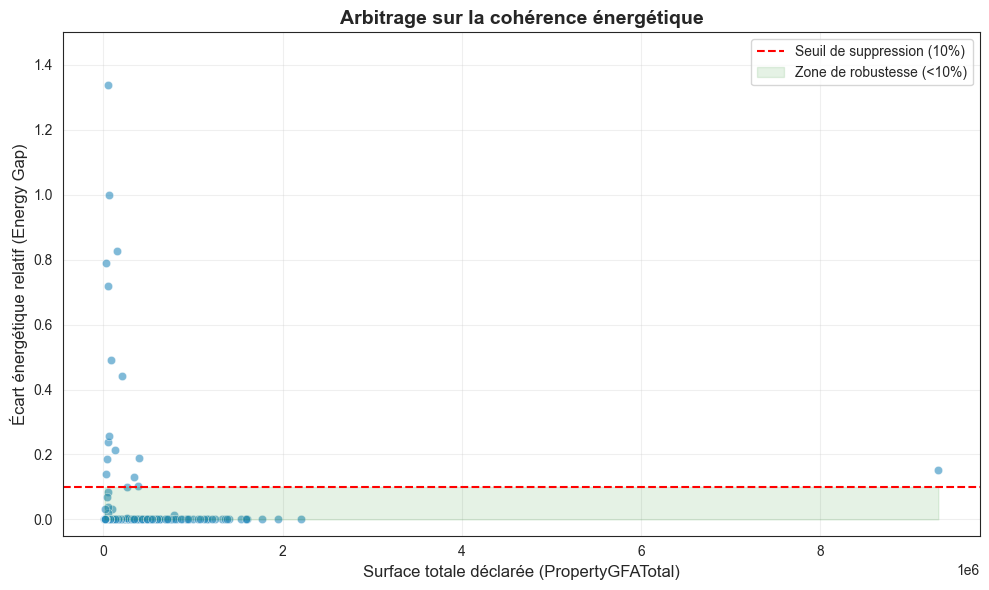

In [30]:
# Visualisation avec zones de décision
plt.figure(figsize=(10,6))

sns.scatterplot(
    x=df_raw['PropertyGFATotal'], 
    y=energy_gap, 
    alpha=0.6, 
    color="#2b8cbe",
    edgecolor="white"
)

# Ligne seuil
plt.axhline(0.10, color='red', linestyle='--', linewidth=1.5, label='Seuil de suppression (10%)')

# Zone de robustesse
plt.fill_between(
    df_raw['PropertyGFATotal'].sort_values(), 
    0, 0.10, 
    color='green', alpha=0.1, 
    label='Zone de robustesse (<10%)'
)

# Mise en forme
plt.title("Arbitrage sur la cohérence énergétique", fontsize=14, fontweight='bold')
plt.xlabel("Surface totale déclarée (PropertyGFATotal)", fontsize=12)
plt.ylabel("Écart énergétique relatif (Energy Gap)", fontsize=12)
plt.ylim(-0.05, 1.5)
plt.legend(frameon=True)
plt.grid(alpha=0.3)

# Export en PNG
plt.tight_layout()
plt.savefig("../figures/notebook_1/coherence_energetique.png", dpi=300, bbox_inches="tight")
plt.show()


>Une question légitime serait de recalculer SiteEnergyUse en faisant nous-mêmes la somme. Décision : Nous refusons cette approche. Justification : Si le total déclaré est faux, nous n'avons aucune garantie que ce sont les sources qui sont justes. Modifier la donnée introduirait un biais arbitraire. La suppression est la seule voie garantissant l'intégrité scientifique du modèle.

## Validation de la cohérence temporelle

L'année de construction est un prédicteur majeur du CO2. Seattle ayant été intégrée en 1869, toute date très antérieure ou située dans le futur est une erreur.

In [31]:
# Bornes : 1900  à 2016 (source :dictionnaire des données)

invalid_years = df_raw[(df_raw['YearBuilt'] < 1900) | (df_raw['YearBuilt'] > 2015)]

print(f"🚩 Bâtiments avec année de construction incohérente (<1900 ou >2016) : {len(invalid_years)}")


🚩 Bâtiments avec année de construction incohérente (<1900 ou >2016) : 0


## Vérification de la cohérence geographique

In [32]:


# GeoDataFrame points
gdf = gpd.GeoDataFrame(
    df_raw,
    geometry=gpd.points_from_xy(df_raw["Longitude"], df_raw["Latitude"]),
    crs="EPSG:4326"
)

# Contour Seattle (Census TIGER)
url = "https://www2.census.gov/geo/tiger/TIGER2023/PLACE/tl_2023_53_place.zip"
places = gpd.read_file(url).to_crs("EPSG:4326")
seattle = places[places["NAME"] == "Seattle"]

# Union géométrique
seattle_geom = seattle.geometry.union_all()

# Test cohérence géographique
gdf["in_seattle"] = gdf.intersects(seattle_geom)

# Comptes
n_in = gdf["in_seattle"].sum()
n_out = (~gdf["in_seattle"]).sum()

# Préparation Plotly
gdf_plot = gdf.copy()
gdf_plot["Statut"] = gdf_plot["in_seattle"].map({
    True: f"Dans Seattle (n={n_in})",
    False: f"Hors Seattle (n={n_out})"
})

# Conversion GeoJSON pour le contour
seattle_geojson = json.loads(seattle.to_json())

# Carte interactive
fig = px.scatter_map(
    gdf_plot,
    lat=gdf_plot.geometry.y,
    lon=gdf_plot.geometry.x,
    color="Statut",
    zoom=10,
    height=750,
    map_style="satellite",
    color_discrete_map={
        f"Dans Seattle (n={n_in})": "#2b8cbe",
        f"Hors Seattle (n={n_out})": "#de2d26"
    },
    title="Vérification de la cohérence géographique"
)

# Ajout contour Seattle
fig.update_layout(
    map_layers=[
        {
            "source": seattle_geojson,
            "type": "line",
            "color": "black",
            "line": {"width": 2}
        }
    ]
)

# Mise en forme
fig.update_layout(
    legend=dict(
        title=None,
        x=1.02,
        y=0.98,
        xanchor="left",
        yanchor="top"
    ),
    margin=dict(l=20, r=20, t=60, b=20)
)

fig.show()

fig.write_image(
    "../figures/notebook_1/coherence_geographique_seattle.png",
    width=1600,
    height=1200,
    scale=2
)



2026-01-04 21:14:11,642 - choreographer.browsers.chromium - INFO - Chromium init'ed with kwargs {}
2026-01-04 21:14:11,744 - choreographer.browsers.chromium - INFO - Found chromium path: C:\Program Files (x86)\Microsoft\Edge\Application\msedge.exe
2026-01-04 21:14:11,749 - choreographer.utils._tmpfile - INFO - Temp directory created: C:\Users\HP\AppData\Local\Temp\tmpxk9v1zpi.
2026-01-04 21:14:11,753 - choreographer.browser_async - INFO - Opening browser.
2026-01-04 21:14:11,757 - choreographer.utils._tmpfile - INFO - Temp directory created: C:\Users\HP\AppData\Local\Temp\tmpofmfnmjj.
2026-01-04 21:14:11,759 - choreographer.browsers.chromium - INFO - Temporary directory at: C:\Users\HP\AppData\Local\Temp\tmpofmfnmjj
2026-01-04 21:14:12,875 - kaleido.kaleido - INFO - Conforming 1 to file:///C:/Users/HP/AppData/Local/Temp/tmpxk9v1zpi/index.html
2026-01-04 21:14:12,881 - kaleido.kaleido - INFO - Waiting on all navigates
2026-01-04 21:14:17,020 - kaleido.kaleido - INFO - All navigates done

C'est correcte,le batiment en dehors est presque dedans 

## Synthèse Section 2 et préparation pour la détection d'outliers
Afin de ne pas fausser les analyses statistiques de la Section 3 (Z-scores, Log-transformations), nous appliquerons les recommandations de la section 2 .



| Type d'anomalie | Critère de détection | Nombre de cas | Action si présent | Justification |
|-----------------|---------------------|---------------|-------------------|---------------|
| **Contraintes physiques** | Valeurs énergétiques < 0 | 1 | Suppression | Violation physique fondamentale |
| **Surface nulle/négative** | `PropertyGFATotal` ≤ 0 | 0 | Suppression | Impossible physiquement |
| **Nombre d'étages = 0** | `NumberofFloors` = 0 | 16 | Recoder en NaN | Données manquantes masquées |
| **Statut Error/Missing** | `ComplianceStatus` invalide | 33 | Suppression | Données explicitement invalidées |
| **Ratio Usage/Total critique** | `LargestPropertyUseTypeGFA/PropertyGFATotal` > 1.30 | 35 | Suppression | Erreur physique manifeste |
| **Ratio Usage/Total intermédiaire** | 1.05 < Ratio ≤ 1.30 + monostructurel | Variable | Suppression | Incohérence structurelle (sous-estimation 20%+ sur EUI) |
| **Ratio Usage/Total toléré** | 1.00 < Ratio ≤ 1.05 | 95 | Conservation | Incertitude de mesure acceptable (< 5%) |
| **Ratio Usage/Total multi-usages** | 1.05 < Ratio ≤ 1.30 + multi-bâtiments | Variable | Conservation sélective | Dépassement structurel accepté pour bâtiments complexes |
| **Incohérence énergétique** | Écart sources/total > 10% | 45 | Suppression | CO₂ mathématiquement corrompu |
| **Années invalides** | `YearBuilt` < 1900 ou > 2015 | 0 | Suppression | Incohérence temporelle |

---

## Application des recommandations de la Section 2

Avant de procéder à la détection des valeurs extrêmes (Section 3), il est impératif d'appliquer les corrections identifiées dans l'analyse de cohérence physique. La présence de valeurs négatives, de surfaces nulles ou d'incohérences énergétiques majeures fausserait les calculs statistiques (Z-scores, transformations logarithmiques, intervalles interquartiles).

Les analyses d'outliers reposent sur l'hypothèse que les données respectent un minimum de cohérence physique. Conserver des bâtiments avec des surfaces ≤ 0 ou des ratios énergétiques aberrants introduirait un biais systématique dans la détection des anomalies légitimes. Cette étape de nettoyage garantit que la Section 3 identifiera des valeurs extrêmes **réelles** et non des erreurs de saisie.

Une fonction complète a été développée pour implémenter toutes les règles de nettoyage de la Section 2. Voici ses caractéristiques principales :

### Points clés de la fonction

1. **Traçabilité complète** : Chaque anomalie est documentée avec son type, critère de détection, action appliquée et justification méthodologique
2. **Conservation des données utiles** : Les bâtiments avec 0 étage sont recodés en NaN plutôt que supprimés, préservant ainsi les autres variables exploitables
3. **Distinction mono/multi-structures** : Les ratios intermédiaires (1.05-1.30) sont traités différemment selon la complexité du bâtiment
4. **Exports horodatés** : Génération automatique de deux fichiers CSV pour audit et traçabilité complète des décisions

In [33]:
def apply_section2_cleaning(df, export_flagged=True, output_dir="../reports/notebook_1/"):
    """
    Applique toutes les règles de nettoyage identifiées dans la Section 2.
    Exporte un fichier des anomalies avec colonnes explicatives.
    
    Paramètres:
    -----------
    df : pd.DataFrame
        DataFrame brut contenant les données de benchmarking énergétique
    export_flagged : bool
        Si True, exporte un CSV avec toutes les lignes flaggées et leurs justifications
    output_dir : str
        Répertoire de sortie pour les exports
        
    Retourne:
    ---------
    df_cleaned : pd.DataFrame
        DataFrame nettoyé après application des règles de cohérence physique
    df_flagged : pd.DataFrame
        DataFrame contenant toutes les lignes supprimées avec colonnes explicatives
    summary_stats : pd.DataFrame
        Tableau récapitulatif des suppressions
    """
    
    df_work = df.copy()
    initial_count = len(df_work)
    
    # Initialisation des colonnes de flagging
    df_work['flag_anomalie'] = False
    df_work['type_anomalie'] = ''
    df_work['critere_detection'] = ''
    df_work['action'] = ''
    df_work['justification'] = ''
    
    # ====================================================================
    # 1. CONTRAINTES PHYSIQUES - Valeurs négatives
    # ====================================================================
    positive_cols = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 
                     'Electricity(kBtu)', 'NaturalGas(kBtu)']
    
    mask_negative = (df_work[positive_cols] < 0).any(axis=1)
    df_work.loc[mask_negative, 'flag_anomalie'] = True
    df_work.loc[mask_negative, 'type_anomalie'] = 'Contraintes physiques'
    df_work.loc[mask_negative, 'critere_detection'] = 'Valeurs énergétiques < 0'
    df_work.loc[mask_negative, 'action'] = '❌ Suppression'
    df_work.loc[mask_negative, 'justification'] = 'Violation physique fondamentale'
    
    # ====================================================================
    # 2. SURFACE NULLE OU NÉGATIVE
    # ====================================================================
    mask_zero_surface = df_work['PropertyGFATotal'] <= 0
    df_work.loc[mask_zero_surface, 'flag_anomalie'] = True
    df_work.loc[mask_zero_surface, 'type_anomalie'] = 'Surface nulle/négative'
    df_work.loc[mask_zero_surface, 'critere_detection'] = 'PropertyGFATotal ≤ 0'
    df_work.loc[mask_zero_surface, 'action'] = '❌ Suppression'
    df_work.loc[mask_zero_surface, 'justification'] = 'Impossible physiquement'
    
    # ====================================================================
    # 3. NOMBRE D'ÉTAGES = 0 → Recoder en NaN 
    # ====================================================================
    mask_zero_floors = df_work['NumberofFloors'] <= 0
    # On flag pour traçabilité mais on ne marque pas pour suppression
    df_work.loc[mask_zero_floors, 'type_anomalie'] = df_work.loc[mask_zero_floors, 'type_anomalie'].apply(
        lambda x: x + '; Nombre d\'étages = 0' if x else 'Nombre d\'étages = 0'
    )
    df_work.loc[mask_zero_floors, 'critere_detection'] = df_work.loc[mask_zero_floors, 'critere_detection'].apply(
        lambda x: x + '; NumberofFloors = 0' if x else 'NumberofFloors = 0'
    )
    df_work.loc[mask_zero_floors, 'action'] = df_work.loc[mask_zero_floors, 'action'].apply(
        lambda x: x + '; ⚠️ Recoder en NaN' if x and x != '❌ Suppression' else '⚠️ Recoder en NaN'
    )
    df_work.loc[mask_zero_floors, 'justification'] = df_work.loc[mask_zero_floors, 'justification'].apply(
        lambda x: x + '; Données manquantes masquées' if x else 'Données manquantes masquées'
    )
    # Recodage effectif
    df_work.loc[mask_zero_floors, 'NumberofFloors'] = np.nan
    
    # ====================================================================
    # 4. INCOHÉRENCES STRUCTURELLES - Ratio Usage/Total
    # ====================================================================
    # Calcul du ratio
    df_work['_ratio_usage'] = (
        df_work['LargestPropertyUseTypeGFA'] / df_work['PropertyGFATotal']
    )
    
    # 4a. Suppression des statuts invalides
    invalid_status = ['Error - Correct Default Data', 'Missing Data', 'Non-Compliant']
    mask_invalid_status = df_work['ComplianceStatus'].isin(invalid_status)
    df_work.loc[mask_invalid_status, 'flag_anomalie'] = True
    df_work.loc[mask_invalid_status, 'type_anomalie'] = 'Statut Error/Missing'
    df_work.loc[mask_invalid_status, 'critere_detection'] = 'ComplianceStatus invalide'
    df_work.loc[mask_invalid_status, 'action'] = '❌ Suppression'
    df_work.loc[mask_invalid_status, 'justification'] = 'Données explicitement invalidées'
    
    # 4b. Suppression des ratios critiques (> 1.30)
    mask_ratio_critical = (df_work['_ratio_usage'] > 1.30) & (~df_work['flag_anomalie'])
    df_work.loc[mask_ratio_critical, 'flag_anomalie'] = True
    df_work.loc[mask_ratio_critical, 'type_anomalie'] = 'Ratio Usage/Total critique (> 1.30)'
    df_work.loc[mask_ratio_critical, 'critere_detection'] = 'LargestPropertyUseTypeGFA/PropertyGFATotal > 1.30'
    df_work.loc[mask_ratio_critical, 'action'] = '❌ Suppression'
    df_work.loc[mask_ratio_critical, 'justification'] = 'Erreur physique manifeste'
    
    # 4c. Conservation des ratios tolérés (1.00 < ratio ≤ 1.05)
    mask_ratio_tolerated = (
        (df_work['_ratio_usage'] > 1.00) & 
        (df_work['_ratio_usage'] <= 1.05) & 
        (~df_work['flag_anomalie'])
    )
    df_work.loc[mask_ratio_tolerated, 'type_anomalie'] = 'Ratio Usage/Total toléré (≤ 1.05)'
    df_work.loc[mask_ratio_tolerated, 'critere_detection'] = '1.00 < Ratio ≤ 1.05'
    df_work.loc[mask_ratio_tolerated, 'action'] = '✅ Conservation'
    df_work.loc[mask_ratio_tolerated, 'justification'] = 'Incertitude de mesure acceptable (< 5%)'
    
    # 4d. Suppression des ratios intermédiaires pour monostructurels
    mask_monostructure = (
        (df_work['NumberofBuildings'] == 1) | 
        (df_work['NumberofBuildings'].isna())
    )
    mask_ratio_intermediate = (
        (df_work['_ratio_usage'] > 1.05) & 
        (df_work['_ratio_usage'] <= 1.30)
    )
    mask_mono_to_remove = mask_monostructure & mask_ratio_intermediate & (~df_work['flag_anomalie'])
    
    df_work.loc[mask_mono_to_remove, 'flag_anomalie'] = True
    df_work.loc[mask_mono_to_remove, 'type_anomalie'] = 'Ratio Usage/Total critique (monostructurel)'
    df_work.loc[mask_mono_to_remove, 'critere_detection'] = '1.05 < Ratio ≤ 1.30 + monostructurel'
    df_work.loc[mask_mono_to_remove, 'action'] = '❌ Suppression'
    df_work.loc[mask_mono_to_remove, 'justification'] = 'Incohérence structurelle (risque sous-estimation 20%+ sur EUI)'
    
    # 4e. Conservation des ratios intermédiaires pour multi-usages (avec note)
    mask_multi_intermediate = (~mask_monostructure) & mask_ratio_intermediate & (~df_work['flag_anomalie'])
    df_work.loc[mask_multi_intermediate, 'type_anomalie'] = 'Ratio Usage/Total intermédiaire (multi-usages)'
    df_work.loc[mask_multi_intermediate, 'critere_detection'] = '1.05 < Ratio ≤ 1.30 + NumberofBuildings > 1'
    df_work.loc[mask_multi_intermediate, 'action'] = '✅ Conservation sélective'
    df_work.loc[mask_multi_intermediate, 'justification'] = 'Dépassement structurel accepté pour bâtiments complexes'
    
    # ====================================================================
    # 5. INCOHÉRENCE ÉNERGÉTIQUE - Écart sources/total > 10%
    # ====================================================================
    sources_kbtu = ['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']
    total_sum_sources = df_work[sources_kbtu].fillna(0).sum(axis=1)
    
    energy_gap = (
        (total_sum_sources - df_work['SiteEnergyUse(kBtu)']).abs() / 
        df_work['SiteEnergyUse(kBtu)']
    )
    
    mask_energy_incoherent = (energy_gap > 0.10) & (~df_work['flag_anomalie'])
    df_work.loc[mask_energy_incoherent, 'flag_anomalie'] = True
    df_work.loc[mask_energy_incoherent, 'type_anomalie'] = 'Incohérence énergétique'
    df_work.loc[mask_energy_incoherent, 'critere_detection'] = 'Écart sources/total > 10%'
    df_work.loc[mask_energy_incoherent, 'action'] = '❌ Suppression'
    df_work.loc[mask_energy_incoherent, 'justification'] = 'CO₂ mathématiquement corrompu (déconnexion sources/total)'
    df_work['_energy_gap_pct'] = (energy_gap * 100).round(2)
    
    # ====================================================================
    # 6. ANNÉES INVALIDES
    # ====================================================================
    mask_invalid_years = (
        ((df_work['YearBuilt'] < 1900) | (df_work['YearBuilt'] > 2015)) & 
        (~df_work['flag_anomalie'])
    )
    df_work.loc[mask_invalid_years, 'flag_anomalie'] = True
    df_work.loc[mask_invalid_years, 'type_anomalie'] = 'Années invalides'
    df_work.loc[mask_invalid_years, 'critere_detection'] = 'YearBuilt < 1900 ou > 2015'
    df_work.loc[mask_invalid_years, 'action'] = '❌ Suppression'
    df_work.loc[mask_invalid_years, 'justification'] = 'Incohérence temporelle (Seattle intégrée en 1869)'
    
    # ====================================================================
    # SÉPARATION DES DONNÉES
    # ====================================================================
    df_flagged = df_work[
        (df_work['flag_anomalie'] == True) | 
        (df_work['type_anomalie'] != '')
    ].copy()
    
    df_cleaned = df_work[df_work['flag_anomalie'] == False].copy()
    
    # Nettoyage des colonnes temporaires dans df_cleaned
    df_cleaned = df_cleaned.drop(columns=[
        'flag_anomalie', 'type_anomalie', 'critere_detection', 
        'action', 'justification', '_ratio_usage', '_energy_gap_pct'
    ])
    
    # ====================================================================
    # STATISTIQUES RÉCAPITULATIVES
    # ====================================================================
    stats_data = []
    
    # Comptages par type
    types_anomalies = [
        ('Contraintes physiques', 'Valeurs énergétiques < 0', mask_negative.sum()),
        ('Surface nulle/négative', 'PropertyGFATotal ≤ 0', mask_zero_surface.sum()),
        ('Nombre d\'étages = 0', 'NumberofFloors = 0', mask_zero_floors.sum()),
        ('Statut Error/Missing', 'ComplianceStatus invalide', mask_invalid_status.sum()),
        ('Ratio Usage/Total critique (> 1.30)', 'LargestPropertyUseTypeGFA/PropertyGFATotal > 1.30', mask_ratio_critical.sum()),
        ('Ratio Usage/Total critique (monostructurel)', '1.05 < Ratio ≤ 1.30 + monostructurel', mask_mono_to_remove.sum()),
        ('Ratio Usage/Total toléré', '1.00 < Ratio ≤ 1.05', mask_ratio_tolerated.sum()),
        ('Ratio Usage/Total intermédiaire (multi-usages)', '1.05 < Ratio ≤ 1.30 + multi-bâtiments', mask_multi_intermediate.sum()),
        ('Incohérence énergétique', 'Écart sources/total > 10%', mask_energy_incoherent.sum()),
        ('Années invalides', 'YearBuilt < 1900 ou > 2015', mask_invalid_years.sum())
    ]
    
    for type_anom, critere, count in types_anomalies:
        action = '❌ Suppression'
        if 'toléré' in type_anom or 'intermédiaire' in type_anom:
            action = '✅ Conservation'
        elif 'étages' in type_anom:
            action = '⚠️ Recoder en NaN'
        
        stats_data.append({
            'Type d\'anomalie': type_anom,
            'Critère de détection': critere,
            'Nombre de cas': count,
            'Action': action
        })
    
    summary_stats = pd.DataFrame(stats_data)
    
    # Ajout des totaux
    total_supprime = df_work['flag_anomalie'].sum()
    total_conserve = len(df_cleaned)
    
    summary_stats = pd.concat([
        summary_stats,
        pd.DataFrame([{
            'Type d\'anomalie': '─' * 50,
            'Critère de détection': '',
            'Nombre de cas': '',
            'Action': ''
        }]),
        pd.DataFrame([{
            'Type d\'anomalie': 'TOTAL SUPPRIMÉ',
            'Critère de détection': '',
            'Nombre de cas': total_supprime,
            'Action': f'{(total_supprime/initial_count*100):.2f}%'
        }]),
        pd.DataFrame([{
            'Type d\'anomalie': 'TOTAL CONSERVÉ',
            'Critère de détection': '',
            'Nombre de cas': total_conserve,
            'Action': f'{(total_conserve/initial_count*100):.2f}%'
        }])
    ], ignore_index=True)
    
    # ====================================================================
    # EXPORTS
    # ====================================================================
    if export_flagged and len(df_flagged) > 0:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Export des anomalies
        flagged_path = f"{output_dir}section2_anomalies_flagged_{timestamp}.csv"
        df_flagged.to_csv(flagged_path, index=False)
        print(f"✅ Anomalies exportées : {flagged_path}")
        
        # Export du résumé
        summary_path = f"{output_dir}section2_summary_{timestamp}.csv"
        summary_stats.to_csv(summary_path, index=False)
        print(f"✅ Résumé exporté : {summary_path}")
    
    # Reset index
    df_cleaned = df_cleaned.reset_index(drop=True)
    
    return df_cleaned, df_flagged, summary_stats


def display_cleaning_summary(summary_stats):
    """
    Affiche un tableau formaté du résumé des opérations de nettoyage.
    
    Paramètres:
    -----------
    summary_stats : pd.DataFrame
        DataFrame retourné par apply_section2_cleaning
    """
    print("\n" + "=" * 100)
    print("SYNTHÈSE SECTION 2 - DIAGNOSTIC DE COHÉRENCE ET ERREURS PHYSIQUES")
    print("=" * 100 + "\n")
    
    print(summary_stats.to_string(index=False))
    print("\n" + "=" * 100)



2026-01-04 21:15:01,936 - choreographer.utils._tmpfile - INFO - TemporaryDirectory.cleanup() worked.
2026-01-04 21:15:01,940 - choreographer.utils._tmpfile - INFO - shutil.rmtree worked.


In [34]:
df_raw, df_flagged, summary = apply_section2_cleaning(df_raw)
display_cleaning_summary(summary)

# Exports automatiques générés :



✅ Anomalies exportées : ../reports/notebook_1/section2_anomalies_flagged_20260104_211502.csv
✅ Résumé exporté : ../reports/notebook_1/section2_summary_20260104_211502.csv

SYNTHÈSE SECTION 2 - DIAGNOSTIC DE COHÉRENCE ET ERREURS PHYSIQUES

                                   Type d'anomalie                              Critère de détection Nombre de cas            Action
                             Contraintes physiques                          Valeurs énergétiques < 0             1     ❌ Suppression
                            Surface nulle/négative                              PropertyGFATotal ≤ 0             0     ❌ Suppression
                               Nombre d'étages = 0                                NumberofFloors = 0            16 ⚠️ Recoder en NaN
                              Statut Error/Missing                         ComplianceStatus invalide           120     ❌ Suppression
               Ratio Usage/Total critique (> 1.30) LargestPropertyUseTypeGFA/PropertyGFATotal > 

####  Justification des suppressions et portée analytique

Les suppressions opérées dans cette section répondent exclusivement à un **objectif de modélisation prédictive des émissions de CO₂**, et non à une logique administrative ou réglementaire.

En particulier, les 120 bâtiments supprimés en raison d’un `ComplianceStatus` invalide (Error / Missing) peuvent, à première vue, sembler légitimes du point de vue du parc immobilier réel. Leur exclusion ne signifie pas qu’ils n’existent pas ou qu’ils ne consomment pas d’énergie, mais qu’ils présentent une incertitude structurelle sur la fiabilité des données énergétiques déclarées.

Dans un cadre de prédiction des émissions :
- ces statuts traduisent des **données incomplètes, corrigées par défaut ou erronées** ;
- leur inclusion introduirait un **bruit non physique** dans l’apprentissage du modèle ;
- le modèle risquerait d’apprendre des **patterns liés à la qualité du reporting** plutôt qu’aux déterminants énergétiques réels.

Le choix a donc été fait de restreindre l’apprentissage à un sous-échantillon physiquement cohérent, afin de garantir :
- la stabilité des relations surface–usage–énergie ;
- l’interprétabilité des coefficients ou importances ;
- la généralisabilité du modèle.

Ces bâtiments exclus ne sont pas ignorés définitivement. Ils feront l’objet :
- d'un exament dans la section 4
- d’un examen post-modélisation, via la prédiction de leurs émissions à partir du modèle entraîné ;

# Section 3 : Détection et analyse contextuelle des valeurs aberrantes

Initialement, nous avons testé plusieurs méthodes de détection des outliers, notamment le Z-score, le Z-score sur données transformées par logarithme (Log-Z), et l'intervalle interquartile (IQR). Cependant, ces approches globales ont montré des limites significatives (voir les graphiques _audit_indicateurs_ dans figures/notebook_1). En effet, les distributions des données énergétiques présentent des caractéristiques qui rendent ces méthodes peu adaptées à tous le monde : asymétrie marquée, présence parfois de multiples modes après transformation logarithmique, et des valeurs extrêmes qui peuvent être légitimes dans certains contextes.

Pour pallier ces limitations, nous adoptons une approche plus nuancée et contextuelle. L'idée est de segmenter,lorsque c'est necessaire les bâtiments par type (PrimaryPropertyType) afin de détecter des anomalies plus pertinentes.

>Notons que nous disposons d’une colonne Outlier qui recense 32 valeurs aberrantes. Nous l’utiliserons ultérieurement pour analyser nos résultats.

## Choix des variables à auditer

Le dataset comporte des variables hétérogènes, mêlant identifiants, informations descriptives, caractéristiques physiques des bâtiments, indicateurs énergétiques et variables de conformité.
Dans le cadre de cette section consacrée à la détection des valeurs aberrantes, il est nécessaire de restreindre l’analyse à un sous-ensemble de variables quantitatives présentant un sens physique clair et pour lesquelles la notion d’outlier est statistiquement et méthodologiquement pertinente.

Le choix des variables auditées repose sur les principes suivants :

- privilégier les grandeurs physiques mesurées ou dérivées 

- inclure des variables structurantes susceptibles d’expliquer des valeurs extrêmes

- exclure les identifiants, variables textuelles et variables purement catégorielles, pour lesquelles la détection d’outliers n’a pas de signification directe

Notre choix :

- SiteEnergyUse,TotalGHGEmissions,GHGEmissionsIntensity

- Les indicateurs SiteEUI(kBtu/sf) et SourceEUI(kBtu/sf) correspondent à des consommations normalisées par la surface du bâtiment.Contrairement aux consommations totales, ces variables permettent de comparer des bâtiments de tailles différentes sur une base homogène.Des valeurs extrêmes sur ces indicateurs sont particulièrement informatives :elles signalent souvent des erreurs sur la surface (PropertyGFATotal) ou peuvent révéler des incohérences entre énergie déclarée et dimensions du bâtiment. 

- Les Composantes énergétiques : Electricity, NaturalGas, SteamUse. Une anomalie sur l’une de ces composantes se propage mécaniquement vers la consommation totale et les émissions de gaz à effet de serre.

- Les Surfaces: PropertyGFATotal et les sous-surfaces (Largest...). Des surfaces nulles ou gigantesques doivent être validées.Des valeurs aberrantes sur les surfaces (nulles, négatives ou excessivement élevées) ont un impact direct sur l'EUI,la comparabilité entre bâtiments et l'interprétation des performances énergetiques

- ENERGYSTARScore. Bien que borné [0-100], l'IQR permet de voir si la distribution est anormalement écrasée.


In [35]:
df_raw['Outlier'].dropna().shape[0] # ils ont tous ete delete ! tant mieux
#df_raw.loc[df_raw['Outlier'].notna()].head()


0

In [36]:
df_raw.shape

(1446, 47)

## Pourquoi analyser les batiments par groupe ?
L'analyse par groupe est essentielle pour plusieurs raisons. Tout d'abord, les données énergétiques des bâtiments présentent souvent des distributions fortement asymétriques, avec une longue traîne de valeurs élevées. Cette asymétrie fausse les résultats des tests statistiques classiques comme le Z-score. Ensuite, après transformation logarithmique, certaines variables révèlent plusieurs modes, ce qui indique que les données ne suivent pas une distribution normale et que les tests paramétriques ne sont pas appropriés.
De plus, un bâtiment peut être un outlier global selon IQR mais tout à fait normal dans son contexte spécifique. Par exemple, un hôpital peut avoir une consommation énergétique élevée par rapport à l'ensemble des bâtiments, mais être tout à fait normal par rapport à d'autres hôpitaux. En analysant les bâtiments par groupe, nous pouvons détecter des anomalies plus pertinentes et distinguer les erreurs de saisie des variations légitimes.


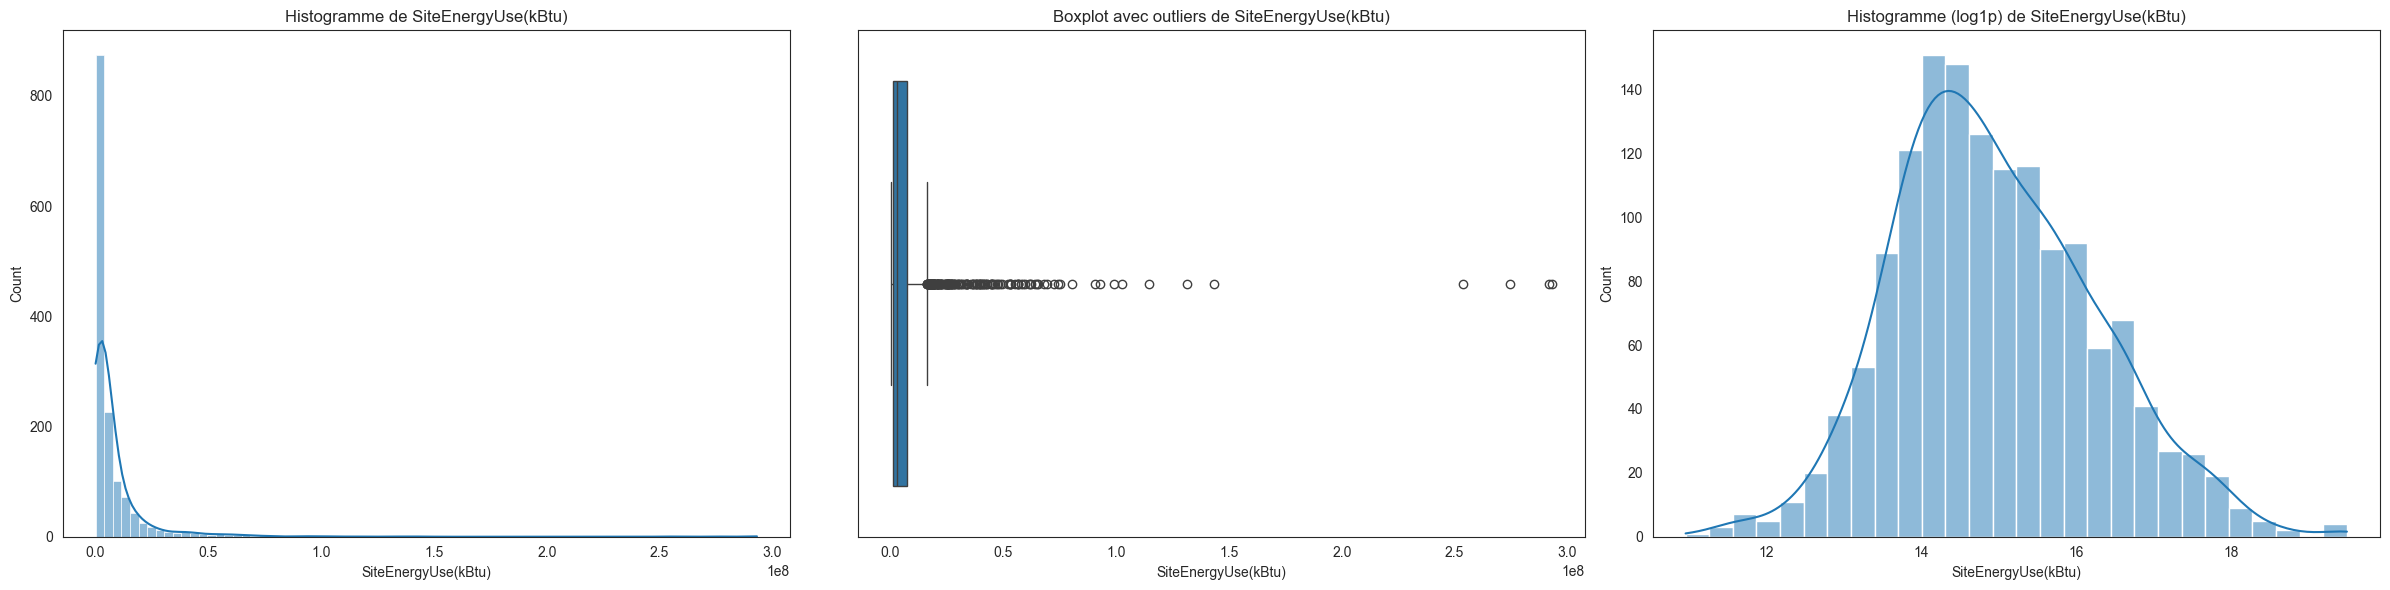

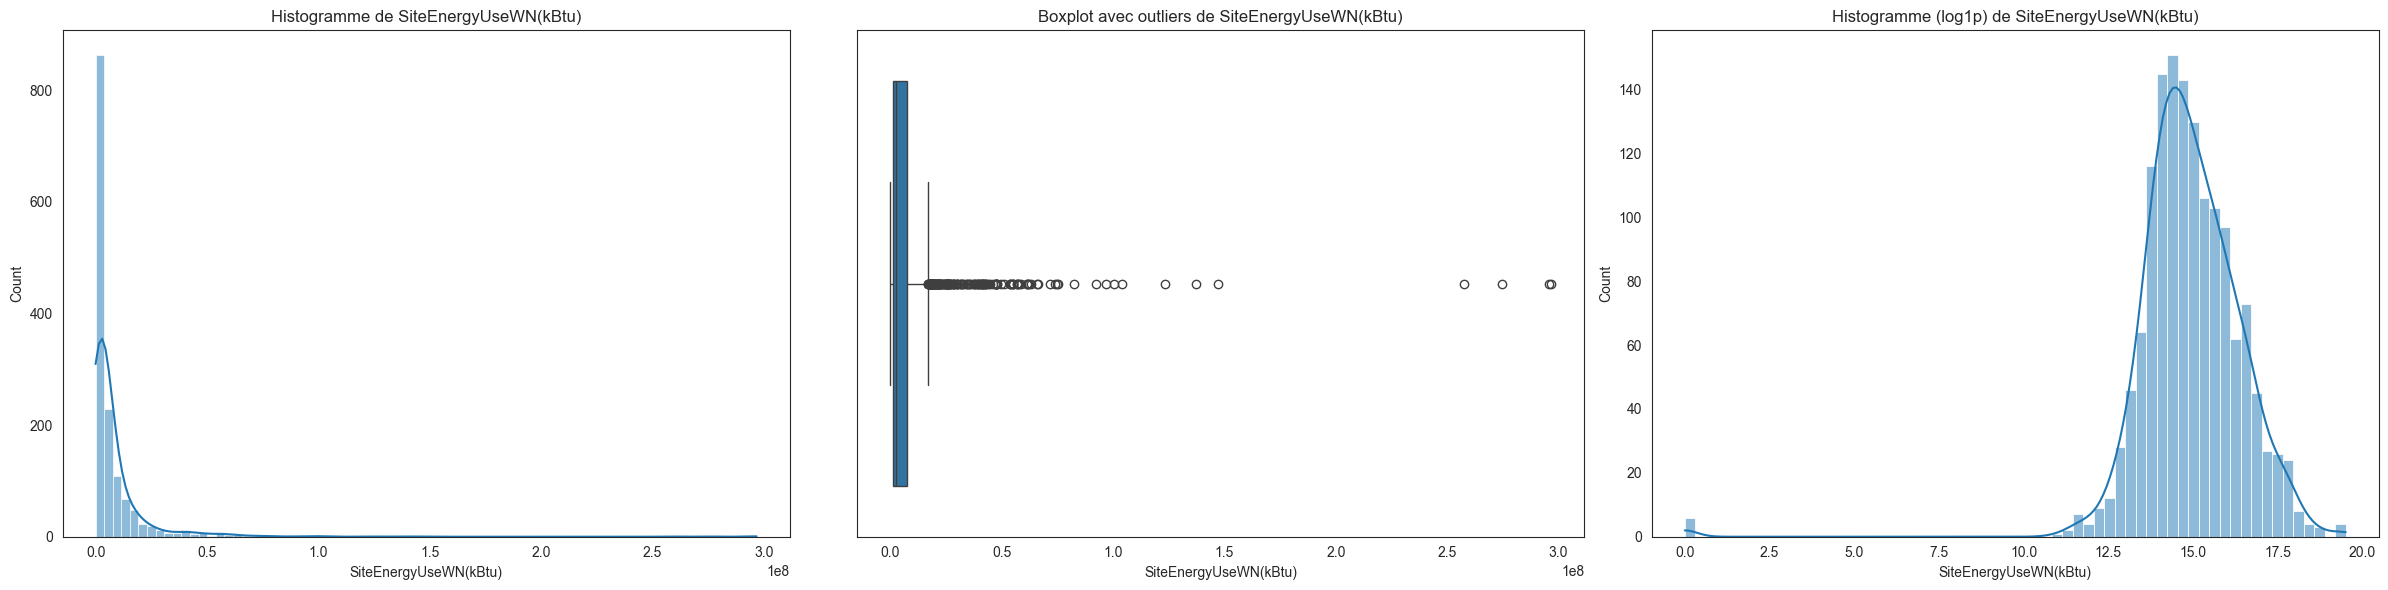

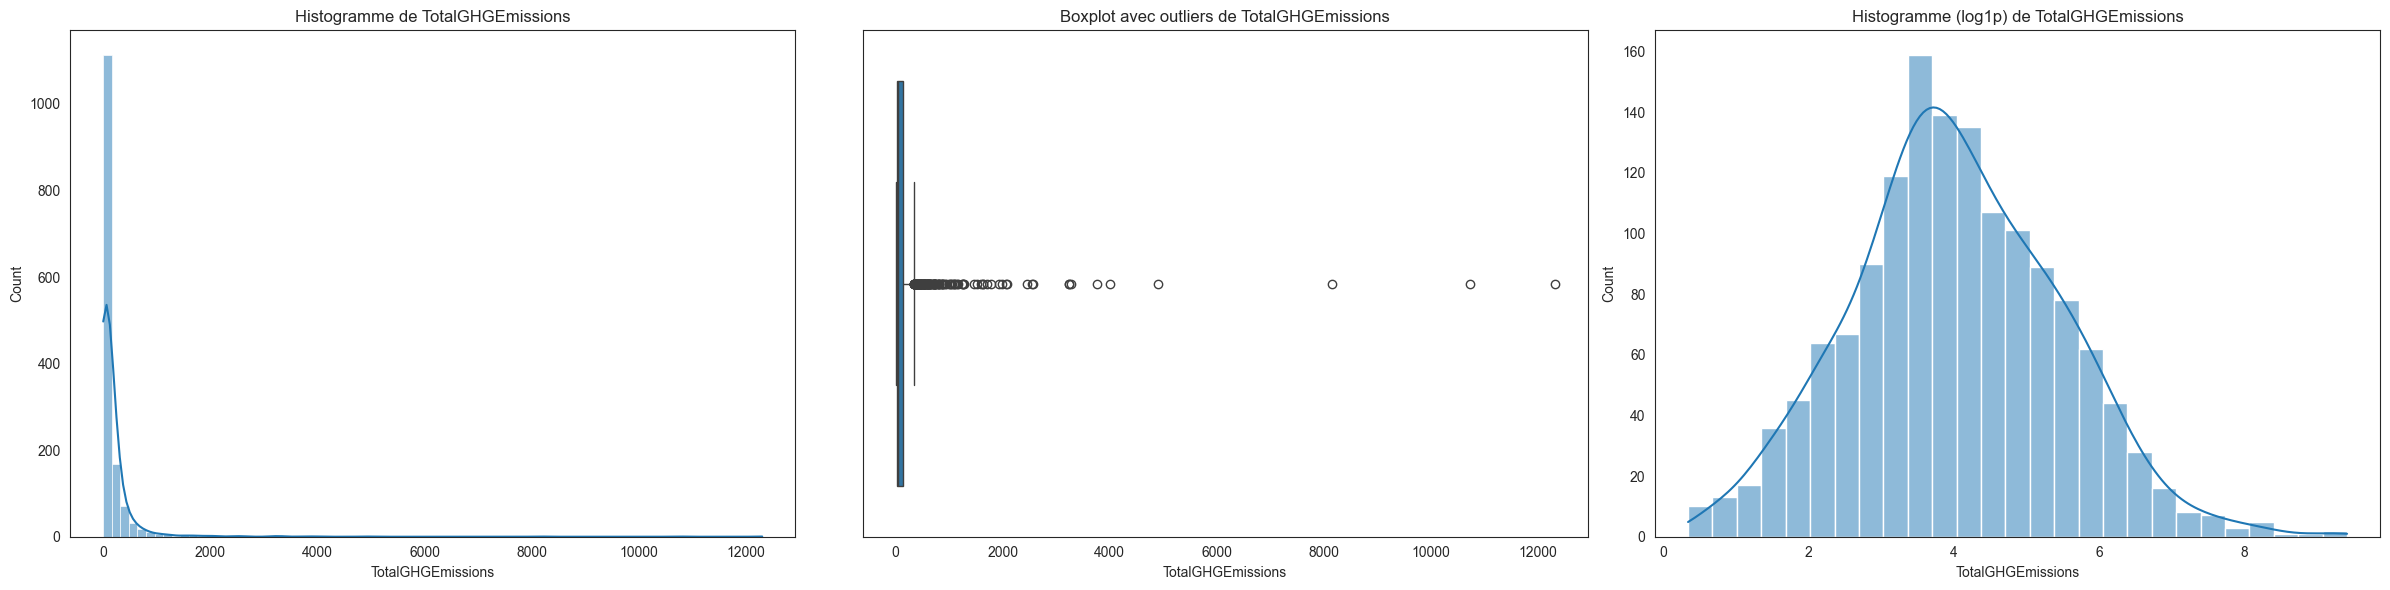

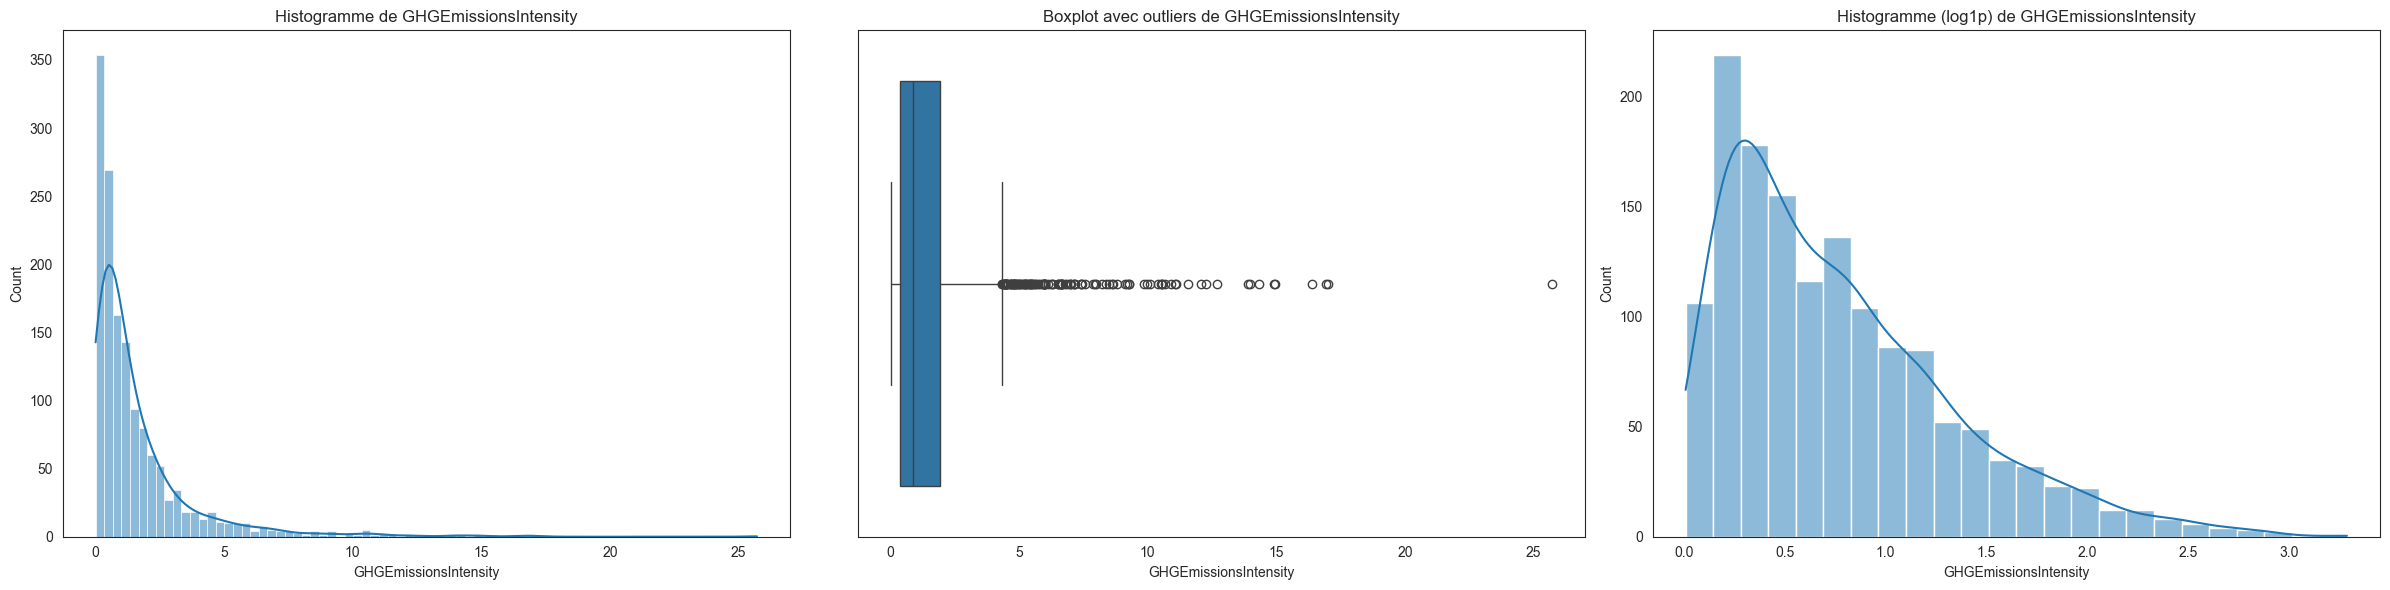

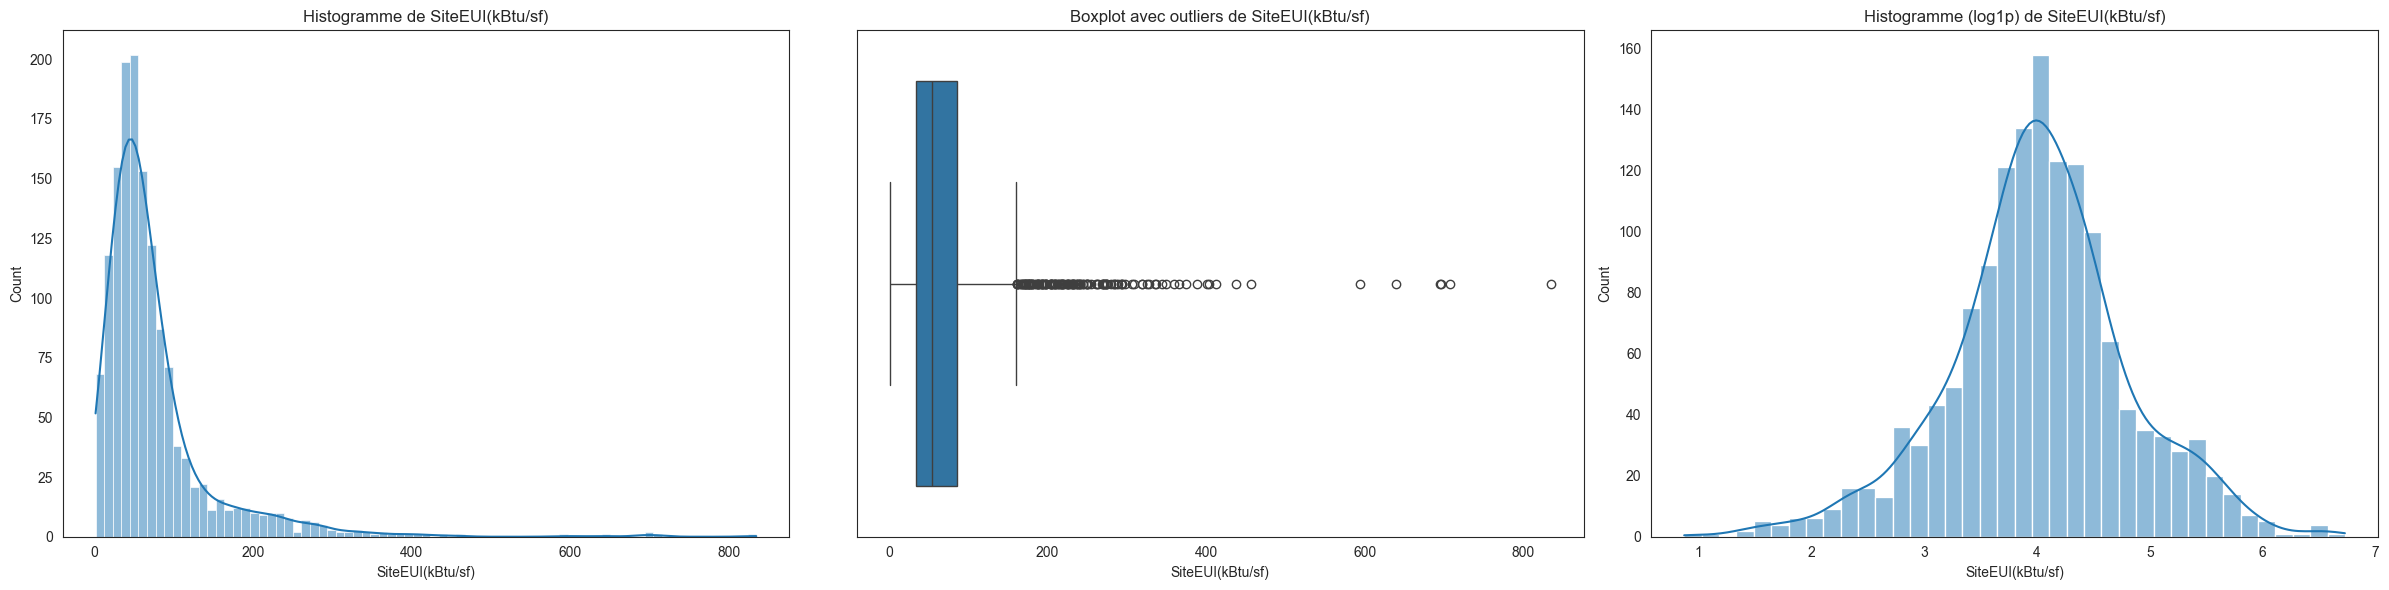

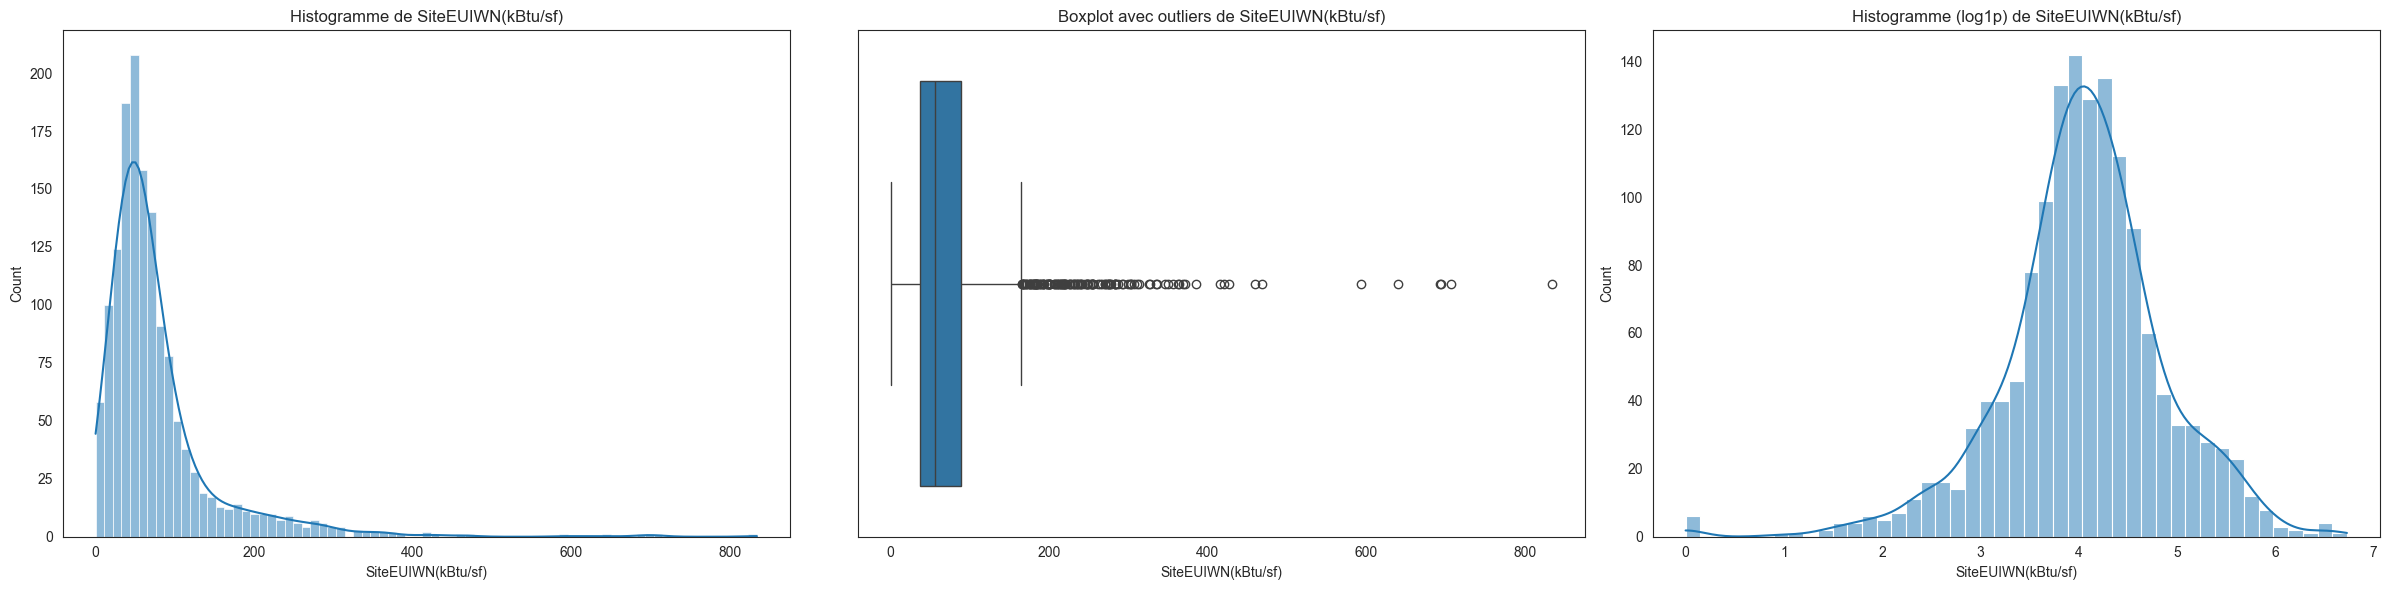

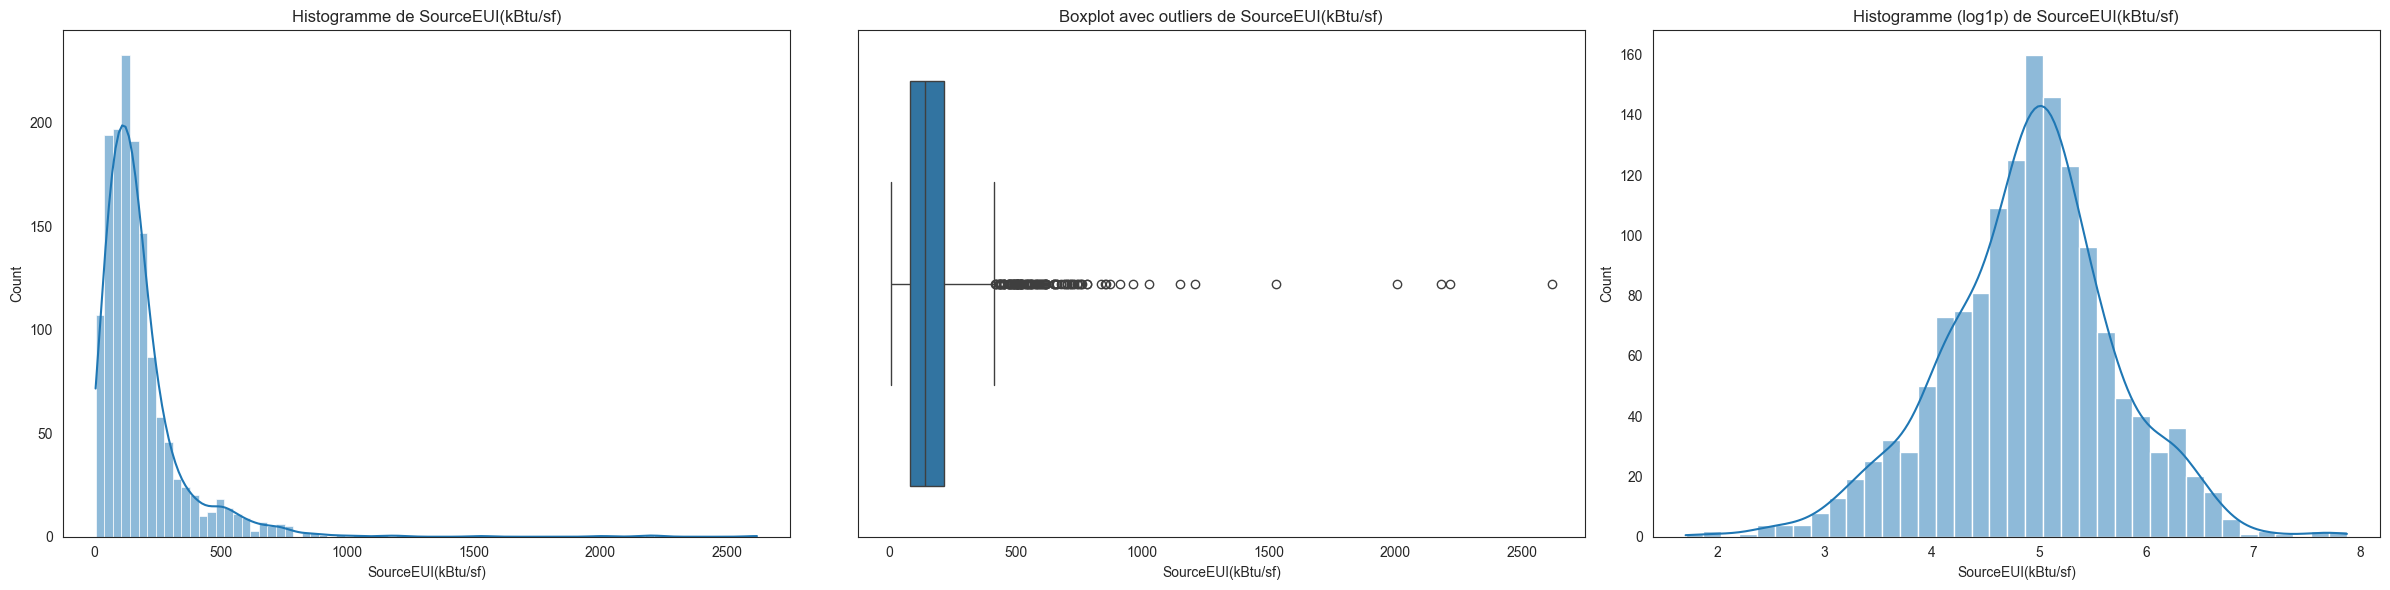

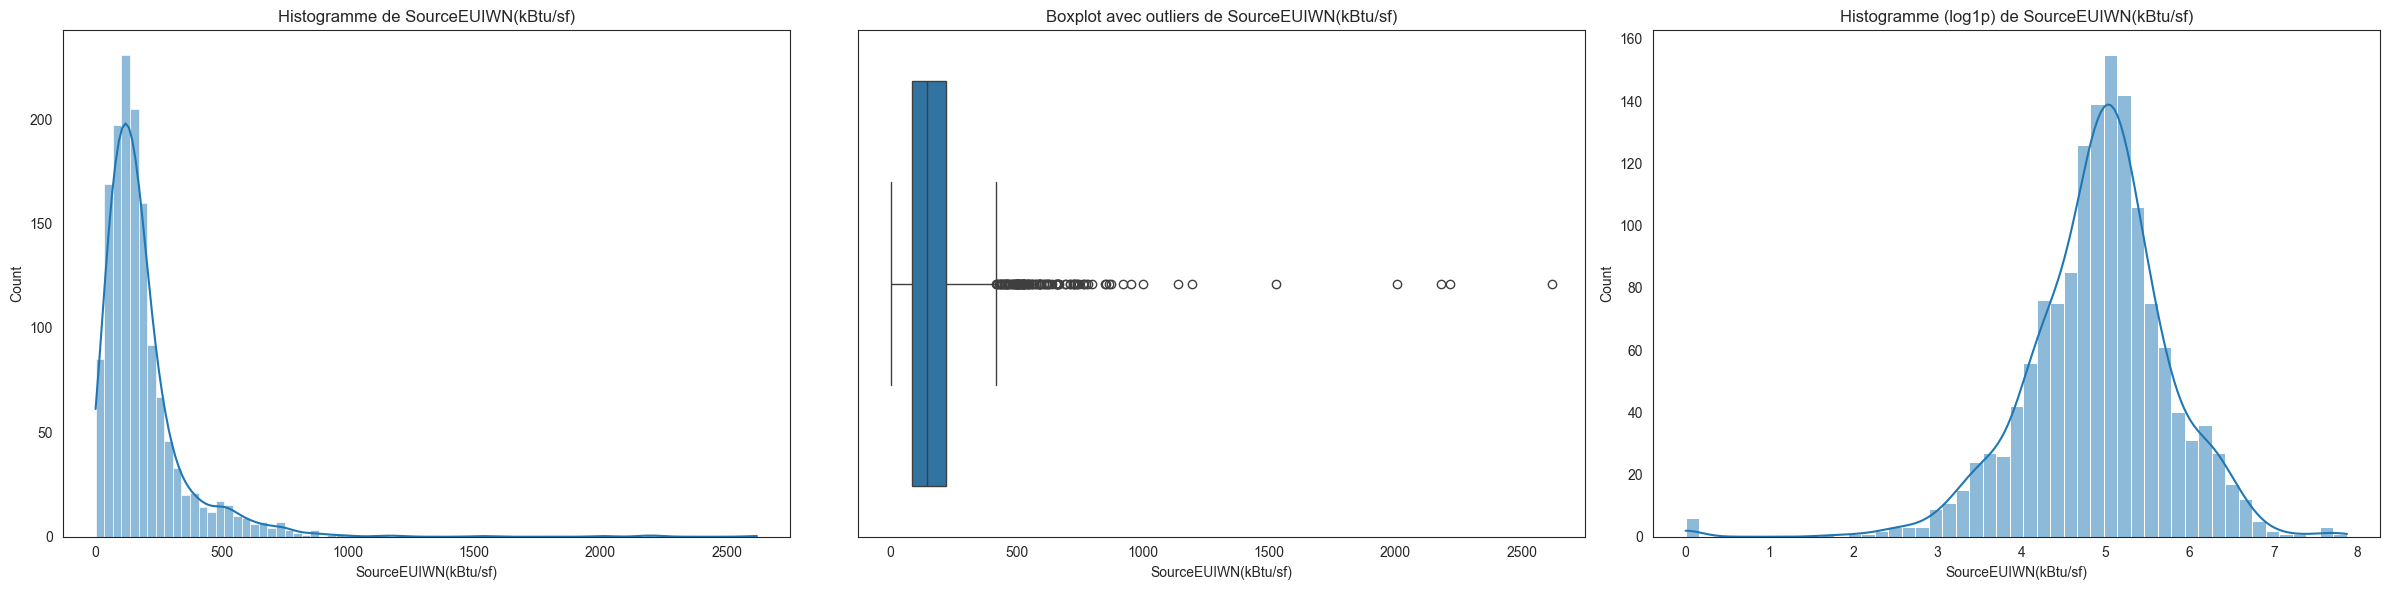

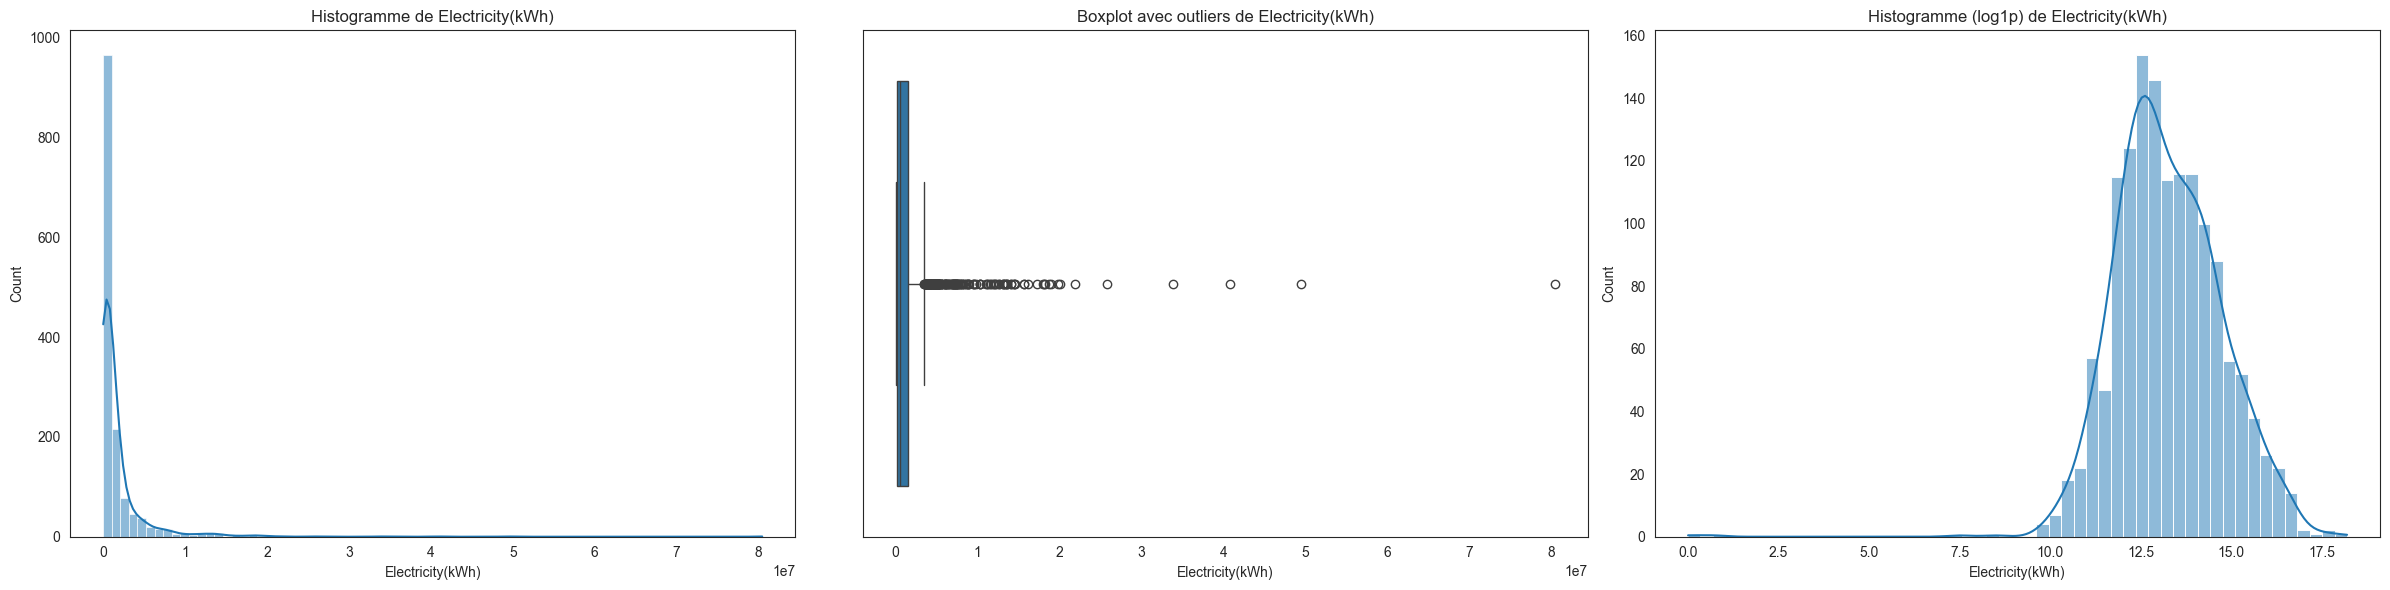

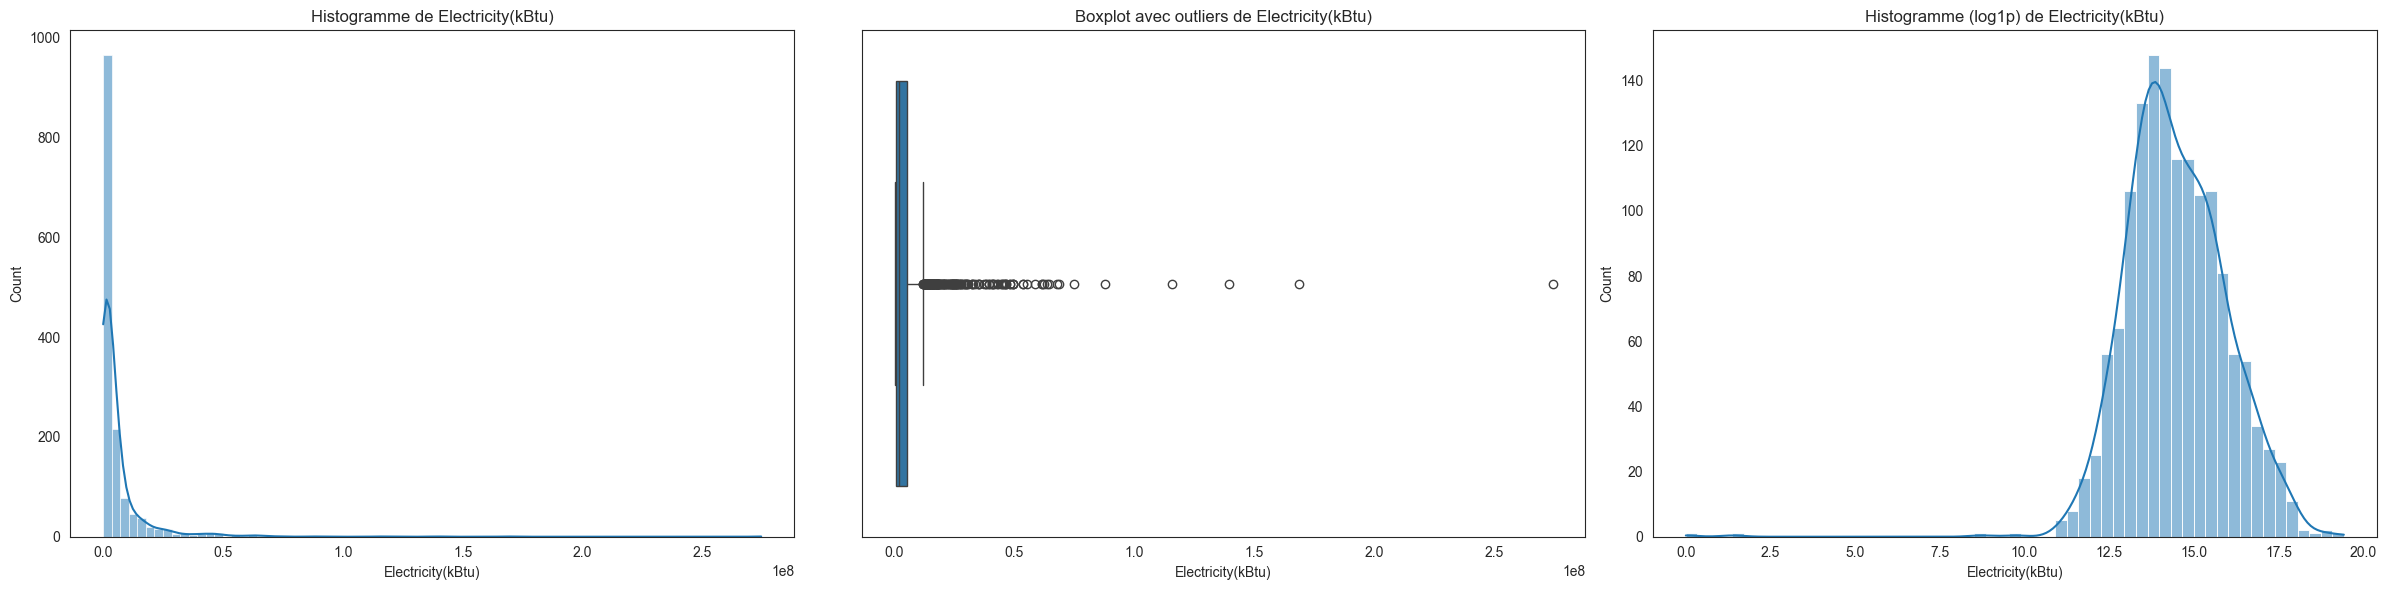

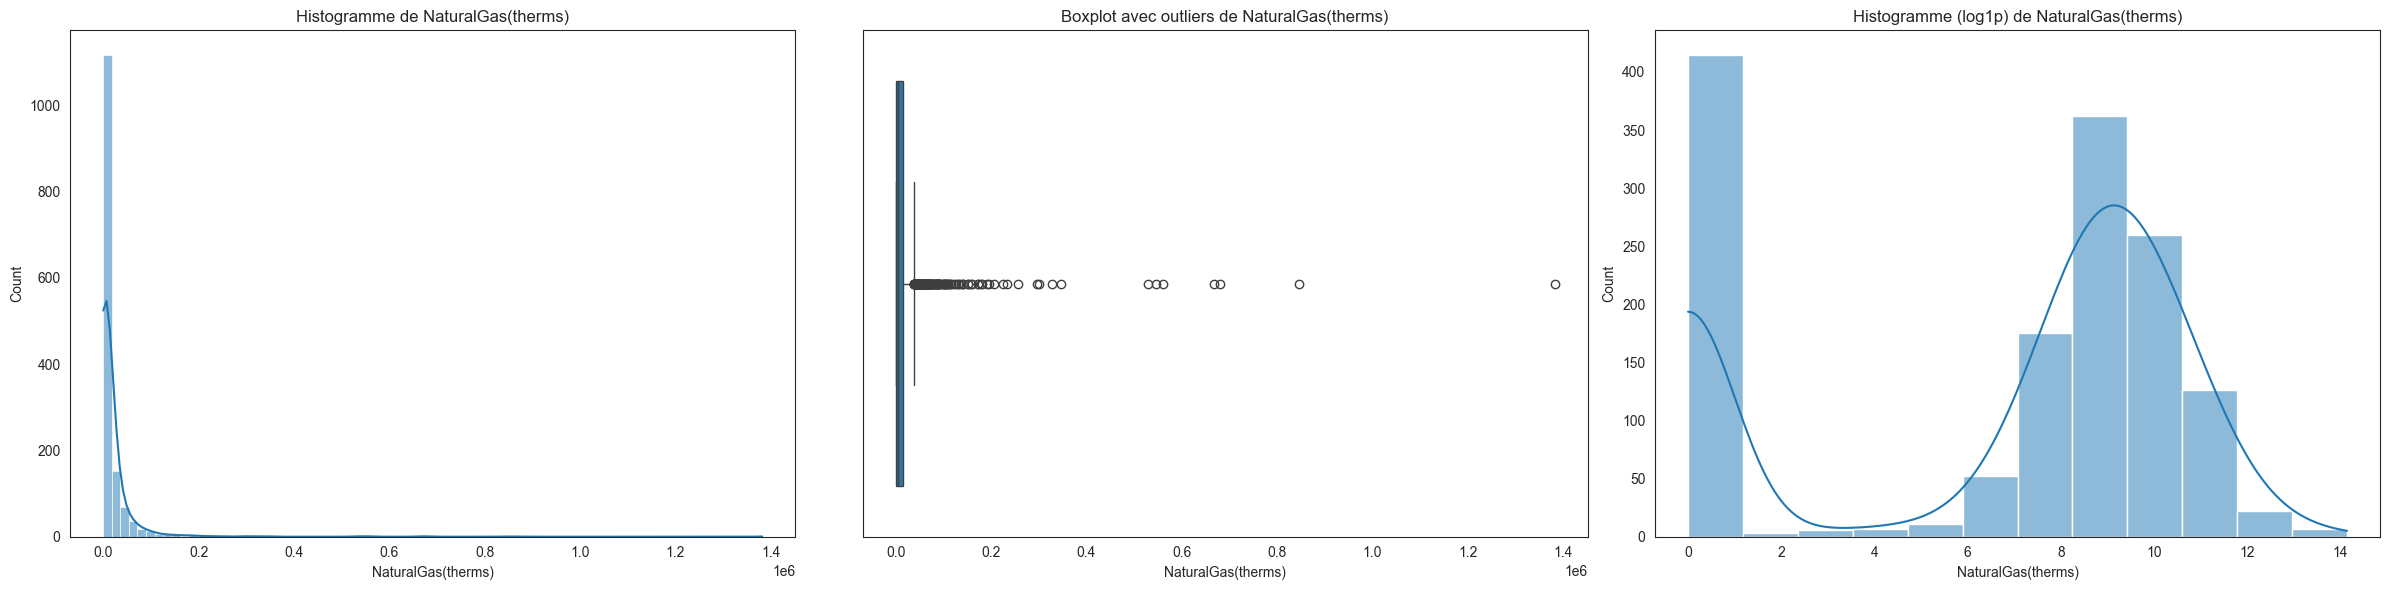

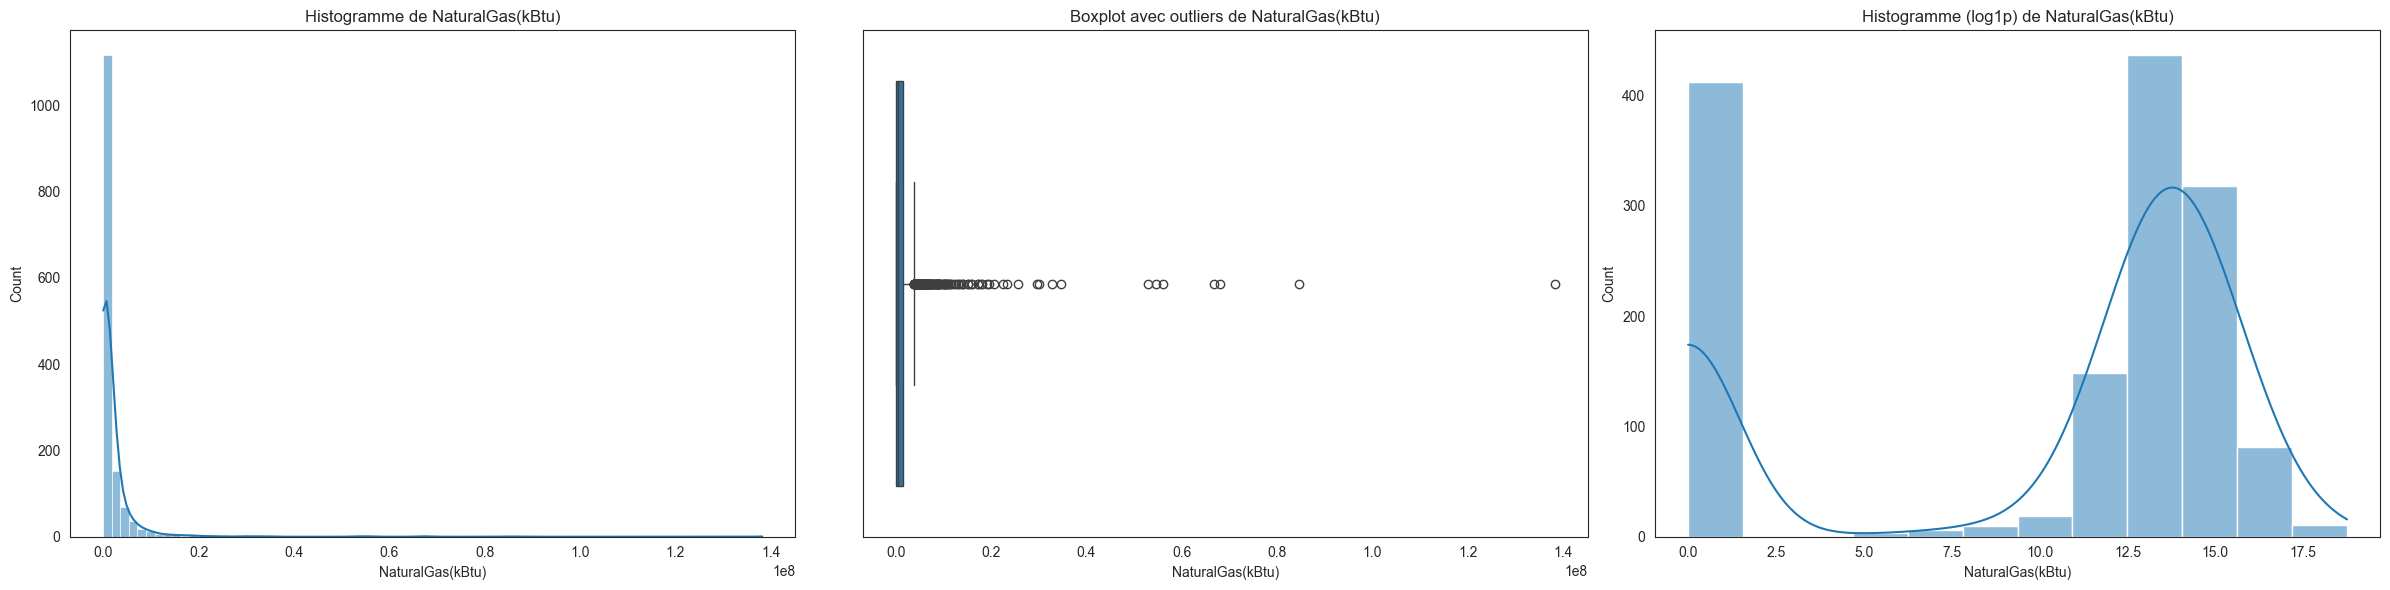

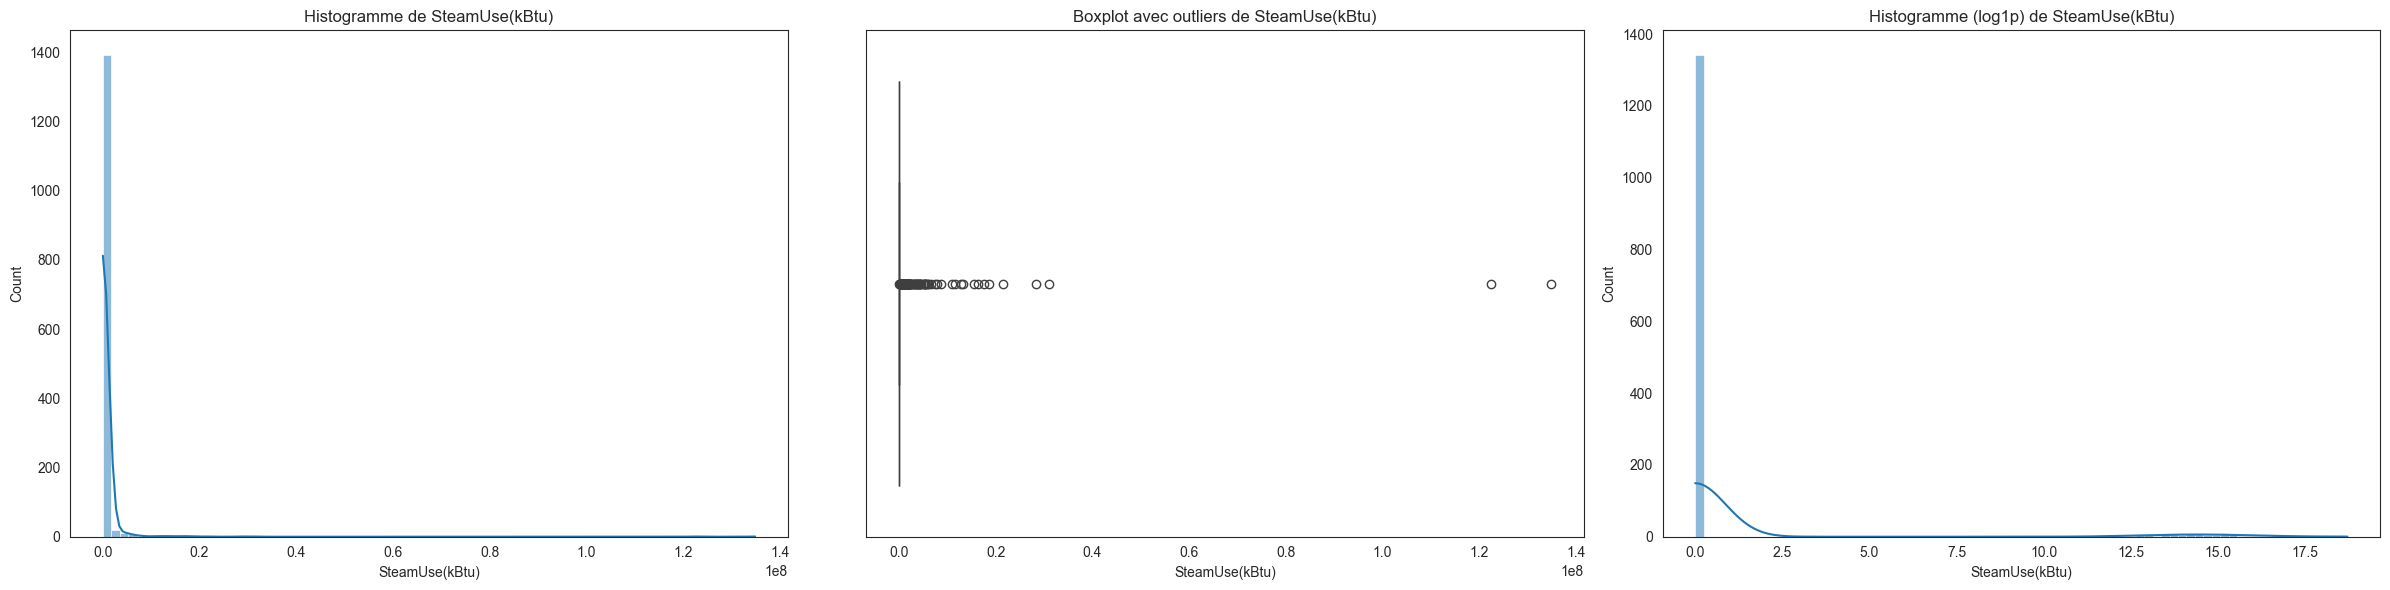

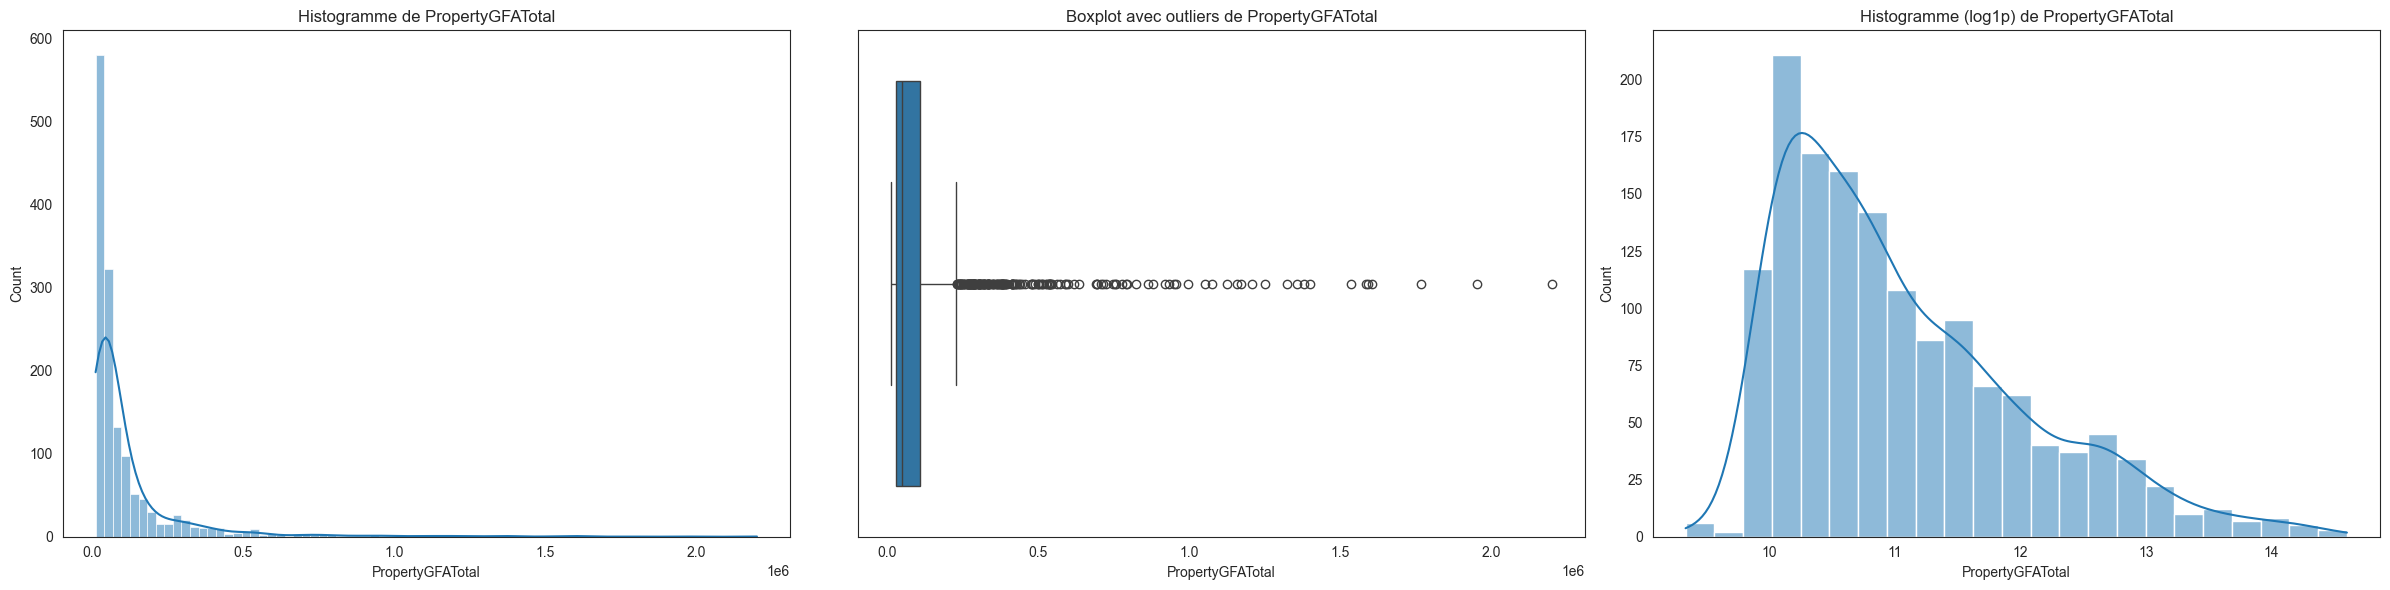

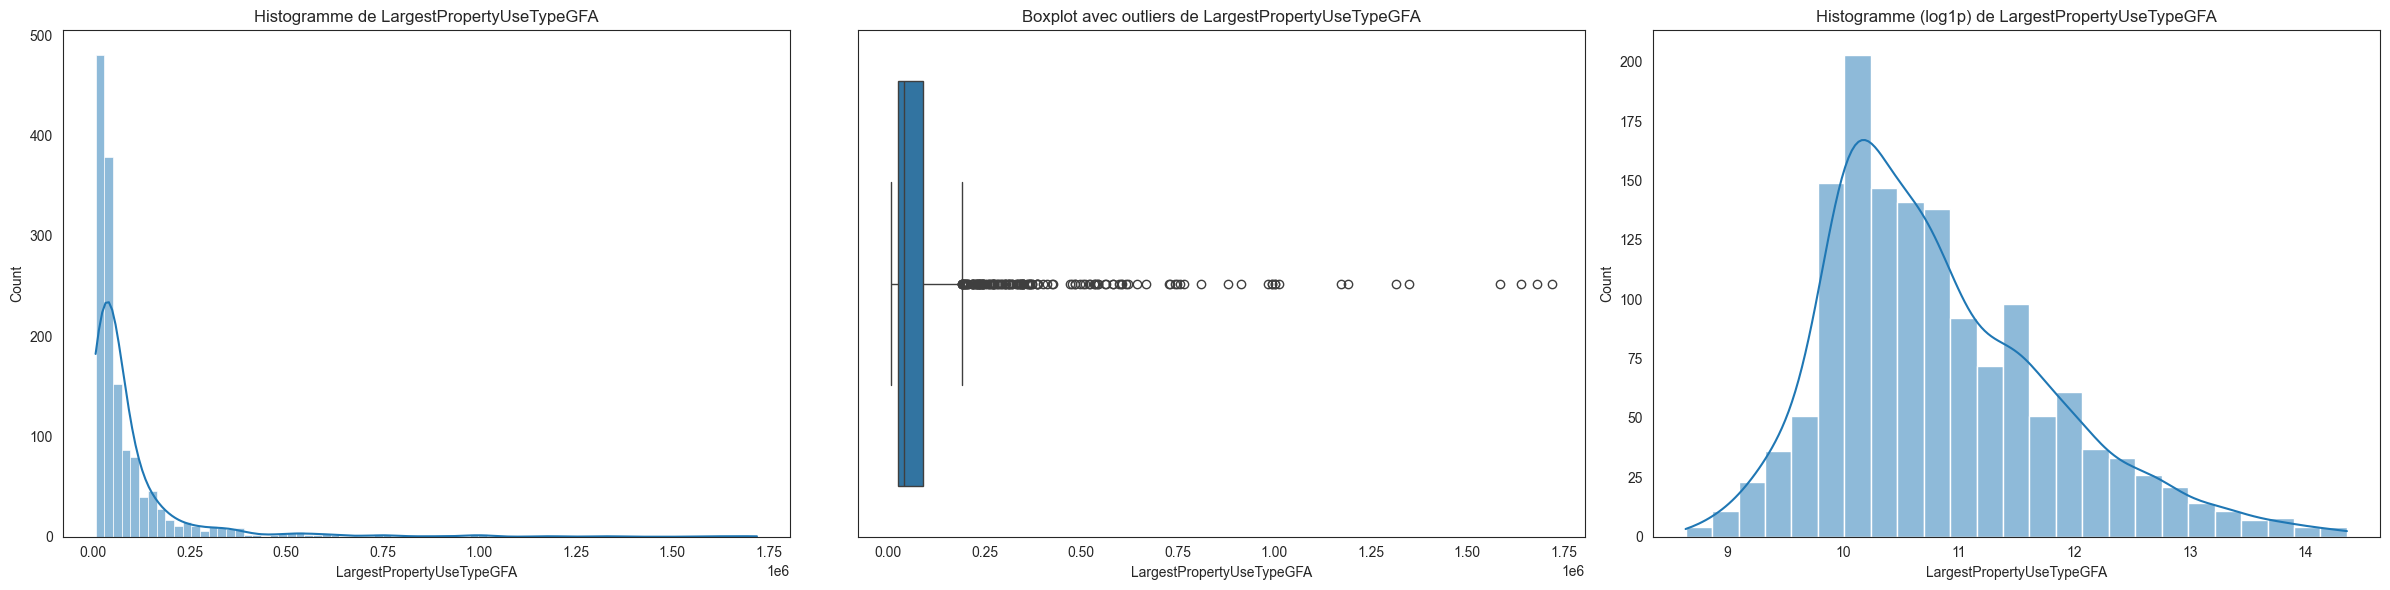

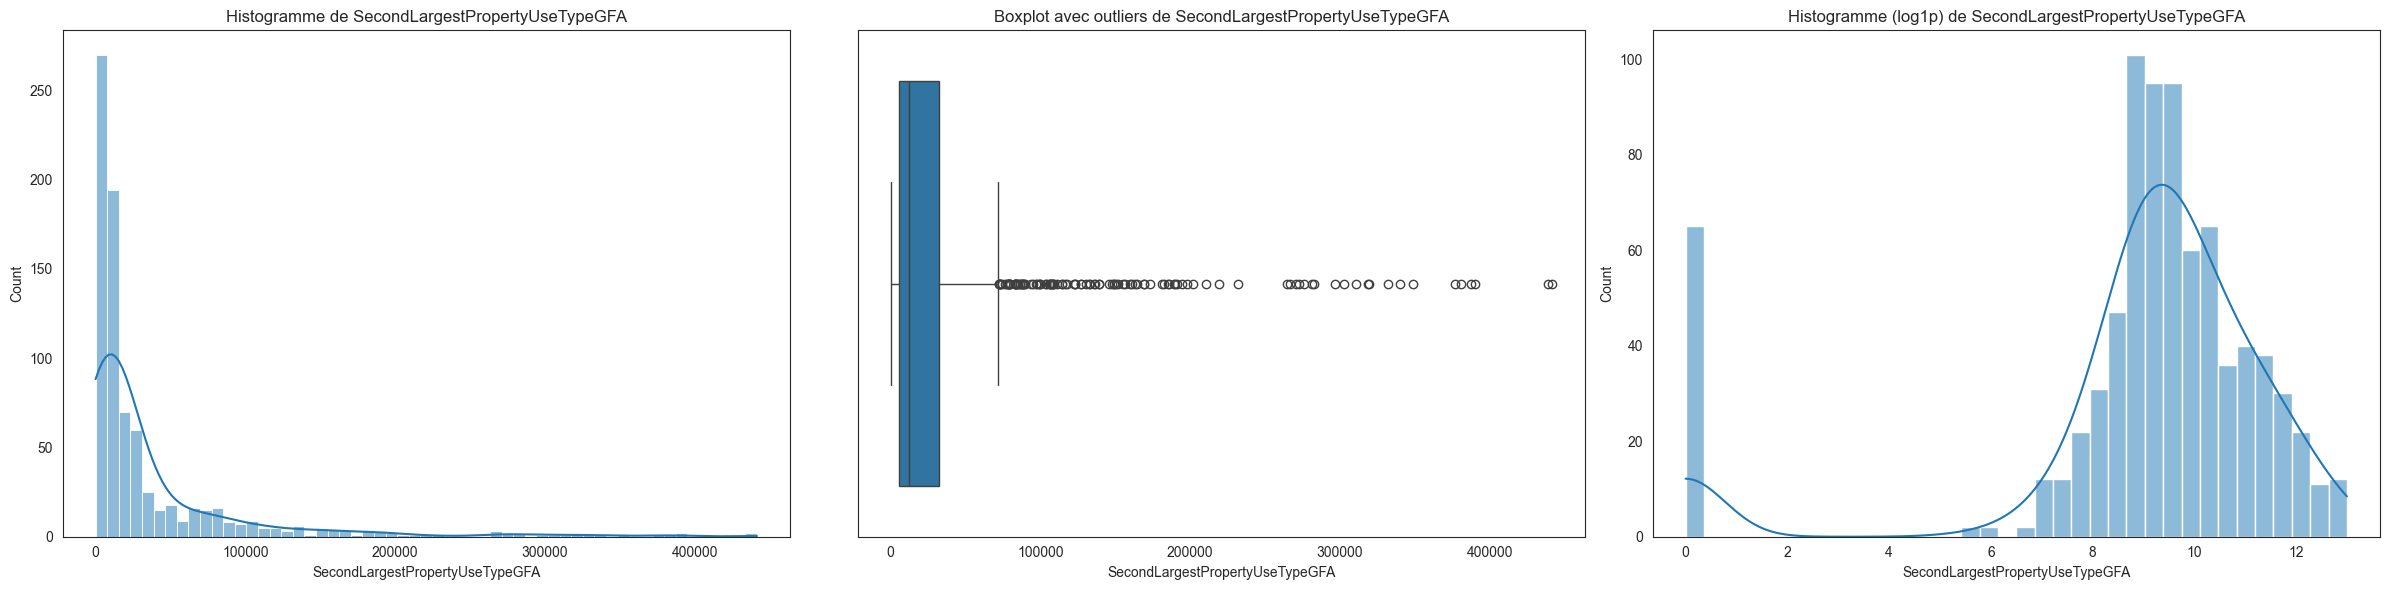

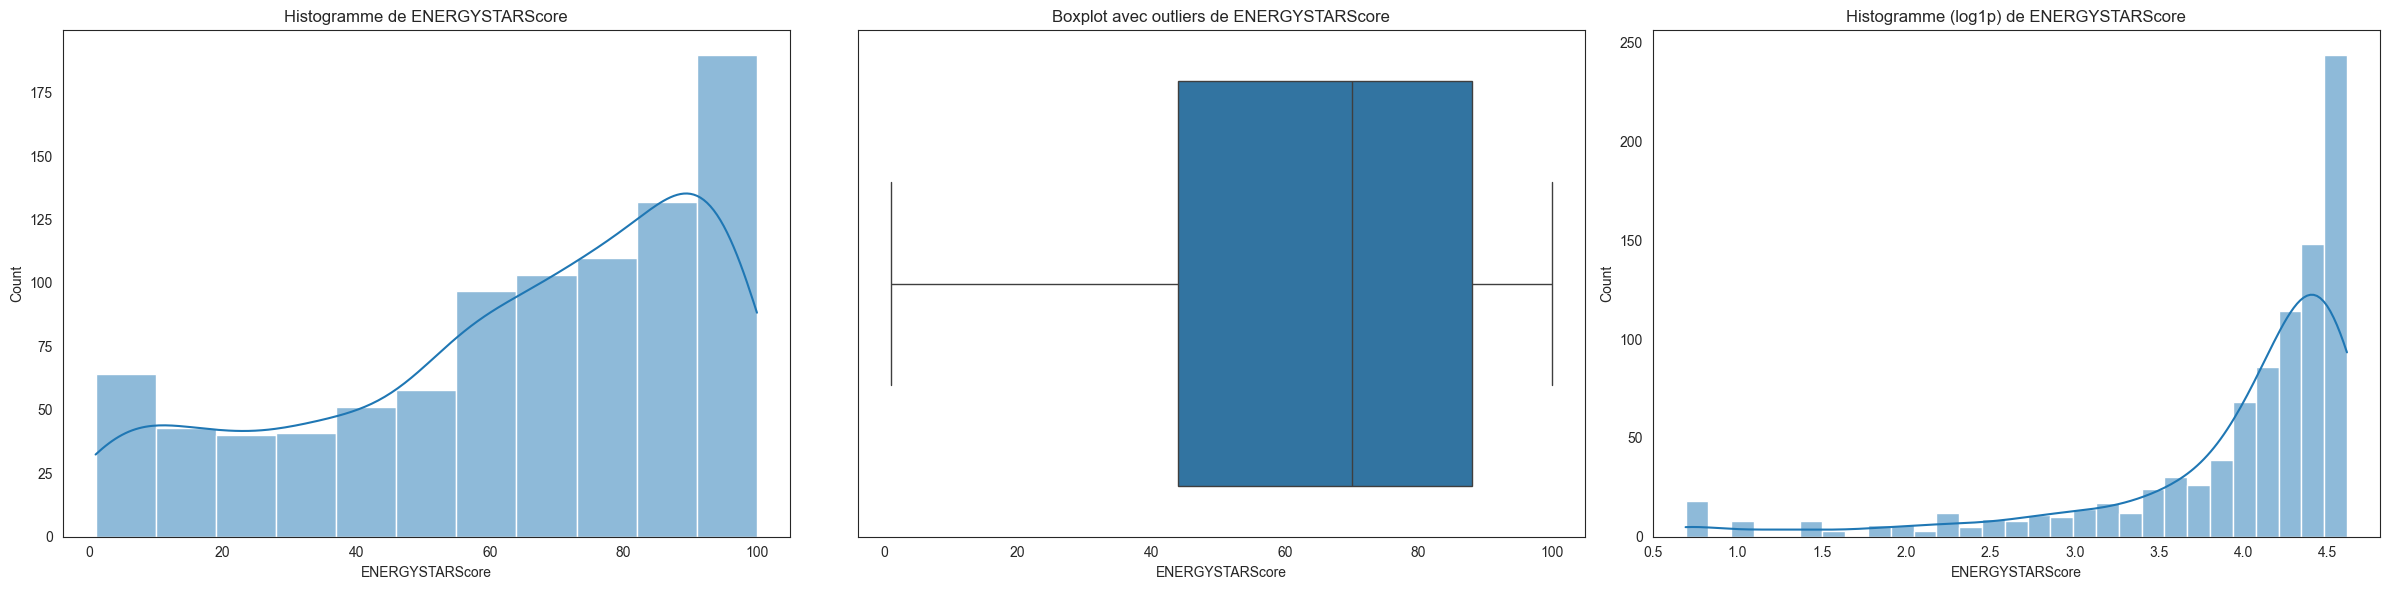

In [37]:

target_cols = [
    'SiteEnergyUse(kBtu)', 
    'SiteEnergyUseWN(kBtu)',
    'TotalGHGEmissions', 
    'GHGEmissionsIntensity', 
    
    # Intensités 
    'SiteEUI(kBtu/sf)', 
    'SiteEUIWN(kBtu/sf)', 
    'SourceEUI(kBtu/sf)', 
    'SourceEUIWN(kBtu/sf)',
    
    # Détail des consommations (Sources d'erreurs fréquentes)
    'Electricity(kWh)', 
    'Electricity(kBtu)', 
    'NaturalGas(therms)', 
    'NaturalGas(kBtu)', 
    'SteamUse(kBtu)', 
    
    # Caractéristiques structurelles 
    'PropertyGFATotal', 
    'LargestPropertyUseTypeGFA', 
    'SecondLargestPropertyUseTypeGFA', 
    'ENERGYSTARScore'
]

# Filtrer les variables présentes dans le dataframe et conserver l'ordre
analyze_cols = [col for col in target_cols if col in df_raw.columns]

def plot_distributions(data, col):
    data_pos = data[data >= 0]

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # Histogramme brut
    sns.histplot(data_pos, kde=True, ax=axes[0])
    axes[0].set_title(f'Histogramme de {col}')

    # Boxplot avec outliers
    sns.boxplot(x=data_pos, showfliers=True, ax=axes[1])
    axes[1].set_title(f'Boxplot avec outliers de {col}')

    # Histogramme log-transformé
    sns.histplot(np.log1p(data_pos), kde=True, ax=axes[2])
    axes[2].set_title(f'Histogramme (log1p) de {col}')

    plt.tight_layout()
    return fig


def export_figures(df, cols, output_dir="../figures/notebook_1"):
    """
    Exporte les figures générées pour chaque variable dans un dossier donné.
    """
    for idx, col in enumerate(cols, start=5):
        data = df[col].dropna()
        fig = plot_distributions(data, col)

        # Nettoyer le nom de fichier
        safe_col = re.sub(r'[^\w\-_.]', '_', col)
        filename = f"{output_dir}/{idx}_audit_indicateurs_{safe_col}.png"

        fig.savefig(filename, dpi=300)
        plt.show()


export_figures(df_raw, analyze_cols)




### Démarche pratique d’analyse des valeurs aberrantes

Pour chaque variable, l’analyse repose sur une lecture conjointe des trois graphiques.

- **Histogramme brut**  
  Sert à identifier l’asymétrie globale, la présence de longues traînes et les ordres de grandeur.
  Il permet de juger immédiatement si une méthode paramétrique comme le Z-score est envisageable
  sur la variable brute.

- **Box-plot avec outliers**  
  Sert à évaluer l’ampleur du phénomène extrême :
  nombre de valeurs extrêmes, écrasement de la boîte, distance entre la médiane et les moustaches.
  Il permet de savoir si les valeurs extrêmes sont rares ou massives,
  et si une méthode basée sur l’IQR est inadaptée appliquée directement (trop de valeurs hors boites,c'est pas bon signe).

- **Histogramme après transformation (log1p)**  
  Sert à vérifier si la transformation rend la distribution plus symétrique et exploitable.
  Si la distribution devient plus compacte et unimodale, une détection statistique
  (Z-score sur données transformées) devient pertinente.

> Dans le cas où la transformation logarithmique ne parvient pas à rendre la distribution suffisamment
symétrique ou proche d’une loi normale, deux choix s’offrent à nous.  
- Si le nombre de valeurs extrêmes reste limité, l’approche par l’IQR demeure pertinente pour isoler
ces observations atypiques.  
- En revanche, si les valeurs extrêmes sont trop nombreuses ou structurellement liées à des
caractéristiques spécifiques des bâtiments, il devient nécessaire d’examiner les distributions
par regroupement par type de batiment afin de contextualiser la détection
et éviter de qualifier à tort des comportements énergétiques légitimes comme aberrants.



# Tableau des variables et décisions associées

| Variable                     | Décision            |
|------------------------------|---------------------|
| SiteEnergyUse(kBtu)          | Log-transformation  |
| SiteEnergyUseWN(kBtu)        |Log-transformation           |
| TotalGHGEmissions            |Log-transformation            |
| GHGEmissionsIntensity        | Regroupement|
| SiteEUI(kBtu/sf)             | Regroupement               |
| SiteEUIWN(kBtu/sf)           | Log-transformation            |
| SourceEUI(kBtu/sf)           | Log-transformation             |
| SourceEUIWN(kBtu/sf)         |Log-transformation       |
| Electricity(kWh)             |Log-transformation    |
| Electricity(kBtu)            |Log-transformation   |
| NaturalGas(therms)           | regroupement  |
| NaturalGas(kBtu)             | Regroupement                 |
| SteamUse(kBtu)               |Regroupement           |
| PropertyGFATotal             | Regroupement        |
| LargestPropertyUseTypeGFA    | regroupement                |
| SecondLargestPropertyUseTypeGFA | Regroupement     |
| ENERGYSTARScore              | regroupement            |


## Implémentation de la détection des valeurs aberrantes

Suite à l'analyse visuelle des distributions, nous procédons maintenant à l'identification systématique des valeurs extrêmes selon trois stratégies distinctes :

1. **Transformation logarithmique + Z-score** : Pour les variables dont la distribution devient symétrique après log1p
2. **Détection par regroupement** : Pour les variables nécessitant une contextualisation par type de bâtiment

Cette approche multi-méthodes reconnaît que les valeurs extrêmes ne sont pas toutes de même nature. Certaines sont des erreurs manifestes indépendantes du contexte (consommation totale aberrante), d'autres sont des anomalies relatives qui ne se révèlent qu'en comparaison avec des bâtiments similaires (intensité énergétique d'un hôpital vs un entrepôt).

In [43]:
# Vérification des valeurs nulles sur les variables clés
cols_to_check = [
    'SiteEnergyUse(kBtu)', 
    'SiteEnergyUseWN(kBtu)',
    'TotalGHGEmissions',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'Electricity(kWh)',
    'Electricity(kBtu)'
]

null_counts = df_raw[cols_to_check].isnull().sum()
print(" Nombre de valeurs nulles par variable :\n")
print(null_counts)


 Nombre de valeurs nulles par variable :

SiteEnergyUse(kBtu)      0
SiteEnergyUseWN(kBtu)    0
TotalGHGEmissions        0
SiteEUIWN(kBtu/sf)       0
SourceEUI(kBtu/sf)       0
SourceEUIWN(kBtu/sf)     0
Electricity(kWh)         0
Electricity(kBtu)        0
dtype: int64


#### Justification du seuil Z-score

Le seuil de ±3 écarts-types est fondé sur la règle empirique dite des 68-95-99,7 %.  
- Environ 99,7 % des observations d’une distribution normale se trouvent dans cet intervalle.  
- Par conséquent, moins de 0,3 % des points devraient dépasser ce seuil, ce qui en fait des candidats plausibles à l’étiquette d’outliers.  
- Ce choix est largement utilisé en statistique appliquée et en détection d’anomalies, bien qu’il ne soit pas universel et puisse être adapté selon le contexte.
Source : https://www.geeksforgeeks.org/machine-learning/z-score-for-outlier-detection-python/

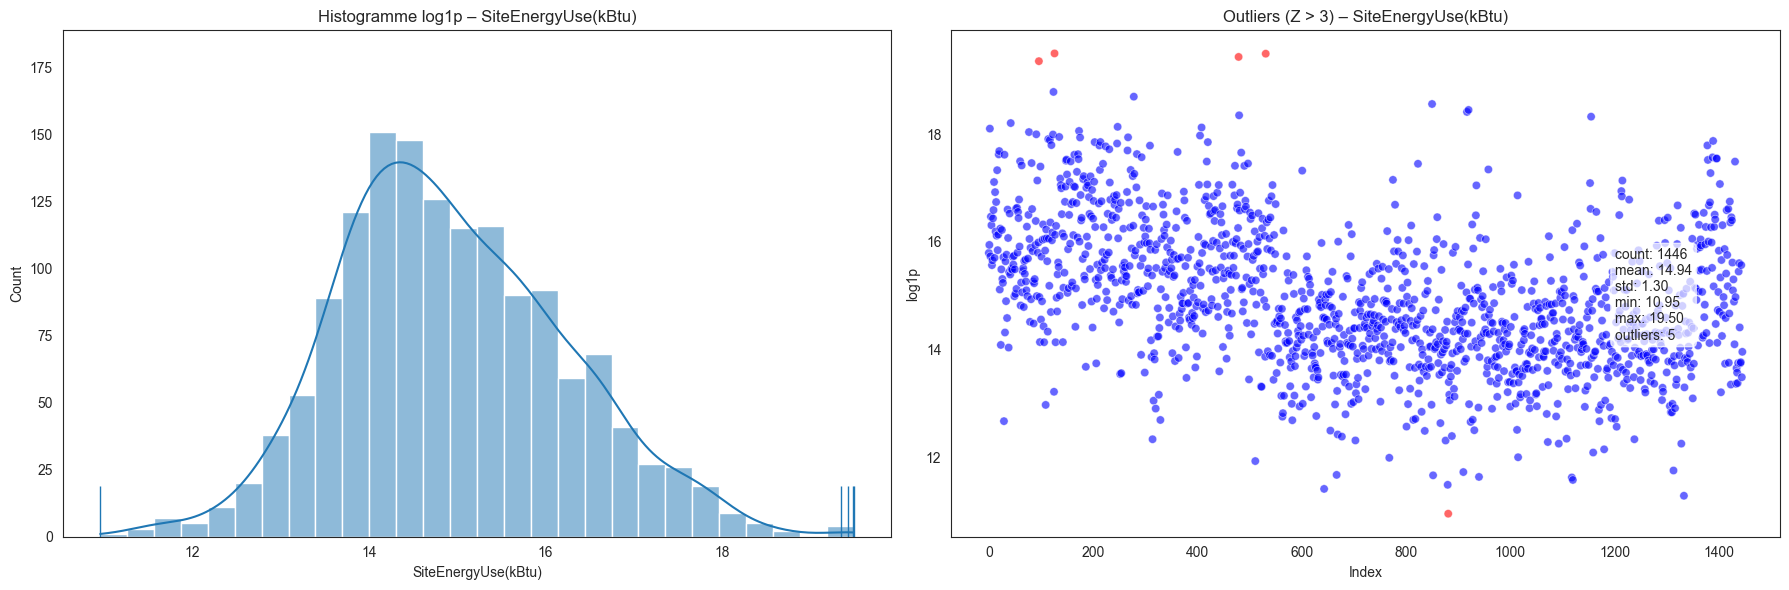

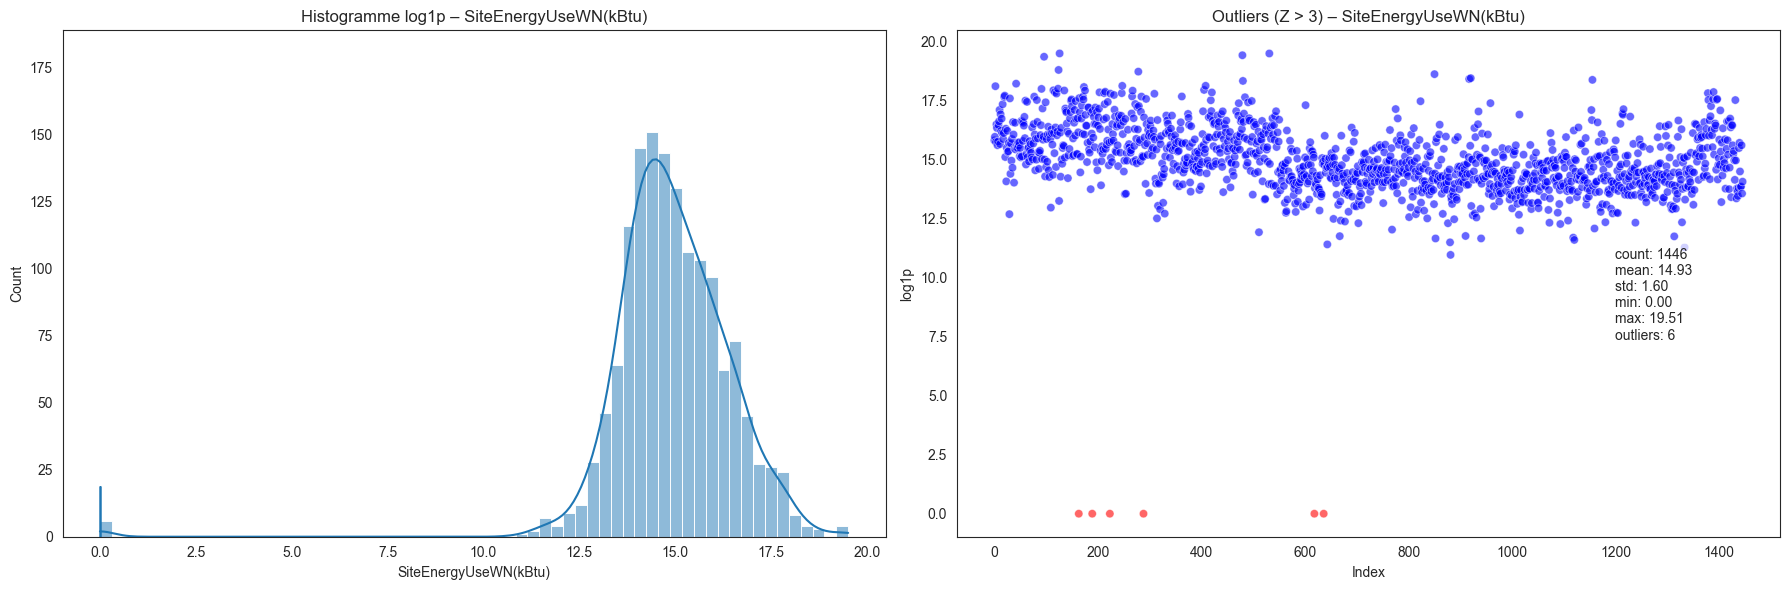

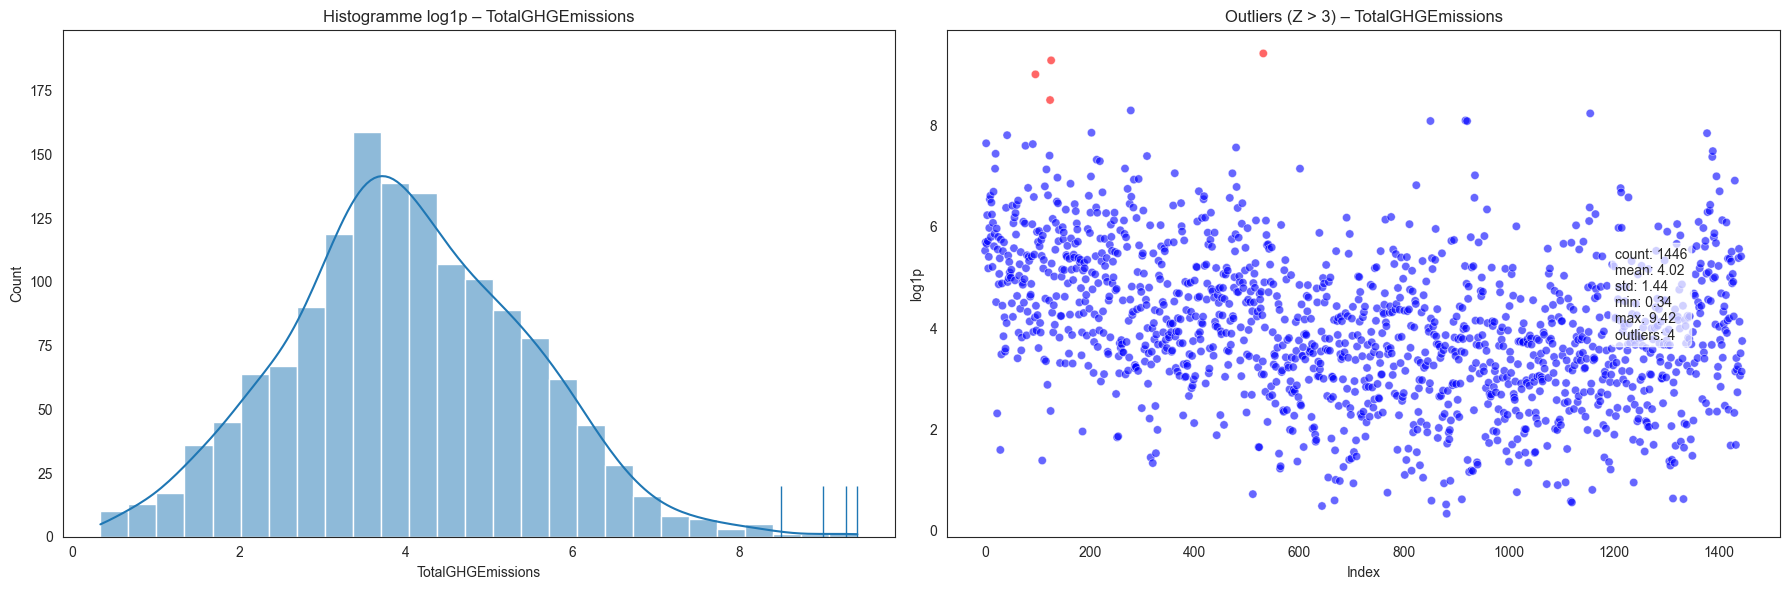

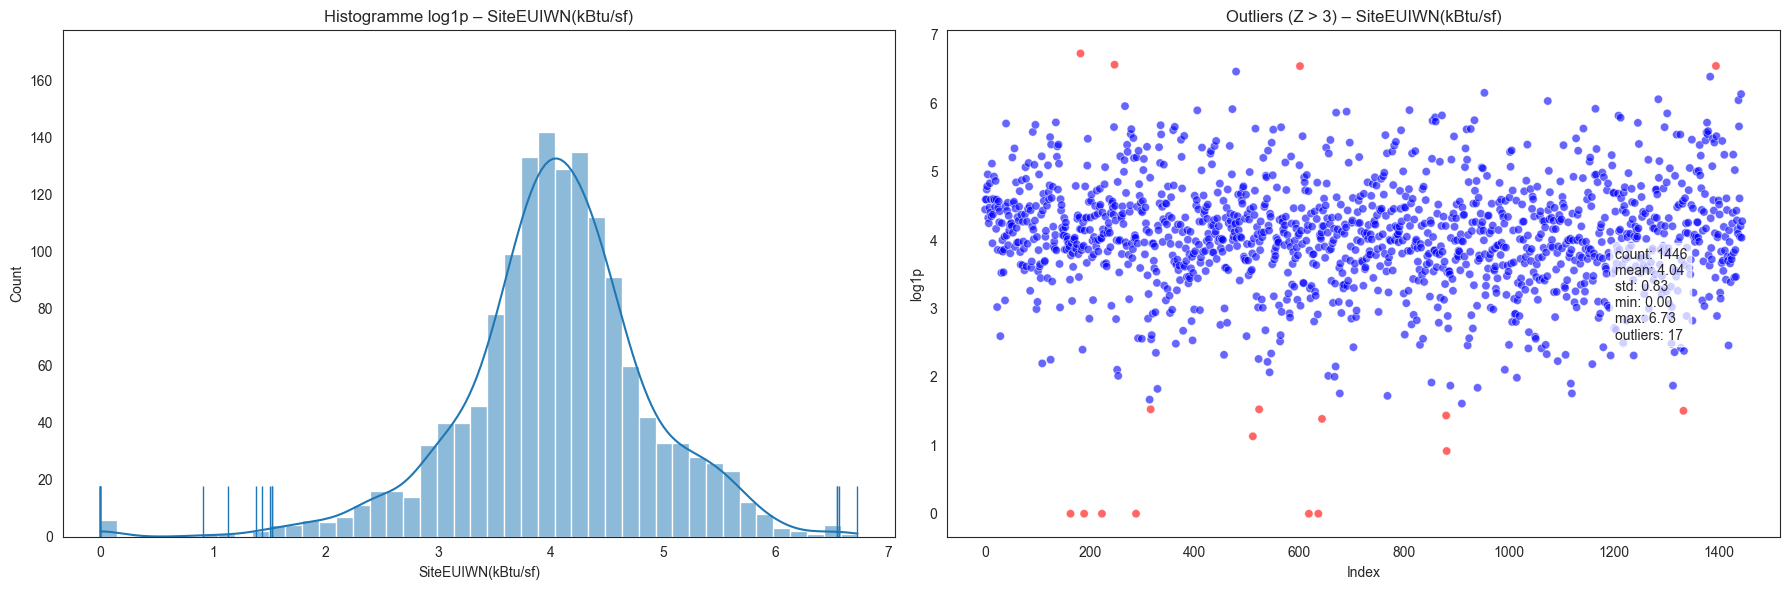

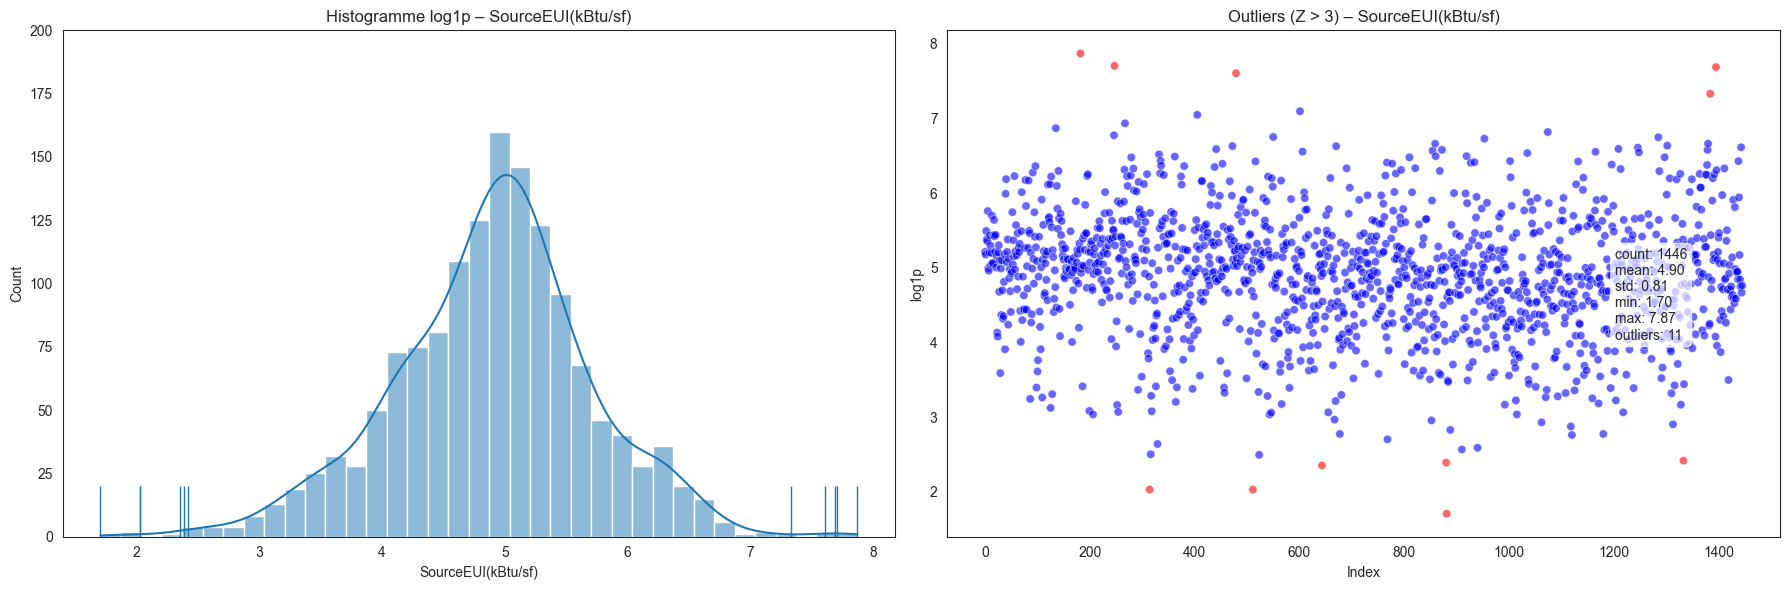

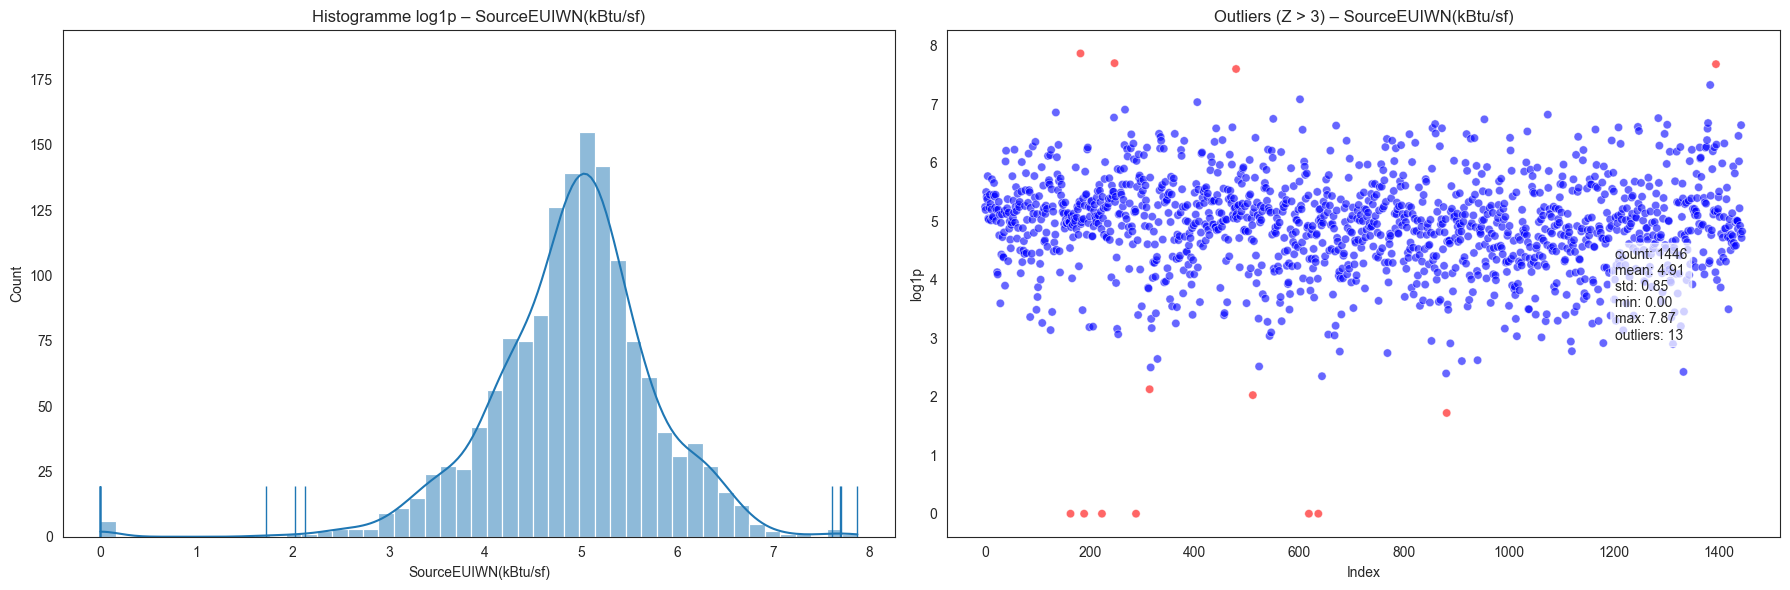

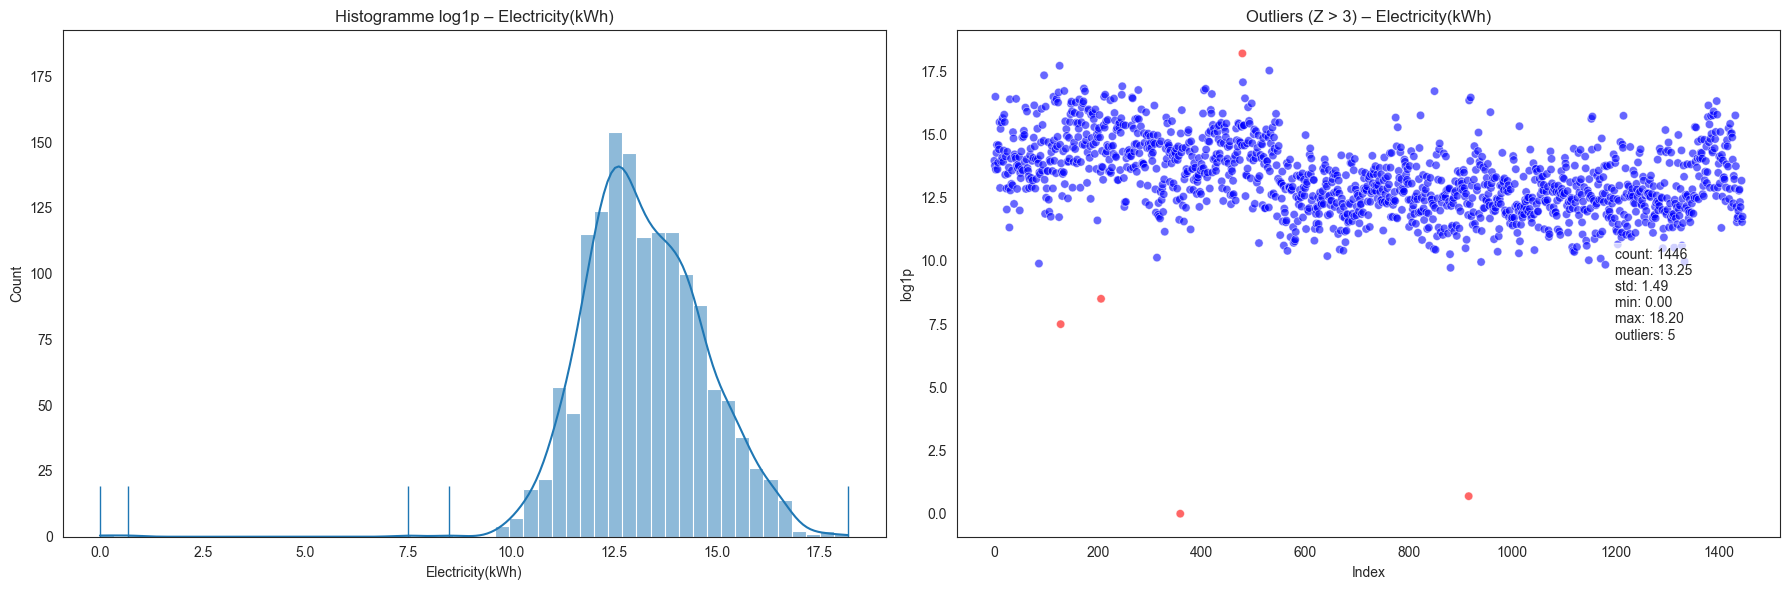

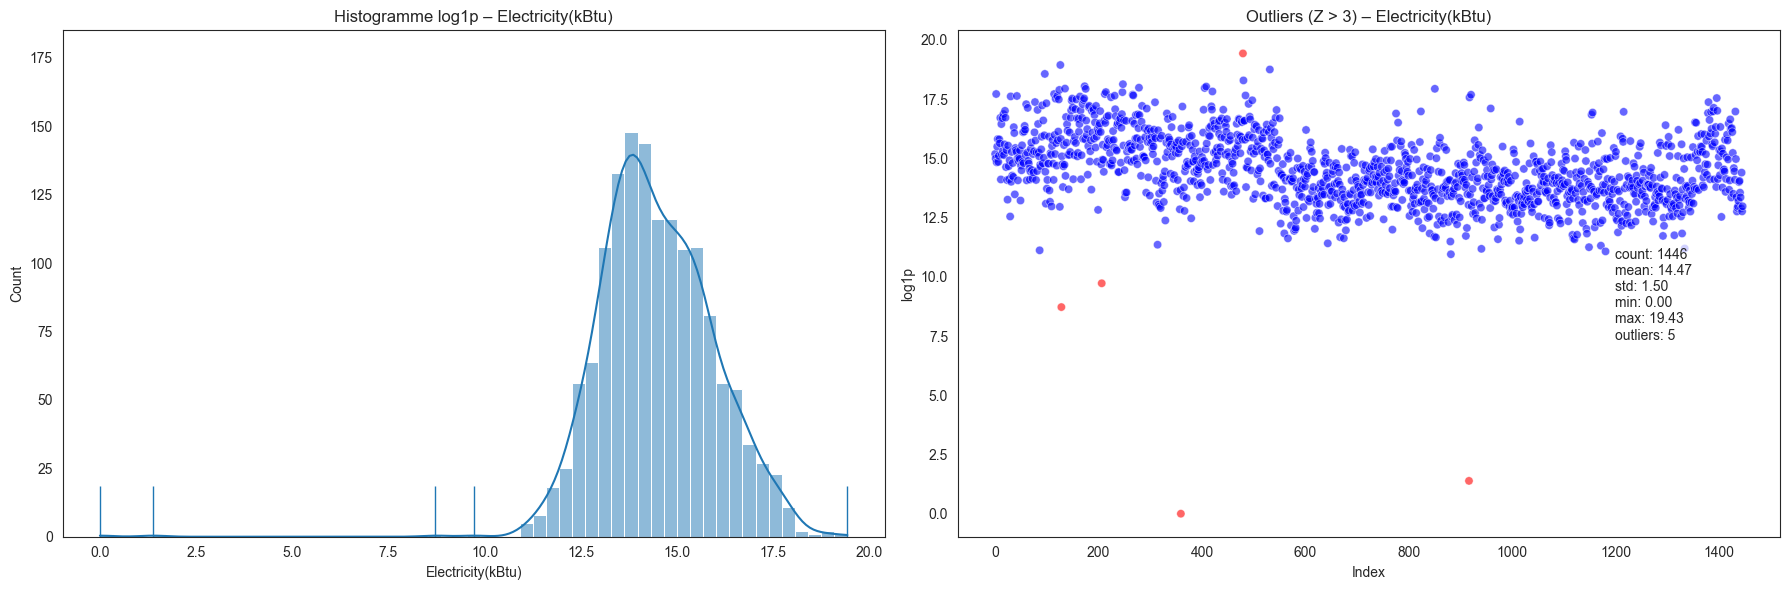

SiteEnergyUse(kBtu) : 5
SiteEnergyUseWN(kBtu) : 6
TotalGHGEmissions : 4
SiteEUIWN(kBtu/sf) : 17
SourceEUI(kBtu/sf) : 11
SourceEUIWN(kBtu/sf) : 13
Electricity(kWh) : 5
Electricity(kBtu) : 5


In [48]:

# Variables concernées : distributions asymétriques devenant exploitables après log1p
log_transform_cols = [
    'SiteEnergyUse(kBtu)', 
    'SiteEnergyUseWN(kBtu)',
    'TotalGHGEmissions', 
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'Electricity(kWh)',
    'Electricity(kBtu)'
]

# Colonnes effectivement présentes
analyze_cols = [col for col in log_transform_cols if col in df_raw.columns]

z_threshold = 3
output_dir = "../reports/notebook_1"
os.makedirs(output_dir, exist_ok=True)

def plot_log_outliers(data, col, z_threshold=3):
    # Suppression des NA uniquement
    log_vals = np.log1p(data.dropna())

    # Z-score
    mean = log_vals.mean()
    std = log_vals.std()
    zscores = (log_vals - mean) / std
    outlier_mask = zscores.abs() > z_threshold

    # Statistiques
    stats = {
        "count": len(log_vals),
        "mean": mean,
        "std": std,
        "min": log_vals.min(),
        "max": log_vals.max(),
        "outliers": outlier_mask.sum()
    }

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Histogramme
    sns.histplot(log_vals, kde=True, ax=axes[0])
    sns.rugplot(log_vals[outlier_mask], ax=axes[0], height=0.1)
    axes[0].set_title(f'Histogramme log1p – {col}')

    # Scatter
    sns.scatterplot(
        x=log_vals.index,
        y=log_vals,
        hue=outlier_mask,
        palette={True: "red", False: "blue"},
        ax=axes[1],
        alpha=0.6,
        legend=False
    )
    axes[1].set_title(f'Outliers (Z > {z_threshold}) – {col}')
    axes[1].set_xlabel("Index")
    axes[1].set_ylabel("log1p")

    # Stats
    stats_text = "\n".join(
        f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {v}"
        for k, v in stats.items()
    )
    plt.figtext(
        0.9, 0.5, stats_text,
        va="center", ha="left",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
    )

    plt.tight_layout()
    return fig, outlier_mask


# Copie pour flag
df_flagged = df_raw.copy()
outlier_counts = {}

for idx, col in enumerate(analyze_cols, start=1):
    fig, outlier_mask = plot_log_outliers(df_raw[col], col, z_threshold)

    safe_col = re.sub(r'[^\w\-_.]', '_', col)
    fig.savefig(f"{output_dir}/{idx:02d}_log_outliers_{safe_col}.png", dpi=300)
    plt.show()

    flag_col = f"is_outlier_{safe_col}"
    df_flagged[flag_col] = False
    df_flagged.loc[outlier_mask.index, flag_col] = outlier_mask

    outlier_counts[col] = outlier_mask.sum()

# Lignes outliers sur au moins une variable
outlier_cols = [
    f"is_outlier_{re.sub(r'[^\w\-_.]', '_', col)}"
    for col in analyze_cols
]
df_outliers_flagged = df_flagged[df_flagged[outlier_cols].any(axis=1)]

# Export
df_outliers_flagged.to_csv("outliers_flagged.csv", index=False)

# Résumé
for col, count in outlier_counts.items():
    print(f"{col} : {count}")


### Examen des valeurs atypiques : Cas variables log transforme

On observe que les variables d'intensité énergétique (SiteEUIWN, SourceEUI) présentent le plus grand nombre d'outliers (entre 11 et 17 individus). Cela suggère la présence de bâtiments dont la performance énergétique est radicalement différente de la moyenne du parc, soit par une efficacité exceptionnelle, soit par une consommation anormalement élevée par rapport à leur surface. En revanche, les variables de consommation brute (SiteEnergyUse, TotalGHGEmissions) comptent peu d'outliers (4 à 6), indiquant que les consommations extrêmes sont en grande partie corrélées à la taille des bâtiments. L'étape suivante consiste à croiser ces flags pour déterminer si ces anomalies concernent les mêmes infrastructures et si elles proviennent d'erreurs de saisie ou de spécificités métier (ex: centres de données, hôpitaux).

### identification des individus multi-outliers

Il est souvent plus pertinent de traiter un bâtiment qui est un outlier sur plusieurs variables plutôt qu'un seul.

In [49]:
# Calcul du nombre de flags par ligne
df_flagged['total_outlier_flags'] = df_flagged[outlier_cols].sum(axis=1)

# Liste des bâtiments ayant au moins un flag, triés par importance
outlier_summary = df_flagged[df_flagged['total_outlier_flags'] > 0][
    ['PropertyName', 'PrimaryPropertyType', 'LargestPropertyUseType', 'YearBuilt', 'NumberofBuildings'] 
    + analyze_cols + ['total_outlier_flags']
].sort_values(by='total_outlier_flags', ascending=False)

print(f"Nombre total de bâtiments avec au moins un outlier : {len(outlier_summary)}")
display(outlier_summary.head(15))

Nombre total de bâtiments avec au moins un outlier : 28


PropertyName          PrimaryPropertyType  \
479                       WestinBuilding                        Other   
881                 A1 Self Storage, LLC        Self-Storage Facility   
223      Onni 1411 Fourth Development LP                 Large Office   
189               Metropolitan Park East                 Large Office   
288                      200 First Ave W  Small- and Mid-Sized Office   
247         Fisher Plaza - West Building           Mixed Use Property   
1395        2020 Fifth Avenue Dat Center                        Other   
636                       Temple Beth Am             Worship Facility   
511                Westcore River Street          Distribution Center   
618   Green Lake United Methodist Church             Worship Facility   
182                 UW Tower Data Center                        Other   
163                      Norton Building                 Large Office   
880                    Mahoney Warehouse        Self-Storage Facility   
314                      Magnum Building                    Warehouse   
128          University HTS Grade School                  K-12 School   

          LargestPropertyUseType  YearBuilt  NumberofBuildings  \
479                  Data Center       1981                1.0   
881        Self-Storage Facility       1915                1.0   
223                       Office       1929                1.0   
189                       Office       1988                1.0   
288                       Office       1971                1.0   
247                      Parking       2001                1.0   
1395                 Data Center       1975                1.0   
636             Worship Facility       2000                1.0   
511          Distribution Center       1969                1.0   
618             Worship Facility       1910                1.0   
182                  Data Center       1969                1.0   
163                       Office       1958                1.0   
880        Self-Storage Facility       1980                1.0   
314   Non-Refrigerated Warehouse       1941                1.0   
128                  K-12 School       1928                1.0   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  TotalGHGEmissions  \
479          2.746822e+08           2.747260e+08            1921.82   
881          5.713320e+04           5.811420e+04               0.40   
223          5.446624e+06           0.000000e+00             238.09   
189          2.682322e+07           0.000000e+00             197.19   
288          3.484916e+06           0.000000e+00              24.29   
247          7.507389e+07           7.507389e+07             530.59   
1395         4.168064e+07           4.168064e+07             290.57   
636          1.128179e+06           0.000000e+00              27.14   
511          1.517543e+05           1.517543e+05               1.06   
618          4.964773e+05           0.000000e+00              18.66   
182          3.003849e+07           3.003849e+07             209.41   
163          2.490613e+07           0.000000e+00             940.47   
880          9.769040e+04           9.886290e+04               0.68   
314          2.275667e+05           2.729137e+05               8.15   
128          1.377627e+06           1.597907e+06              72.88   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
479           639.799988         2007.900024           2008.000000   
881             1.500000            4.500000              4.600000   
223             0.000000           92.300003              0.000000   
189             0.000000          227.899994              0.000000   
288             0.000000          157.000000              0.000000   
247           707.299988         2217.800049           2217.800049   
1395          694.700012         2181.300049           2181.300049   
636             0.000000           89.000000              0.000000   
511             2.100000           

Le tableau indique des profils très hétérogènes parmi les 28 bâtiments identifiés :

* **Individu 479 (Westin Building) & 182 (UW Tower) :** Ce sont des **Data Centers** (total_outlier_flags de 3 à 5). Leur consommation est gigantesque mais cohérente avec leur usage. Ce ne sont pas des erreurs, mais des points d'influence majeurs.
* **Individus 223, 189, 288 (Offices) :** Ils présentent un `SiteEnergyUseWN` de **0.00**. C'est une erreur manifeste de données (valeurs manquantes ou échec de la normalisation météo), d'où leur flag d'outlier.
* **Individus 881 & 511 (Entrepôts/Self-Storage) :** Des valeurs de consommation extrêmement basses. Bien que réelles, elles se situent dans la queue inférieure de la distribution log-normale.

L'examen des 28 bâtiments flaggés révèle trois profils d'atypisme distincts:

- Le premier concerne les infrastructures à très haute intensité énergétique comme le Westin Building (score de 5) et UW Tower (score de 3), qui sont des Data Centers dont la consommation massive est cohérente avec leur usage métier.
-  Le second profil rassemble une dizaine de bâtiments, principalement des bureaux et des lieux de culte, présentant systématiquement un score de 3 avec des valeurs de 0.00 pour toutes les variables normalisées par la météo. Cette régularité suggère une défaillance de l'algorithme de normalisation plutôt qu'une anomalie de consommation réelle.
- Le troisième profil comprend des entrepôts comme A1 Self Storage avec des consommations extrêmement basses mais réelles, situées dans la queue inférieure de la distribution.


#### Visualisation de la répartition des anomalies par bâtiment

<Figure size 1400x700 with 0 Axes>

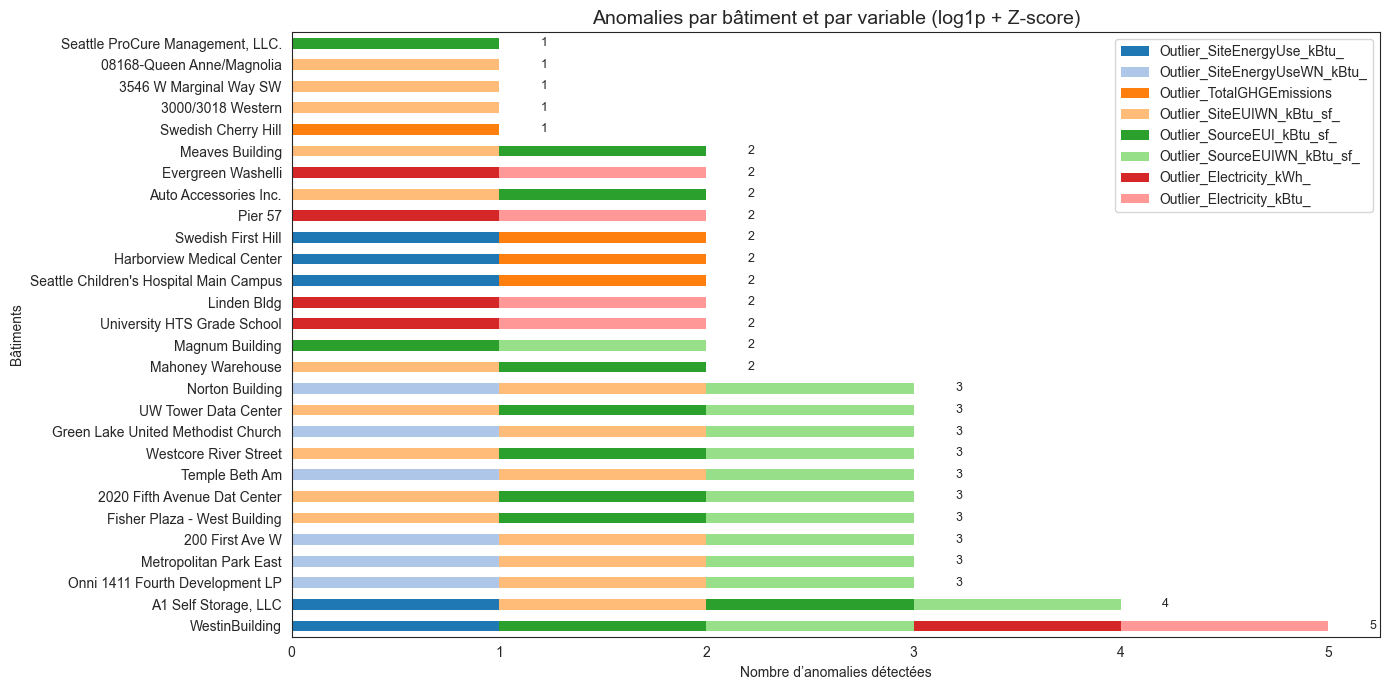

In [56]:

# 1) Préparer les colonnes d’outliers (booléens True/False)
#    On les convertit en colonnes numériques (0/1) avec noms explicites
colonnes_outliers = outlier_cols
df_outliers_flagged = df_flagged.copy()

# Renommer les colonnes pour plus de clarté (ex: is_outlier_SiteEnergyUse(kBtu) -> Outlier_SiteEnergyUse(kBtu))
colonnes_outliers_explicit = []
for col in colonnes_outliers:
    new_name = col.replace("is_outlier_", "Outlier_")
    df_outliers_flagged[new_name] = df_outliers_flagged[col].astype(int)
    colonnes_outliers_explicit.append(new_name)

# 2) Calcul du total d’outliers par bâtiment
df_outliers_flagged['Total_Outliers'] = df_outliers_flagged[colonnes_outliers_explicit].sum(axis=1)

# 3) Restreindre aux bâtiments avec au moins un outlier
df_batiments_outliers = df_outliers_flagged[df_outliers_flagged['Total_Outliers'] > 0]

# 4) Trier par gravité décroissante
df_batiments_outliers = df_batiments_outliers.sort_values(by='Total_Outliers', ascending=False)

# 5) Construire le DataFrame pour le graphique empilé
df_plot = df_batiments_outliers.set_index('PropertyName')[colonnes_outliers_explicit]

# 6) Tracé du graphique empilé
fig_height = max(6, len(df_plot) * 0.25)  # hauteur adaptative
plt.figure(figsize=(14, fig_height))

# Palette de couleurs
cmap = plt.get_cmap('tab20')
colors = [cmap(i % 20) for i in range(len(colonnes_outliers_explicit))]

df_plot.plot(kind='barh', stacked=True, color=colors, edgecolor='none', figsize=(14, fig_height))

plt.title("Anomalies par bâtiment et par variable (log1p + Z-score)", fontsize=14)
plt.xlabel("Nombre d’anomalies détectées")
plt.ylabel("Bâtiments")

# Annoter le total au bout de chaque barre
totaux = df_plot.sum(axis=1)
for y, total in enumerate(totaux.values):
    plt.text(total + 0.2, y, str(int(total)), va='center', fontsize=9)

plt.tight_layout()

# 7) Export du graphique
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/batiments_outliers_log_transf_empiles.png", dpi=300)
plt.show()


L'analyse conjointe du tableau récapitulatif et du graphique à barres horizontales permet d'isoler des profils d'atypisme très marqués au sein du jeu de données. Le WestinBuilding se détache nettement comme l'individu le plus critique avec 5 anomalies détectées, suivi de près par A1 Self Storage, LLC qui en cumule 4. Ces bâtiments sont des "multi-outliers" dont l'influence sur un modèle de régression linéaire classique pourrait être disproportionnée. On remarque également un groupe compact de dix bâtiments, incluant des bureaux comme Metropolitan Park East ou des lieux de culte comme le Temple Beth Am, qui présentent systématiquement 3 anomalies. Pour ces derniers, le graphique révèle une signature d'erreur récurrente : les flags concernent quasi exclusivement les versions "Weather Normalized" (WN) des consommations et des intensités énergétiques. Cette répétitivité suggère que le problème ne vient pas d'une consommation réelle extrême, mais d'un défaut dans l'algorithme de normalisation météorologique qui a généré des valeurs nulles ou aberrantes pour ces lignes spécifiques.

En revanche, pour la grande majorité des bâtiments ayant un score de 3 (de Norton Building à Onni 1411), l'anomalie est portée par les mêmes variables : SiteEnergyUseWN, SiteEUIWN et SourceEUIWN. C'est la preuve visuelle que l'atypisme est localisé sur le traitement météorologique de la donnée et non sur la consommation réelle.

#### Sélection des cas critiques pour investigation

In [57]:
# Sélection des individus ayant au moins 3 anomalies
problematic_buildings = df_flagged[df_flagged['total_outlier_flags'] >= 3].copy()

# Affichage des colonnes clés pour comprendre la nature de l'erreur
cols_to_show = ['PropertyName', 'PrimaryPropertyType', 'total_outlier_flags', 
                'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)']

print(f"Nombre de bâtiments hautement suspects : {len(problematic_buildings)}")
display(problematic_buildings[cols_to_show].sort_values(by='total_outlier_flags', ascending=False))

Nombre de bâtiments hautement suspects : 12


PropertyName          PrimaryPropertyType  \
479                       WestinBuilding                        Other   
881                 A1 Self Storage, LLC        Self-Storage Facility   
163                      Norton Building                 Large Office   
182                 UW Tower Data Center                        Other   
223      Onni 1411 Fourth Development LP                 Large Office   
189               Metropolitan Park East                 Large Office   
288                      200 First Ave W  Small- and Mid-Sized Office   
247         Fisher Plaza - West Building           Mixed Use Property   
511                Westcore River Street          Distribution Center   
618   Green Lake United Methodist Church             Worship Facility   
636                       Temple Beth Am             Worship Facility   
1395        2020 Fifth Avenue Dat Center                        Other   

      total_outlier_flags  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
479                     5         2.746822e+08           2.747260e+08   
881                     4         5.713320e+04           5.811420e+04   
163                     3         2.490613e+07           0.000000e+00   
182                     3         3.003849e+07           3.003849e+07   
223                     3         5.446624e+06           0.000000e+00   
189                     3         2.682322e+07           0.000000e+00   
288                     3         3.484916e+06           0.000000e+00   
247                     3         7.507389e+07           7.507389e+07   
511                     3         1.517543e+05           1.517543e+05   
618                     3         4.964773e+05           0.000000e+00   
636                     3         1.128179e+06           0.000000e+00   
1395                    3         4.168064e+07           4.168064e+07   

      SiteEUIWN(kBtu/sf)  
479           639.799988  
881             1.500000  
163             0.000000  
182           834.400024  
223             0.000000  
189             0.000000  
288             0.000000  
247           707.299988  
511             2.100000  
618             0.000000  
636             0.000000  
1395          694.700012

Le tableau identifie le WestinBuilding comme l'anomalie la plus forte (score de 5) avec une intensité énergétique (SiteEUIWN) très élevée (639.8), suivi par A1 Self Storage qui, à l'inverse, présente un score de 4 en raison de valeurs extrêmement faibles (EUI de 1.5). On observe que pour les bureaux (Norton Building, Metropolitan Park East, etc.), le score de 3 est systématiquement lié à des valeurs de 0.000000 pour toutes les colonnes avec le suffixe "WN". Cette dichotomie confirme l'existence de deux populations d'outliers distinctes : les outliers légitimes liés à l'usage du bâtiment, et les outliers artificiels résultant d'une défaillance du processus de normalisation météorologique.

#### Quantification des erreurs de normalisation météorologique

Comme observé sur le graphique, beaucoup d'outliers sont dus à des valeurs nulles dans les colonnes normalisées.

In [58]:
# Recherche des bâtiments où la consommation brute existe mais la normalisée est à 0
normalization_errors = df_flagged[
    (df_flagged['SiteEnergyUse(kBtu)'] > 0) & 
    (df_flagged['SiteEnergyUseWN(kBtu)'] == 0)
]

print(f"Bâtiments avec erreur de normalisation (WN=0) : {len(normalization_errors)}")
display(normalization_errors[['PropertyName', 'PrimaryPropertyType', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']])

Bâtiments avec erreur de normalisation (WN=0) : 6


PropertyName          PrimaryPropertyType  \
163                     Norton Building                 Large Office   
189              Metropolitan Park East                 Large Office   
223     Onni 1411 Fourth Development LP                 Large Office   
288                     200 First Ave W  Small- and Mid-Sized Office   
618  Green Lake United Methodist Church             Worship Facility   
636                      Temple Beth Am             Worship Facility   

     SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  
163         2.490613e+07                    0.0  
189         2.682322e+07                    0.0  
223         5.446624e+06                    0.0  
288         3.484916e+06                    0.0  
618         4.964773e+05                    0.0  
636         1.128179e+06                    0.0

L'identification de ces cas spécifiques où la consommation réelle est positive mais la version normalisée nulle permet d'isoler précisément les lignes affectées par le dysfonctionnement. Ces enregistrements représentent des erreurs de traitement qui, si elles ne sont pas corrigées, introduiront un biais systématique dans toute modélisation ultérieure utilisant les variables WN.

###  Diagnostic visuel : Cohérence entre consommation brute et normalisée

Pour confirmer ou pas  visuellement que l'anomalie vient d'un écart incohérent entre la mesure réelle et la mesure corrigée.

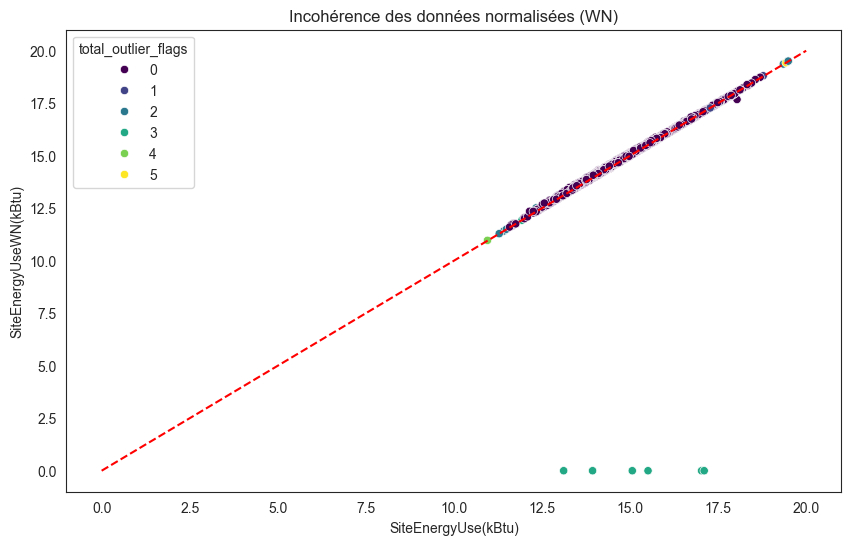

In [59]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_flagged,
    x=np.log1p(df_flagged['SiteEnergyUse(kBtu)']),
    y=np.log1p(df_flagged['SiteEnergyUseWN(kBtu)']),
    hue='total_outlier_flags',
    palette='viridis'
)
plt.title("Incohérence des données normalisées (WN)")
plt.plot([0, 20], [0, 20], 'r--') # Ligne d'égalité théorique
plt.show()

Le graphique de dispersion révèle l'ampleur du problème de normalisation. Alors que la majorité des points s'alignent sur la bissectrice rouge, indiquant une corrélation attendue entre consommation brute et normalisée, un groupe de points forme une ligne horizontale à y=0 avec des abscisses élevées. Ces bâtiments possèdent une consommation réelle significative mais une valeur normalisée nulle, ce qui est physiquement impossible. Le code couleur confirme que ces points correspondent quasi exclusivement aux multi-outliers de score 3, validant l'hypothèse que leur statut d'anomalie provient d'un échec algorithmique et non d'une performance énergétique exceptionnelle.

### Analyse contextuelle par type de bâtiment: siteEUIWN
    
Certains types de bâtiments (ex: Data Centers et bureaux) sont "normalement" des outliers par rapport à d'autres
SiteEUIWN(kBtu/sf) est le top outlider

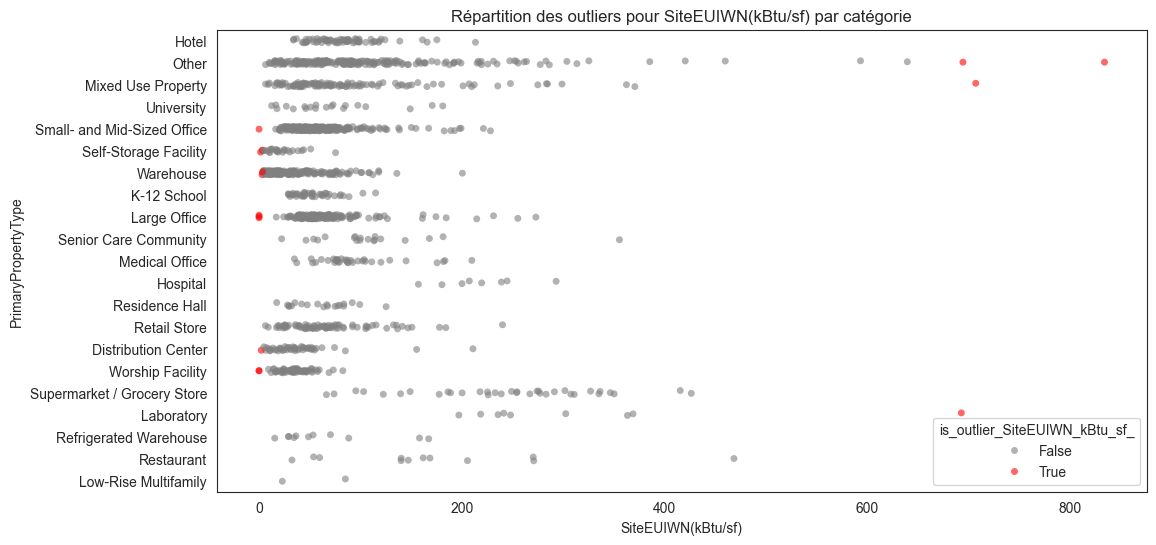

In [51]:
# Focus sur la variable la plus problématique : SiteEUIWN(kBtu/sf)
top_outlier_col = 'SiteEUIWN(kBtu/sf)'
flag_name = f"is_outlier_{re.sub(r'[^\w\-_.]', '_', top_outlier_col)}"

plt.figure(figsize=(12, 6))
sns.stripplot(
    data=df_flagged, 
    x=top_outlier_col, 
    y='PrimaryPropertyType', 
    hue=flag_name,
    palette={True: "red", False: "gray"},
    alpha=0.6
)
plt.title(f"Répartition des outliers pour {top_outlier_col} par catégorie")
plt.show()

La distribution des outliers par type de bâtiment permet de distinguer les anomalies légitimes des anomalies suspectes. Les catégories Other, Mixed Use Property et Laboratory présentent des points rouges à l'extrême droite du spectre (EUI supérieur à 600 kBtu/sf), ce qui est cohérent avec des usages à haute densité énergétique comme les Data Centers ou les équipements de recherche. En revanche, l'accumulation de points rouges proche de zéro pour les catégories Large Office et Worship Facility pose problème. Il est physiquement improbable qu'un grand bureau opérationnel présente une intensité énergétique quasi nulle, ce qui renforce l'hypothèse d'erreurs de relevés ou de données manquantes encodées comme des zéros.

### Conclusion et recommandation



# Section 4 : Analyse de fiabilité

# Section 5 : Analyse de doublons


# Section 6 : Plan d'action